# TFM Final Project <img style="display: inline; align-right: 250px; position: absolute; right: 0px;" src="files/Logo-AIT-Red600x-8.webp" width="130"/>

👉 Berta Pfaff</br>
👉 Sergio Salvador</br>
👉 Francesc Vilaró</br>

# Project motivation

**Movie recommendation systems have become increasingly popular in recent years** due to the vast amount of movies available for viewers to watch. With the rise of streaming services like Netflix, Hulu, and Amazon Prime, **it has become harder for viewers to decide which movie to watch**, given the plethora of options available.

The proposed project aims to **build a movie recommender system using Python, leveraging the TMDB API to fetch movie metadata from 1980 until 2023**. The TMDB (The Movie Database) is an online database that provides comprehensive information related to movies, TV shows, and other forms of visual media. It is a community-driven platform that is curated and maintained by a team of editors and contributors who gather information from various sources, such as film studios, production companies, and fan communities, among others. The TMDB API (Application Programming Interface) provides developers with access to this wealth of data, allowing them to retrieve and use movie and TV show metadata in their own applications and projects.

The project will consist of three main parts:

1. **Database design**: An Entity-Relationship model (ERM) will be first created, defining the entities, attributes, and relationships that need to be stored in the database. The next step is to create tables that correspond to the entities and attributes identified in the previous step. Each table should contain columns for the various attributes, along with appropriate data types and constraints.


2. **Data fetching**: Asynchronous calls to the TMDB API will be used to fetch movie data, such as title, genre, release date, and ratings, among others. Traditional methods such as synchronous API requests would be to slow and inefficient for this aplication. Finally, data will be stored in a mySQL database, allowing for high performance and fast access.


3. **EDA (Exploratory Data Analysis)**: Data visualization techniques will be applied to explore and understand the data. Graphs, charts, and histograms will be used to identify trends, patterns, and outliers, which can help improve the model's accuracy and obtain an overall understanding of the movie market in the last 40 years.


4. **Recommendation model**: A model will be built using advanced machine learning algorithms. The model will be trained on the movie metadata to generate personalized movie recommendations. the proposed model will utilize a complex algorithm that takes into consideration numerous variables, such as the movie's plot overview, the cast of actors, and the directors involved in its production, among other factors, to ultimately <u>recommend a set of five other movies that share similarities and patterns with the original movie</u>. This comprehensive approach not only provides a reliable and accurate way to suggest new movie options to viewers but also ensures that the recommended movies align with the viewer's preferences and tastes, resulting in a highly personalized and satisfying viewing experience.

Overall, this project aims to provide a convenient and personalized movie recommendation system that can help users discover new movies they will enjoy. Additionally, the project will also provide an opportunity to learn and apply several data science techniques learned throughout the master's degree, such as data retrieval, data visualization, and machine learning.

# Imported libraries

The following libraries have been used to accomplish the following project:

In [8]:
import mysql.connector
import pandas as pd
import warnings
import requests
import time
from IPython.display import clear_output
import csv
from datetime import date, timedelta
import ast
import asyncio
import aiohttp
import os
import json
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
import transformers
from transformers import BertTokenizer, BertModel
import torch

warnings.filterwarnings('ignore')

%matplotlib inline

plt.style.use('bmh') #setting up 'bmh' as "Bayesian Methods for Hackers" style sheet

## Database design

### Database creation and connection

Connection to a local mySQL server is established using the 'mysql.connector' library and providing the needed parameters. Finally, a cursor object is instantiated to allow interaction with the database.

In [2]:
warnings.filterwarnings("ignore") # Warnings are disabled

db = mysql.connector.connect(
    host = "localhost",
    user = "root",
    password= "12345"
)

cursor = db.cursor()

A new database called 'TMDB' is created and connection to server is established again, this time specifying the 'TMDB' database in the 'database' parameter

In [3]:
cursor.execute("CREATE DATABASE TMDB")
db.commit()

In [4]:
warnings.filterwarnings("ignore") # Warnings are disabled

db = mysql.connector.connect(
    host = "localhost",
    user = "root",
    password= "12345",
    database= "TMDB"
)

cursor = db.cursor()

### API schema analysis

Before starting to design the structure of the database, an in-depth analysis of the structure and content of the responses that the TMDB API provides is needed, in order to identify the entities, attributes, and relationships that exist in the data model.

The TMDB API provides some endpoints of interest to this project:

#### GET discover/movies

The GET discover/movie endpoint in the TMDB API **retrieves a list of movies that match certain criteria**. This endpoint allows users to discover movies by exploring different filtering options, such as release year, genre, language, and more. When making a request to the GET discover/movie endpoint, you can include various query parameters to customize the search criteria. For example, you can specify a minimum or maximum release date, a specific language, or a specific genre ID.

The response to a GET discover/movie request includes a list of movies that match the specified criteria, along with metadata such as the movie title, release date, poster image, and more. Each movie in the response is represented as an object with various fields that provide information about the movie.

For this project in particular, we need to fetch all movies from 1980 to 2023, so we will be using the following query parameters:
 - **"primary_release_date.gte"**: Allows to obtain movies whose release date is greater than or equal to the input date
 - **"primary_release_date.lte"**: Allows to obtain movies whose release date is lower than or equal to the input date
 - **"page"**: Every request returns only 20 results at a time, so a page parameter is needed to fetch all the results
 
 An example of a request using the GET discover/movie endpoint with only one result would be:

<img src="files/example_GET_discover_movie.png" style="border: 1px solid black;">

We will need more information on each movie than the one provided by the GET discover/movie endpoint, so we will be using this method to fetch only the movie id's from every movie from 1980 to 2023.

#### GET movie details endpoint

Once we get all the IDs from the movies we can use GET movie/details endpoint in the TMDB API to retrieve all the details of a specific movie identified by its unique movie ID. This endpoint allows you to retrieve comprehensive information about a movie, including its title, overview, release date, runtime, genres, production companies, cast and crew, ratings, posters, trailers, and more.

To use this endpoint, you need to provide the movie ID as a path parameter in the URL of the API request. For example, to retrieve the details of the movie "The Godfather" (which has a movie ID of 238), you would make a GET request to the following URL:

https://api.themoviedb.org/3/movie/238?api_key=YOUR_API_KEY

In the response from this endpoint, you will receive a JSON object containing all the available information about the movie, structured according to the TMDB API data model. Following the same example, the requested JSON object for "The Godfather" movie would be:

<img src="files/example_GET_movie_details.png" style="border: 1px solid black;">

Has you can see, the previous request is more complete that the one provided by the GET discover/movie endpoint. Still, no information about the cast and the crew involved in the making of the movie is provided. To obtain this information we will have to use the append_to_response parameter. This parameter allows to include additional information about a movie in the API response, such has cast and crew.

#### GET genre/movie/list endpoint

The GET /genre/movie/list endpoint in the TMDB API is used to retrieve a list of all the movie genres available in the TMDB database.

When you make a request to this endpoint, you will receive a JSON object containing an array of genre objects, each of which includes the following information:

- id: A unique identifier for the genre.
- name: The name of the genre.

Here is an example response from the GET /genre/movie/list endpoint:

<img src="files/example_GET_genre_movie_list.png" style="border: 1px solid black;">

You can use the id values returned from this endpoint to filter movies by genre in other TMDB API endpoints, such as the GET discover/movie endpoint, which allows you to search for movies based on various criteria, including genre.

#### GET /watch/providers/movie endpoint

The GET /watch/providers/movie endpoint in the TMDB API is used to retrieve information about all the streaming companies available in the TMDB platform.

When you make a request to this endpoint, you can include the watch_region parameter to specify the ISO 3166-1 code for the region you're interested in.

The response to this request will include an object containing the following information:


- results: An array of provider objects, each of which includes the following information:
 - display_priority: The display priority of the provider for the movie in the specified region.
 - logo_path: The path to the logo image for the provider.
 - provider_name: The name of the streaming provider.
 - provider_id: The ID of the streaming provider.

For example, to retrieve all the movie providers in Spain, we would make a GET request to the following URL

https://api.themoviedb.org/3/watch/providers/movie?api_key=YOUR_API_KEY&watch_region=ES

Which would return the following response:

<img src="files/example_GET_watch_providers_movie.png" style="border: 1px solid black;">

Please note that a portion of the response above has been ommited to avoid overwhelming the screen with excessive information.

#### GET movie providers endpoint

Since the append_to_response parameter in the GET movie details endpoint doesn't support watch providers, we have to fetch them separately using GET watch providers.

The GET watch providers method is a function of the TMDB API that allows you to retrieve a list of streaming providers for a specific movie. This method provides information about where you can watch a particular title, along with links to the corresponding streaming service.

To use this method, you need to make a GET request to the following endpoint:

https://api.themoviedb.org/3/movie/{movie_id}/watch/providers?api_key=YOUR_API_KEY

To use this endpoint, you need to provide the movie ID as a path parameter in the URL of the API request. For example, to retrieve the watch providers for the movie "The Godfather" (which has a movie ID of 238), you would make a GET request to the following URL:

https://api.themoviedb.org/3/movie/238/watch/providers?api_key=YOUR_API_KEY

In the response from this endpoint, you will receive a JSON object containing all the available information about the available watch providers. Following the same example, the requested JSON object for "The Godfather" movie would be:


<img src="files/example_GET_watch_providers.png" style="border: 1px solid black; width:800px">

Please note that a portion of the response above has been ommited to avoid overwhelming the screen with excessive information.

### Entity-Relationship model (ERM)

An ERM model is firstly defined to represent the entities and relationships of the database. 

The database will consist of the following main tables:

- **movie_ table**: The main table. This table will store the data unique to every movie, such as title, overview or runtime.
- **str_comp_ table**: Stores all the flatrate streaming companies available in Spain
- **prod_comp table**: Stores all the production companies
- **genre table**: Stores all the available genres in the TMDB platform
- **person table**: Stores the main crew and cast that have been involved in the movies of the database.
- **jobs table**: Stores the jobs that will be considered for adding a person to the database. In this case, only roles of actor, director and screenplay have been considered.

Junction tables (red tables on the ERM diagram) are needed to avoid many-to-many relationships between the main table and every other table. For instance, for a particular movie, there can be various streaming companies and a particular streaming company can stream various movies. This kind of relationship is impossible to represent in a structured database such as SQL, so a middle table is created to relate both tables using foreign keys.

The meaning of each attribute for each table will be explained as we create them, so as not to clutter this Jupyter cell with too much text.

<img src="files/DB_ERM_v2.png" style="width:700px">

### Table creation

Next, all tables in our mySQL database have to be created before being populated.

#### movie table creation

This is the main table. Consists of the following columns:
- **id_movie**: Movie unique identifier provided by TMDB API
- **original_title**: Movie title maintaining original alphabet
- **overview**: Brief summary of the movie's plot
- **popularity**: Value atributed by the TMDB platform based on multiple factors to indicate the level of interest and attention that the movie is receiving from the public.
- **poster_path**: Endpoint to the movie's poster image
- **release_date**: Date of the primary release of the movie given in the format YYYY-MM-DD
- **title**: Movie title translated to english
- **vote_average**: Average vote given by TMDB users
- **vote_count**: Number of votes
- **budget**: Total cost of movie production
- **revenue**: Total amount of money that the movie has generated given in american dollars 
- **runtime**: total duration of the movie given in minutes

All of the data needed to populate this table can be obtained using the GET movie details endpoint explained above.

In [5]:
query_movie = """
    CREATE TABLE movie(
        id_movie int,
        original_title varchar(300),
        original_language varchar(20), 
        overview varchar(1000),
        popularity float,
        poster_path varchar(200),
        release_date varchar(20),
        title varchar(300),
        vote_average float,
        vote_count int,
        budget int, 
        revenue bigint,
        runtime int,
        PRIMARY KEY (id_movie)
    )
"""

cursor.execute(query_movie)
db.commit()

#### Streaming companies

All tables related to the streaming companies are created simultaneously:

##### str_comp table creation

This table stores all unique streaming companies available in our dataset. Consists of two columns:

- **id_str_comp**: Autoincremental ID given to every unique streaming company. This ID is not provided by the TMDB API
- **name**: Streaming company name (e.g. Netflix)

In [6]:
query_str_comp = """
    CREATE TABLE str_comp (
    id_str_comp int AUTO_INCREMENT,
    name varchar(50),
    PRIMARY KEY (id_str_comp)
)
"""

cursor.execute(query_str_comp)
db.commit()

##### movie_str_comp junction table creation

This junction table is created to represent a many-to-many relationship between movies and streaming companies in our SQL database.

Each record in the "movie_str_comp" table represents a unique combination of a movie and a streaming company or studio, and the "id_movie" and "id_str_comp" columns store the foreign keys that reference the primary keys of the "movie" and "str_comp" tables, respectively.

Consists of the following columns:

- **id_mov_str_comp**: This is a unique identifier for each record in the junction table, and is set to auto-increment.

- **id_movie**: Stores the foreign key of the "movie" table, which is used to link the junction table to the "movie" table.

- **id_str_comp**: Stores the foreign key of the "str_comp" table, which is used to link the junction table to the "str_comp" table.

In [7]:
query_movie_str_comp = """
    CREATE TABLE movie_str_comp (
    id_mov_str_comp int AUTO_INCREMENT,
    id_movie int,
    id_str_comp int,
    PRIMARY KEY (id_mov_str_comp),
    FOREIGN KEY (id_movie) REFERENCES movie(id_movie),
    FOREIGN KEY (id_str_comp) REFERENCES str_comp(id_str_comp)
)
"""

cursor.execute(query_movie_str_comp)
db.commit()

#### Production companies

All tables related to the streaming companies are created simultaneously:

##### prod_comp table creation

This table stores all unique production companies available in our dataset. Consists of three columns:

- **id_prod_comp**: ID given to every unique production company. This ID is provided by the TMDB API
- **name**: Production company name (e.g. Paramount)
- **origin_country**: Country of origin of the production company, based on the ISO 3166-1 standard

In [8]:
query_prod_comp = """
    CREATE TABLE prod_comp ( 
         id_prod_comp int NOT NULL,
         name varchar (100),
         origin_country varchar (20),

         PRIMARY KEY (id_prod_comp)
      )
"""
cursor.execute(query_prod_comp)
db.commit()

##### movie_prod_comp junction table creation

This junction table is created to represent a many-to-many relationship between movies and production companies or studios in our SQL database.

Each record in the "movie_str_comp" table represents a unique combination of a movie and a production company or studio, and the "id_movie" and "id_prod_comp" columns store the foreign keys that reference the primary keys of the "movie" and "prod_comp" tables, respectively.

Consists of the following columns:

- **id_mov_prod_comp**: This is a unique identifier for each record in the junction table, and is set to auto-increment.

- **id_movie**: Stores the foreign key of the "movie" table, which is used to link the junction table to the "movie" table.

- **id_prod_comp**: Stores the foreign key of the "prod_comp" table, which is used to link the junction table to the "prod_comp" table.

In [9]:
query_movie_prod_comp = """
    CREATE TABLE movie_prod_comp (
        id_mov_prod_comp int AUTO_INCREMENT,
        id_movie int,
        id_prod_comp int,
        
        PRIMARY KEY (id_mov_prod_comp),
        FOREIGN KEY (id_movie) REFERENCES movie(id_movie),
        FOREIGN KEY (id_prod_comp) REFERENCES prod_comp(id_prod_comp)
      )
"""
cursor.execute(query_movie_prod_comp)
db.commit()

#### Genres

All tables related to the streaming companies are created simultaneously:

##### genre table creation

This table stores all unique movie genres available in our dataset. Consists of two columns:

- **id_genre**: ID given to every unique movie genre. This ID is provided by the TMDB API
- **genre**: Name of the genre (e.g. Comedy) 

In [10]:
query_genre = """
    CREATE TABLE genre ( 
         id_genre int NOT NULL,
         genre varchar (30),

         PRIMARY KEY(id_genre)
      )
"""
cursor.execute(query_genre)
db.commit()

##### movie_genre table creation

This junction table is created to represent a many-to-many relationship between movies and genres in our SQL database.

Each record in the "movie_genre" table represents a unique combination of a movie and a genre, and the "id_movie" and "id_genre" columns store the foreign keys that reference the primary keys of the "movie" and "genre" tables, respectively.

Consists of the following columns:

- **id_mov_genre**: This is a unique identifier for each record in the junction table, and is set to auto-increment.

- **id_movie**: Stores the foreign key of the "movie" table, which is used to link the junction table to the "movie" table.

- **id_genre**: Stores the foreign key of the "genre" table, which is used to link the junction table to the "genre" table.

In [11]:
query_movie_genre = """
    CREATE TABLE movie_genre (
        id_mov_genre int AUTO_INCREMENT,
        id_movie int,
        id_genre int,

        PRIMARY KEY (id_mov_genre),
        FOREIGN KEY (id_movie) REFERENCES movie(id_movie),
        FOREIGN KEY (id_genre) REFERENCES genre(id_genre)
      )
"""
cursor.execute(query_movie_genre)
db.commit()

#### People

All tables related to people are created simultaneously. A person can be an actor or someone from the crew, for example, a director

##### _person_ table creation

This table stores all people available in our dataset. Consists of three columns:

- **id_person**: ID given to every unique movie genre. This ID is provided by the TMDB API
- **name**: Name of the person (e.g. Brad Pitt)
- **gender**: Binary column. Can adopt two values: 1 (Female) and 2 (Male)

In [12]:
query_person = """
    CREATE TABLE person ( 
         id_person int NOT NULL,
         name varchar (50),
         gender int,

         PRIMARY KEY (id_person)
      )
"""
cursor.execute(query_person)
db.commit()

##### job table creation

This table stores the jobs of the people (crew and cast) involved in the movies. For this project we have only considered three jobs: Actor, Director and Screenplay. Although the production of a movie involves many more jobs, we have omitted some from our project to keep it manageable.

This table consists of two columns:

- **id_job**: ID given to every job. This ID is not provided by the TMDB API
- **job_name**: Name of the job (e.g. Actor)

In [13]:
query_job = """
    CREATE TABLE job (
        id_job int AUTO_INCREMENT,
        job_name varchar(50),
        
        PRIMARY KEY (id_job)
      )
"""
cursor.execute(query_job)
db.commit()

##### movie_person junction table creation

This junction table is created to represent a many-to-many relationship between movies and people in our SQL database.

Each record in the "movie_person" table represents a unique combination of a movie and a person, and the "id_movie" and "id_person" columns store the foreign keys that reference the primary keys of the "movie" and "person" tables, respectively.

Consists of the following columns:

- **id_mov_person**: This is a unique identifier for each record in the junction table, and is set to auto-increment.

- **id_movie**: Stores the foreign key of the "movie" table, which is used to link the junction table to the "movie" table.

- **id_person**: Stores the foreign key of the "person" table, which is used to link the junction table to the "person" table.

- **id_job**: Stores the foreign key of the "job" table, which is used to link the junction table to the "job" table.

In [14]:
query_movie_person = """
    CREATE TABLE movie_person ( 
         id_mov_person int AUTO_INCREMENT,
         id_movie int,
         id_person int,
         id_job int,

         PRIMARY KEY (id_mov_person),
         FOREIGN KEY (id_movie) REFERENCES movie(id_movie),
         FOREIGN KEY (id_person) REFERENCES person(id_person),
         FOREIGN KEY (id_job) REFERENCES job(id_job)
      )
"""
cursor.execute(query_movie_person)
db.commit()

## Data fetching

To register for an TMDB API key, you must first login into TMDB webpage and then click the API link from within your account settings page. 

The API key used throughout this project is the following (keep in mind that this API key is personal and that you should generate your own API key):

In [15]:
api_key = "ac6862efab2ddf803567630c9f474ab8"

### Independent tables generation

Some of the tables in our database (specifically the genres, streaming companies and jobs tables) have to be populated separately, since they use diferent API request endpoints to fetch the information.

#### Genres table

To fetch the genres information, we need to use the following request URL and query parameters:

In [16]:
url_genres = "https://api.themoviedb.org/3/genre/movie/list"

query_params = {
                "api_key": api_key,
}

We define the a function to get all the genres available in the TMDB API:

In [17]:
def get_genres(url_genres, query_params):
    """
    This function, given a request URL and query parameters, sends a request to the TMDB API and returns a list of tuples 
    containing the id and name of all the available genres.
    """
    # The request is made to the API using the requests library
    response = requests.get(url_genres, query_params).json()
    
    # ID and name are then filtered and appended to a list using list comprehension
    genres = [(genre['id'], genre['name']) for genre in response['genres']]
    
    return genres

If we show the first available genre, we obtain the following tupple, where the first element is the genre's id and the second element is the genre's name:

In [18]:
genres = get_genres(url_genres, query_params)
genres[0]

(28, 'Action')

Having fetched all of the genres available in the TMDB platform, we can now define a function to populate the 'genre' table:

In [19]:
def populate_genre(genres):
    """
    This function takes a list of tupples of movie genres and populates a table called 'genre' in a SQL database.
    Each tupple has two elements: genre ID and genre name.
    """
    # An insert query is defined to populate the genre table
    insert_query = """
    INSERT INTO genre
    (id_genre, genre)
    VALUES(%s, %s)
    """
    
    # Since we have a list of tupples, we can populate the 'genre' table all at once by using the executemany method
    cursor.executemany(insert_query, genres)
    db.commit()

We finally populate the 'genre' table by calling populate_genre() and passing the fetched genres as a parameter:

In [20]:
populate_genre(genres)

After populating 'genre', the table looks like this:

<img src="files/populated_genre_table.png" style="border: 1px solid black; width: 200px">

Keep in mind that only a portion of the table is shown in the image above, since it as a large amount of rows and would be unmanageable to show them all on screen.

#### Streaming Companies table

To fetch the streaming companies information, we need to use the following request URL and query parameters.

We use the watch_region parameter set to "ES", since we only want to obtain the streaming companies that operate in Spain.

In [21]:
url_str_comps = "https://api.themoviedb.org/3/watch/providers/movie"

query_params_str_comps = {
                "api_key": api_key,
                "watch-region": "ES"
}

We define the a function to get all the streaming companies available in the TMDB API:

In [22]:
def get_str_comps(url_str_comps, query_params_str_comp):
    """
    This function sends a request to the TMDB API and returns a list of tuples 
    containing the ID and name of all the available streaming companies. 
    """
    
    # Request is made using the 'requests' library
    response = requests.get(url_str_comps, query_params_str_comps).json()
    
    # ID and name are stored for every streaming company using list comprehension
    str_comps = [(result['provider_id'], result['provider_name']) for result in response['results']]
    
    return str_comps

If we show the first available streaming company, we obtain the following tupple, where the first element is the streaming company id and the second element is the streaming company name:

In [23]:
str_comps = get_str_comps(url_str_comps, query_params_str_comps)
str_comps[0]

(2, 'Apple TV')

Having fetched all of the genres available in the TMDB platform, we can now define a function to populate the 'genre' table:

In [24]:
def populate_str_comps(str_comps):
    """
    This function takes a list of tupples of streaming companies and populates a table called 'str_comp' in a SQL database.
    Each tupple has two elements: streaming company ID and name.
    """
    
    # An insert query is defined to populate the 'str_comp' table
    insert_query = """
    INSERT INTO str_comp
    (id_str_comp, name)
    VALUES(%s, %s)
    """
    
    # Since we have a list of tupples, we can populate the 'str_comps' table all at once by using the executemany method
    cursor.executemany(insert_query, str_comps)
    db.commit()

We finally populate the 'str_comp' table by calling populate_str_comps() and passing the fetched streaming companies as a parameter:

In [25]:
populate_str_comps(str_comps)

After populating 'genre', the table looks like this:

<img src="files/populated_str_comp_table.png" style="border: 1px solid black; width: 200px">

Keep in mind that only a portion of the table is shown in the image above, since it as a large amount of rows and would be unmanageable to show them all on screen.

#### Jobs table 

We define three major roles to be fetched from the TMDB database. This is completely scalable and more roles could be included in future versions of this project.

In [26]:
jobs = ['Actor', 'Director','Screenplay']

The jobs defined above are inserted into the database through the following function:

In [27]:
def populate_job(jobs):
    """
    This function takes a list of tupples of jobs and populates a table called 'job' in a SQL database.
    Each tupple has two elements: job ID and job name.
    """
    
    # An insert query is defined to populate the 'job' table
    insert_query = """
    INSERT INTO job
    (job_name)
    VALUES(%s)
    """
    # Jobs are introduced one by one into the SQL database using the execute method
    for job in jobs:
        cursor.execute(insert_query, [job])
    db.commit()

'jobs' table is populated by calling populate_job() and passing the jobs list as a parameter:

In [28]:
populate_job(jobs)

After populating 'job', the table looks like this:

<img src="files/populated_job_table.png" style="border: 1px solid black; width: 200px">

### Movies IDs

Since all tables are created and the independent tables have been populated, we can now begin to fetch the movies IDs by using the GET discover/movie endpoint.

Let's first define some needed parameters:

In [29]:
# We define the range of years we want to fetch from the TMDB database
start_year = 1980
end_year = 1980

# GET discover/movie endpoint
url_discover = "https://api.themoviedb.org/3/discover/movie"

#### Parameter generation

Since the TMDB API only returns 20 results per page and a maximum of 500 pages, we decided to make the requests month by month for every year in the range (start_year, end_year). To do this, we will pass the first and last day of every month as a request parameter.

Given a start year and an end year, we can easily obtain the first and last day of every month through the following function:

In [30]:
def month_range_dict(start_year, end_year):
    """
    Returns a dictionary that maps the first day of a month to the last day of the month, given a start and end year.
    """
    
    # The dictionary that will map the first day to the last day of a month is initialized
    month_range = {}
    
    # We obtain the first day of the start year and the last day of the end year and pass it to date format
    start_date = date(start_year, 1, 1)
    end_date = date(end_year, 12, 31)

    # Iterate over all months between start and end dates
    while start_date < end_date:
        
        # Year and month are fetched
        year = start_date.year
        month = start_date.month
        
        # The last day of the month is obtained
        last_day = (date(year, month, 1) + timedelta(days=32)).replace(day=1) - timedelta(days=1)
        
        # First and last date of the month are stored in a dictionary
        month_range[start_date.strftime('%Y-%m-%d')] = last_day.strftime('%Y-%m-%d')
        
        # start_date is updated
        start_date = last_day + timedelta(days=1)

    return month_range

We also need to know how many pages every period of time has, so we can know the amount of requests that we have to make. We obtain this value by fetching the value of the key 'total_pages' that is present in every request.

In [31]:
def total_pages(start_date, end_date, api_key, url_discover):
    
    # Query parameters structure is defined. Page is set to max just for convinience  
    param = {'api_key': api_key,
             'primary_release_date.gte': start_date,
             'primary_release_date.lte': end_date,
             'page': 500}
    
    # Request is made, and 'total_pages' value is returned
    return requests.get(url_discover, param).json()['total_pages']

As an example, we obtain the total amount of pages between the first day of 1980 and the last day of 2023:

In [32]:
total_pages('1980-01-01', '2023-12-31', api_key, url_discover)

26798

We can now define a function to obtain query parameters for each month in the range start_year-end_year by using the month_range_dict() and total_pages() functions defined above

In [33]:
def params_generator(start_year, end_year, api_key, url_discover):
    
    # Variables are initialized
    params = []
    total_pag = 0
    
    # We iterate through the start and end of every month inside of the range start_year-end_year
    for start_date, end_date in month_range_dict(start_year, end_year).items():
        
        # Total number of pages of the request is fetched and stored
        total_pag = total_pages(start_date, end_date, api_key, url_discover)
        
        page = 1
        
        # Query parameters are generated until we reach the total number of pages
        while page <= total_pag:
            params.append({
                "api_key": api_key,
                "primary_release_date.gte": start_date,
                "primary_release_date.lte": end_date,
                "page": page
            })
            page += 1
            
    # We check if there is a directory called 'data' in the working directory. If it doesn't exist, we create it
    # This is the directory where we will store all of the obtained query parameters
    if not os.path.exists('data'):
        os.makedirs('data')
        
    fieldnames = ['api_key', 'primary_release_date.gte', 'primary_release_date.lte', 'page']
    
    # Parameters are then stored in an external csv file for later use
    with open(f'data/discover_params_{start_year}_{end_year}.csv', 'w', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        for param in params:
            writer.writerow(param)
        
    return params

In [34]:
params = params_generator(start_year, end_year, api_key, url_discover)

Here is an example of what the query parameters for the first months of 1980 would look like:

<img src="files/example_discover_movie_params2.png" style="border: 1px solid black">

After storing the query parameters in an external csv file, we need a function to read that csv file and extract the data contained in it:

In [35]:
def read_discover_params_csv(csv_filepath):
    """
    Reads data from a CSV file and returns a list of dictionaries where each dictionary 
    represents a row in the CSV file.
    """
    # Create an empty list to store the dictionaries
    json_list = []

    # Open the CSV file in read mode and use DictReader to parse it as a dictionary
    with open(csv_filepath, 'r', newline='') as csvfile:
        reader = csv.DictReader(csvfile)

        # Iterate over each row in the CSV file and append it to the json_list
        for row in reader:
            json_list.append(row)

    # Return the list of dictionaries representing each row in the CSV file
    return json_list

In [36]:
params = read_discover_params_csv(f'data/discover_params_{start_year}_{end_year}.csv')

#### Asynchronous API call

Since we have to make a lot of requests to the TMDB API, a traditional aproach such as using the requests library would take to long to fetch all the results. Given that, we decide to do asynchronous API calls. 

In [37]:
def get_tasks_discover(session, url, params, processed_pages):
    """
    Creates a list of tasks to send asynchronous HTTP GET requests to the specified URL with different parameters.
    """
    # Create an empty list to store the tasks
    tasks = []

    # Loop through each set of parameters and check if the corresponding page has been processed
    for i, param in enumerate(params):
        if processed_pages[i] == 0:
            # If the page has not been processed, add a task for the HTTP GET request to the tasks list
            tasks.append((i, session.get(url, params=param, timeout=15)))

    # Return the list of tasks for unprocessed HTTP GET requests
    return tasks

In [38]:
async def discover_api_call(url, params, processed_pages, max_tries=3):
    """
    Sends asynchronous HTTP GET requests to the specified URL with different parameters 
    and returns the JSON response data for each request.
    """
    
    # Create empty lists to store the results and exceptions
    results=[]
    exceptions = []

    # Initialize counters and step size for processing pages
    page_counter = 0
    try_counter = 0
    max_step = 1000
    step = max_step

    # Loop until the maximum number of tries has been reached
    while try_counter < max_tries:
        # Create a new ClientSession for each try
        async with aiohttp.ClientSession() as session:
            # Get the list of tasks to send asynchronous HTTP GET requests
            tasks = get_tasks_discover(session, url, params, processed_pages)

            # If there are no tasks left to process, return the results and exceptions
            if not tasks:
                return results, exceptions

            # Set the step size for processing pages based on the number of remaining tasks
            if len(tasks) < max_step:
                step = len(tasks)

            # Process the tasks in batches of size 'step'
            for i in range(0, len(tasks), step):
                batch = tasks[i:i+step]
                responses = await asyncio.gather(*[t[1] for t in batch], return_exceptions=True)
                for j, response in enumerate(responses):
                    try:
                        # If the HTTP response was successful, add the JSON data to the results list
                        movies_page = await response.json()
                        results.append(movies_page['results'])

                        # Mark the page as processed in the processed_pages list
                        processed_pages[batch[j][0]] = 1

                        # Increment the page counter and print progress
                        page_counter += 1
                        clear_output(wait=True)
                        print(f'{page_counter} pages out of {len(params)} have been fetched')

                    # If an exception occurred during the request, add the response object to the exceptions list
                    except:
                        exceptions.append(response)

        # Increment the try counter
        try_counter += 1

    # Return the results and exceptions
    return results, exceptions

In [39]:
processed_pages = {}

for i in range(len(params)):
    processed_pages[i]=0

In [40]:
start = time.monotonic()
discovered_movies, exceptions = await discover_api_call(url_discover, params, processed_pages)
end = time.monotonic()

print(f'Elapsed time: {round(end - start, 2)} seconds')

232 pages out of 232 have been fetched
Elapsed time: 16.23 seconds


After having fetched all movies from 1980 to 2023 with the GET discover/movie method, we can now extract the IDs of the movies and store them in an external csv file:

In [41]:
def get_movie_ids(discovered_movies):
    """
    Save movie IDs to a CSV file. Takes a list of json as argument.
    """
    
    # Create a directory if it does not exist
    if not os.path.exists('data'):
        os.makedirs('data')
    
    # Create a dictionary of movie IDs with the value 0, which means that it hasn't been processed yet by other functions
    movie_ids = {movie['id']: 0
            for page in discovered_movies
            for movie in page}
    
    # Write movie IDs to a CSV file
    with open(f'data/ids_movies_{start_year}-{end_year}.csv', 'w') as f:
        for key in movie_ids.keys():
            f.write("%s,%s\n"%(key,movie_ids[key]))
            
    print(f'{len(movie_ids)} movie IDs have been saved successfully')

In [42]:
get_movie_ids(discovered_movies)

4536 movie IDs have been saved successfully


After storing the movie IDs in an external csv file, we need a function to read that csv file and extract the data contained in it:

In [43]:
def csv_to_dict(filepath):
    """
    Read data from a CSV file and return it as a dictionary.
    """
    
    # Create an empty dictionary to store the CSV data
    csv_dict = {}

    # Open the CSV file in read mode
    with open(filepath, 'r') as f:

    # Create a reader object to read the CSV data
        reader = csv.reader(f)

    # Loop through each row in the CSV file
        for row in reader:
            csv_dict[row[0]] = ast.literal_eval(row[1])

    return csv_dict

### Movie details

Having all movie IDs stored in an external file, we can now use the GET movie details endpoint to fetch all the available metadata for each movie in the TMDB database.

Let's define the following parameters:

In [44]:
url_details = "https://api.themoviedb.org/3/movie/"

details_params = {
                "api_key": "ac6862efab2ddf803567630c9f474ab8",
                "append_to_response": "credits"
}

We read the movie IDs we had previously stored in an external file:

In [45]:
ids_movies = csv_to_dict(f'data/ids_movies_{start_year}-{end_year}.csv')

Now we can define the functions to make asynchronous calls to the API using the GET movie details endpoint:

In [46]:
def get_tasks_details(session, url_details, details_params, ids_movies):
    """
    Creates a list of tasks to retrieve details of movies with processing_state = 0 using asynchronous HTTP GET requests
    """
    # Initialize empty list of tasks
    tasks = []
    for id_movie, processing_state in ids_movies.items():
        # Tasks are only created for movies with processing_state = 0
        if processing_state == 0: 
            # make coroutine object for the movie details request and add it to the tasks list
            tasks.append(session.get(url_details + str(id_movie), params=details_params, timeout=15))
    return tasks

In [47]:
async def details_api_call(url, details_params, ids_movies, output_file, max_tries=3):
    """
    Retrieves movie details using the provided API endpoint and writes the results to a file.
    """
    # Variable initialization
    exceptions = []  
    movie_counter = 0  
    try_counter = 0  
    max_step = 1000  # maximum number of movies to process in a single batch
    step = max_step  # initialize step to max_step
    existing_ids = set()
    
    # if the output file already exists, read the existing movie IDs and add them to the existing_ids set
    if os.path.exists(output_file):
        with open(output_file, "r") as f:
            for line in f:
                movie = json.loads(line)
                existing_ids.add(str(movie['id']))
                
    # open the output file for appending new movies
    with open(output_file, "a") as f:
        while try_counter < max_tries:
            async with aiohttp.ClientSession() as session:
                
                # get a list of HTTP GET request tasks for the movies with processing state = 0
                tasks = get_tasks_details(session, url, details_params, ids_movies)
                
                # If there are no tasks left, terminate function
                if not tasks:
                    return exceptions
                
                # set the batch size to the number of tasks unless it exceeds max_step
                if len(tasks) < max_step:
                    step = len(tasks)
                    
                # process movies in batches to avoid overloading the API
                for i in range(0, len(tasks), step):
                    batch = tasks[i:i+step]
                    
                    # send API requests for each movie in the batch using asyncio.gather
                    responses = await asyncio.gather(*batch, return_exceptions=True)
                    
                    for response in responses:
                        try:
                            # parse the response and write the movie details to the output file
                            movie = await response.json()
                            if movie['id'] and str(movie['id']) not in existing_ids:
                                json.dump(movie, f)
                                f.write('\n')
                                
                                # update the movie's processing state and add its ID to the existing_ids set
                                existing_ids.add(str(movie['id']))
                                ids_movies[str(movie['id'])] = 1
                                movie_counter += 1
                                
                                # print progress message
                                clear_output(wait=True)
                                print(f'{movie_counter} movies out of {len(ids_movies)} have been fetched')
                                
                        except:
                            
                            # if an exception occurs, add it to the exceptions list
                            exceptions.append(response)
            try_counter += 1
    return exceptions

In [48]:
start = time.monotonic()
detailed_movies = await details_api_call(url_details, details_params, ids_movies, output_file = 'data/processed_movies_ids.jsonl')
end = time.monotonic()

print(f'Elapsed time: {round(end - start, 2)} seconds')

4536 movies out of 4536 have been fetched
Elapsed time: 100.41 seconds


### Streaming companies

For the streaming companies, data must be fetched using a particular endpoint different from GET movie details. We read again the movie IDs from the external csv file:

In [49]:
ids_movies = csv_to_dict(f'data/ids_movies_{start_year}-{end_year}.csv')

We define some query parameters:

In [50]:
str_comps_url = "https://api.themoviedb.org/3/movie/"

str_comps_endpoint = "/watch/providers"

str_comp_params = {
                "api_key": api_key,
                "watch-region": "ES"
}

And the asynchronous functions to make the requests:

In [51]:
def get_tasks_str_comps(session, url_str_comp, str_comps_endpoint, str_comp_params, ids_movies):
    """
    Creates a list of tasks to retrieve streaming providers for movies with processing_state = 0 using asynchronous HTTP GET requests
    """
    # Initialize empty list of tasks
    tasks = []
    for id_movie, processing_state in ids_movies.items():
        # Tasks are only created for movies with processing_state = 0
        if processing_state == 0:
            # make an HTTP GET request for the movie details and add it to the tasks list
            tasks.append(session.get(str_comps_url + str(id_movie) + str_comps_endpoint, params=str_comp_params, timeout = 15))
    return tasks

In [52]:
async def str_comp_api_call(str_comps_url, str_comps_endpoint, str_comp_params, ids_movies, output_file, max_tries = 3):
    """
    Asynchronously fetches watch providers information for movies making requests to the TMDB API and saves the results 
    to a file. 
    """
    # Variable initialization
    exceptions = []
    movie_counter = 0
    try_counter = 0
    max_step = 1000
    step = max_step
    existing_ids = set()

    # Check if the output file already exists and add any existing movie IDs to the `existing_ids` set.
    if os.path.exists(output_file):
        with open(output_file, "r") as f:
            for line in f:
                movie = json.loads(line)
                existing_ids.add(str(movie['id']))
                movie_counter += 1
                ids_movies[str(movie['id'])] = 1

    # Open the output file in append mode.
    with open(output_file, "a") as f:
        while try_counter < max_tries:
            async with aiohttp.ClientSession() as session:
                
                # Get a list of tasks to fetch watch providers information for movies that have not been processed yet.
                tasks = get_tasks_str_comps(session, str_comps_url, str_comps_endpoint, str_comp_params, ids_movies)
                if not tasks:
                    return exceptions, movie_counter
                if len(tasks) < max_step:
                    step = len(tasks)
                for i in range(0, len(tasks), step):
                    batch = tasks[i:i+step]
                    responses = await asyncio.gather(*batch, return_exceptions=True)
                    for response in responses:
                        try:
                            str_comps = await response.json()
                            if str(str_comps['id']) not in existing_ids:
                                
                                # Write the fetched results to the output file and update the `existing_ids` set and `ids_movies` dictionary.
                                json.dump(str_comps, f)
                                f.write('\n')
                                existing_ids.add(str(str_comps['id']))
                                ids_movies[str(str_comps['id'])] = 1
                                movie_counter += 1
                                clear_output(wait=True)
                                print(f'Watch providers for {movie_counter} movies out of {len(ids_movies)} have been fetched')
                        except:
                            # If an exception occurs, add it to the `exceptions` list.
                            exceptions.append(response)
            try_counter += 1
    return exceptions, movie_counter

In [53]:
start = time.monotonic()
exceptions, movie_counter = await str_comp_api_call(str_comps_url, str_comps_endpoint, str_comp_params, ids_movies, output_file = 'data/str_comps.jsonl', max_tries=3)
end = time.monotonic()

print(f'Elapsed time: {round(end - start, 2)} seconds')

Watch providers for 4536 movies out of 4536 have been fetched
Elapsed time: 97.27 seconds


### Table population

With the obtained list of movies we can now feed multiple functions to populate the SQL database:

In [54]:
def populate_movie(movies):
    
    # Table insert query is defined
    insert_query = """
    INSERT INTO movie
    (id_movie, original_title, original_language, overview, popularity, poster_path, release_date, title, vote_average, vote_count, budget, revenue, runtime)
    VALUES(%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)
    """
    
    # List comprehension to fetch only the needed values from 'movies'
    records = [(m['id'], m['original_title'], m['original_language'], m['overview'], m['popularity'], m['poster_path'], m['release_date'], m['title'], m['vote_average'], m['vote_count'], m['budget'], m['revenue'], m['runtime']) for m in movies]
    
    # Since 'records' is a list of tupples, we can use executemany to insert all records simultaneously
    cursor.executemany(insert_query, records)
    
    # Save changes in database
    db.commit()
    
    return cursor.rowcount

In [55]:
def populate_prod_comp(movies):
    
    # Table insert query is defined
    insert_query = """
    INSERT IGNORE INTO prod_comp
    (id_prod_comp, name, origin_country)
    VALUES(%s, %s, %s)
    """
    
    # List comprehension to fetch only the needed values from 'movies'
    prod_comps = [(prod_comp['id'], 
                   prod_comp['name'], 
                   prod_comp['origin_country']) 
                  for movie in movies
                  for prod_comp in movie['production_companies']]
    
    # Since 'prod_comps' is a list of tupples, we can use executemany to insert all records simultaneously
    cursor.executemany(insert_query, prod_comps)
    
    # Save changes in database
    db.commit()
    
    return cursor.rowcount

In [56]:
def populate_movie_prod_comp(movies):
    
    # Table insert query is defined
    insert_query = """
    INSERT INTO movie_prod_comp
    (id_movie, id_prod_comp)
    VALUES(%s, %s)
    """
    
    # List comprehension to fetch only the needed values from 'movies'
    movie_prod_comp = [(m['id'],
                        prod_comp['id']) 
                       for m in movies 
                       for prod_comp in m['production_companies']]
    
    # Since 'movie_prod_comp' is a list of tupples, we can use executemany to insert all records simultaneously
    cursor.executemany(insert_query, movie_prod_comp)
    
    # Save changes in database
    db.commit()
    
    return cursor.rowcount

In [57]:
def populate_movie_genre(movies):
    
    # Table insert query is defined
    insert_query = """
    INSERT INTO movie_genre
    (id_movie, id_genre)
    VALUES(%s, %s)
    """
    
    # List comprehension to fetch only the needed values from 'movies'
    movie_genre = [(m['id'], 
                     genre['id']) 
                    for m in movies 
                    for genre in m['genres']]
    
    # Since 'movie_prod_comp' is a list of tupples, we can use executemany to insert all records simultaneously
    cursor.executemany(insert_query, movie_genre)
    
    # Save changes in database
    db.commit()
    
    return cursor.rowcount

In [58]:
def populate_person(movies, jobs):
    
    # Table insert query is defined
    insert_query = """
    INSERT IGNORE INTO person
    (id_person, name, gender)
    VALUES(%s, %s, %s)
    """
    # List comprehension to fetch the main actors from 'movies'
    actors = [(actor['id'], 
               actor['name'], 
               actor['gender']) 
              for m in movies 
              for actor in m['credits']['cast'][0:7]]
    
    # List comprehension to fetch the crew from 'movies' whose job is in 'jobs' list
    crew = [(crew_mem['id'], 
             crew_mem['name'], 
             crew_mem['gender']) 
            for m in movies 
            for crew_mem in m['credits']['crew']
            if crew_mem['job'] in jobs]
    
    # Since both 'actors' and 'crew' are a list of tupples, we can use executemany to insert all records simultaneously
    cursor.executemany(insert_query, actors + crew)
    
    # Save changes in database
    db.commit()
    
    return cursor.rowcount

In [59]:
def populate_movie_person(movies, jobs):
    
    # Table insert query is defined
    insert_query = """
    INSERT INTO movie_person
    (id_movie, id_person, id_job)
    VALUES(%s, %s, %s)
    """
    
    # List comprehension to fetch the main actors from 'movies'
    movies_actors = [(m['id'], 
                      actor['id'], 
                      jobs.index('Actor') + 1)
                     for m in movies 
                     for actor in m['credits']['cast'][0:7]]
    
    # List comprehension to fetch the crew from 'movies' whose job is in 'jobs' list
    movies_crew = [(m['id'], 
                    crew_mem['id'], 
                    jobs.index(crew_mem['job']) + 1) 
                   for m in movies 
                   for crew_mem in m['credits']['crew']
                   if crew_mem['job'] in jobs]
    
    # Since both 'movies_actors' and 'movies_crew' are a list of tupples, we can use executemany to
    # insert all records simultaneously
    cursor.executemany(insert_query, movies_actors + movies_crew)
    
    db.commit()
    
    return cursor.rowcount

In [60]:
def populate_movie_str_comp(str_comps):
    
    # Table insert query is defined
    insert_query = """
    INSERT INTO movie_str_comp
    (id_movie, id_str_comp)
    VALUES(%s, %s)
    """
    # Variable initialization
    flatrate_es_comps = []
    
    # Only flatrate streaming companies that operate in Spain are fetched and appended to a list
    for str_comp in str_comps:
        id_movie = str_comp.get("id")
        flatrates = str_comp.get("results", {}).get("ES", {}).get("flatrate", [])
        for flatrate in flatrates:
            provider_id = flatrate.get("provider_id")
            flatrate_es_comps.append((id_movie, provider_id))
    
    # Since 'flatrate_es_comps' is a list of tupples, we can use executemany to insert all records simultaneously
    cursor.executemany(insert_query, flatrate_es_comps)
    
    db.commit()
    
    return cursor.rowcount

Finally, we populate every table on the SQL database by dividing the movies list into chunks:

In [61]:
jobs = ['Actor', 'Director','Screenplay']

# Define the chunk size
chunk_size = 1000

# Read the JSONL file in chunks
for chunk in pd.read_json('data/processed_movies_ids.jsonl', lines=True, chunksize=chunk_size):
    # Convert the chunk to a list of dictionaries
    movies = chunk.to_dict(orient='records')
    
    populate_movie(movies)
    populate_prod_comp(movies)
    populate_movie_prod_comp(movies)
    populate_movie_genre(movies)
    populate_person(movies, jobs)
    populate_movie_person(movies, jobs)

In [62]:
# Define the chunk size
chunk_size = 1000

for chunk in pd.read_json('data/str_comps.jsonl', lines=True, chunksize=chunk_size):
    # Convert the chunk to a list of dictionaries
    str_comps = chunk.to_dict(orient='records')
    
    populate_movie_str_comp(str_comps)

## EDA (Exploratory Data Analysis)`

In [3]:
warnings.filterwarnings("ignore") # Warnings are disabled

db = mysql.connector.connect(
    host = "localhost",
    user = "root",
    password= "12345",
    database='tmdb'
)

In [4]:
import pandas as pd 

def sql(_query):
    return pd.read_sql_query(_query,db)

### SQL TABLES EXPLORATION

#### Main table: movie

In [5]:
df_movie= sql ("SELECT * FROM movie")

In [6]:
df_movie.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 532814 entries, 0 to 532813
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id_movie           532814 non-null  int64  
 1   original_title     532814 non-null  object 
 2   original_language  532814 non-null  object 
 3   overview           532814 non-null  object 
 4   popularity         532814 non-null  float64
 5   poster_path        410879 non-null  object 
 6   release_date       532814 non-null  object 
 7   title              532814 non-null  object 
 8   vote_average       532814 non-null  float64
 9   vote_count         532814 non-null  int64  
 10  budget             532814 non-null  int64  
 11  revenue            532814 non-null  int64  
 12  runtime            532814 non-null  int64  
dtypes: float64(2), int64(5), object(6)
memory usage: 52.8+ MB


#### Genre Table

In [7]:
df_genre= sql ("SELECT * FROM movie_genre")

In [8]:
df_genre.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 613326 entries, 0 to 613325
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype
---  ------        --------------   -----
 0   id_mov_genre  613326 non-null  int64
 1   id_movie      613326 non-null  int64
 2   id_genre      613326 non-null  int64
dtypes: int64(3)
memory usage: 14.0 MB


#### Production companies Table

In [9]:
df_prod_comp= sql ("SELECT * FROM movie_prod_comp")

In [10]:
df_prod_comp.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396258 entries, 0 to 396257
Data columns (total 3 columns):
 #   Column            Non-Null Count   Dtype
---  ------            --------------   -----
 0   id_mov_prod_comp  396258 non-null  int64
 1   id_movie          396258 non-null  int64
 2   id_prod_comp      396258 non-null  int64
dtypes: int64(3)
memory usage: 9.1 MB


#### Streaming companies table

In [11]:
df_str_comp= sql ("SELECT * FROM movie_str_comp")

In [12]:
df_str_comp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53553 entries, 0 to 53552
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   id_mov_str_comp  53553 non-null  int64
 1   id_movie         53553 non-null  int64
 2   id_str_comp      53553 non-null  int64
dtypes: int64(3)
memory usage: 1.2 MB


#### People table

In [13]:
df_people= sql ("SELECT * FROM movie_person")

In [14]:
df_people.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2425059 entries, 0 to 2425058
Data columns (total 4 columns):
 #   Column         Dtype
---  ------         -----
 0   id_mov_person  int64
 1   id_movie       int64
 2   id_person      int64
 3   id_job         int64
dtypes: int64(4)
memory usage: 74.0 MB


####  Data frame 


In [15]:
movie_all = sql("""

SELECT movie.id_movie, movie.title, movie.original_title, movie.original_language, movie.overview, movie.release_date, movie.runtime, movie.popularity, movie.vote_count, movie.vote_average, movie.budget, movie.revenue,
    GROUP_CONCAT(DISTINCT genre.genre SEPARATOR ', ') AS genre,  -- Concatenates all distinct genres for each movie
    GROUP_CONCAT(DISTINCT prod_comp.name SEPARATOR ', ') AS prod_comp_name,  -- Concatenates all distinct production company names for each movie
    GROUP_CONCAT(DISTINCT str_comp.name SEPARATOR ', ') AS str_comp_name,  -- Concatenates all distinct streaming company names for each movie
    GROUP_CONCAT(DISTINCT CASE WHEN job.job_name = 'director' THEN person.name ELSE NULL END SEPARATOR ', ') AS director,  -- Concatenates all distinct director names for each movie
    GROUP_CONCAT(DISTINCT CASE WHEN job.job_name = 'screenplay' THEN person.name ELSE NULL END SEPARATOR ', ') AS screenplay,  -- Concatenates all distinct screenplay writer names for each movie
    GROUP_CONCAT(DISTINCT CASE WHEN job.job_name = 'actor' AND actor.row_num <= 2 THEN person.name ELSE NULL END SEPARATOR ', ') AS actor  -- Concatenates the top two distinct actor names for each movie
FROM movie 
LEFT JOIN movie_genre ON movie.id_movie = movie_genre.id_movie
LEFT JOIN genre ON movie_genre.id_genre = genre.id_genre
LEFT JOIN movie_prod_comp ON movie.id_movie = movie_prod_comp.id_movie
LEFT JOIN prod_comp ON movie_prod_comp.id_prod_comp = prod_comp.id_prod_comp
LEFT JOIN movie_str_comp ON movie.id_movie = movie_str_comp.id_movie
LEFT JOIN str_comp ON movie_str_comp.id_str_comp = str_comp.id_str_comp
LEFT JOIN movie_person ON movie.id_movie = movie_person.id_movie
LEFT JOIN person ON movie_person.id_person = person.id_person
LEFT JOIN job ON movie_person.id_job = job.id_job
LEFT JOIN (
    SELECT 
        id_movie, 
        id_person, 
        ROW_NUMBER() OVER (PARTITION BY id_movie, id_job ORDER BY id_mov_person) AS row_num  -- Enumerates actors for each movie
    FROM movie_person
    WHERE id_job = (SELECT id_job FROM job WHERE job_name = 'actor')  -- Filters rows with actors
) AS actor ON movie_person.id_movie = actor.id_movie AND movie_person.id_person = actor.id_person
GROUP BY movie.id_movie

""")



In [16]:
movie_all

id_movie                                              title  \
0              2                                              Ariel   
1              3                                Shadows in Paradise   
2              5                                         Four Rooms   
3              6                                     Judgment Night   
4              8                   Life in Loops (A Megacities RMX)   
...          ...                                                ...   
532809   1117229                                    Yokai dai seiki   
532810   1117230                     Oh Jeremy Corbyn - The Big Lie   
532811   1117247                                           Thirteen   
532812   1117248                           Disney's Beautiful Witch   
532813   1117251  THE 10TH KKBOX MUSIC AWARDS 1080i HDTV H264-cn...   

                                           original_title original_language  \
0                                                   Ariel                fi   
1                                    Varjoja paratiisissa                fi   
2                                              Four Rooms                en   
3                                          Judgment Night                en   
4                        Life in Loops (A Megacities RMX)                en   
...                                                   ...               ...   
532809                                              妖怪大世紀                ja   
532810                     Oh Jeremy Corbyn - The Big Lie                en   
532811                                           Thirteen                en   
532812                           Disney's Beautiful Witch                en   
532813  THE 10TH KKBOX MUSIC AWARDS 1080i HDTV H264-cn...                zh   

                                                 overview release_date  \
0       Taisto Kasurinen is a Finnish coal miner whose...   1988-10-21   
1       An episode in the life of Nikander, a garbage ...   1986-10-17   
2       It's Ted the Bellhop's first night on the job....   1995-12-09   
3       While racing to a boxing match, Frank, Mike, J...   1993-10-15   
4       Timo Novotny labels his new project an experim...   2006-01-01   
...                                                   ...          ...   
532809  'Yokai Dai Seiki' is an ominous work about 10 ...                
532810  In 2017, with the support of an extraordinary ...   2023-02-09   
532811                                                                   
532812  Interview with Susan Hampshire about her role ...                
532813                                                                   

        runtime  popularity  vote_count  vote_average    budget   revenue  \
0            73       6.736         247         7.055         0         0   
1            76       6.212         268         7.200         0         0   
2            98      23.513        2350         5.756   4000000   4257354   
3           109       9.613         283         6.558  21000000  12136938   
4            80       2.037          24         7.708     42000         0   
...         ...         ...         ...           ...       ...       ...   
532809       62       0.000           0         0.000         0         0   
532810        0       0.000           0         0.000         0         0   
532811        0       0.000           0         0.000         0         0   
532812        8       0.000           0         0.000         0         0   
532813        0       0.000           0         0.000     20000      2000   

                          genre             prod_comp_name  \
0          Comedy, Crime, Drama  Villealfa Filmproductions   
1        Comedy, Drama, Romance  Villealfa Filmproductions   
2                 Comedy, Crime      A Band Apart, Miramax   
3       Action, Crime, Thriller   JVC, Largo Entertainment   
4                   Documentary                    inLoops   
...                 

We have created a dataframe containing all the columns to be analyzed. This approach enables us to create two clean dataframes at the end of the data analysis (one for the recommendation model and another for Power BI visualizations), without the need for further queries to the database.

We have retrieved all data from the secondary tables (genre, prod_comp_name, str_comp_name, director, screenplay), with the exception of the actor table, for which we have only selected the two main actors for analysis.

To avoid issues related to comma-separated values, we have separated data in columns containing multiple values using semicolons. This was necessary because we noticed that some values contained commas, which caused problems when attempting to split the values as a value with a comma in its name was being split into two.

escribir las desventajas y ventajas que supone hacer este dataframe grande ( tema memoria..)

In [17]:
movie_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 532814 entries, 0 to 532813
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id_movie           532814 non-null  int64  
 1   title              532814 non-null  object 
 2   original_title     532814 non-null  object 
 3   original_language  532814 non-null  object 
 4   overview           532814 non-null  object 
 5   release_date       532814 non-null  object 
 6   runtime            532814 non-null  int64  
 7   popularity         532814 non-null  float64
 8   vote_count         532814 non-null  int64  
 9   vote_average       532814 non-null  float64
 10  budget             532814 non-null  int64  
 11  revenue            532814 non-null  int64  
 12  genre              391771 non-null  object 
 13  prod_comp_name     234257 non-null  object 
 14  str_comp_name      25790 non-null   object 
 15  director           461074 non-null  object 
 16  sc

### EDA 

#### Functions EDA

##### scatter_plot function

The scatter_plot function creates a scatter plot for each column in the given column_list against the 'popularity' column of the input DataFrame df. It then labels the axes, sets the title, and displays the plot.

In [18]:
def scatter_plot(df, column_list):
    """
    Generates scatter plots of the given columns versus popularity.

    Parameters:
    df (pd.DataFrame): Input DataFrame containing the data to plot.
    column_list (list): List of column names to plot against the 'popularity' column.

    Returns:
    None
    """
    for col in column_list:
        plt.figure()
        plt.scatter(df[col], df['popularity'], color=(0.1, 0.4, 0.8))
        plt.xlabel(col)
        plt.ylabel('popularity')
        plt.title(f'Scatter plot of {col} vs popularity')
        plt.show()


##### create_histograms function

The create_histograms function creates a histogram for each column in the given column_list using the data from the input DataFrame df. It then labels the axes, sets the title, and displays the plot. The number of bins for the histograms can be specified using the bins parameter.

In [19]:
def create_histograms(df, column_list, bins=30):
    """
    Generates histograms of the given columns.

    Parameters:
    df (pd.DataFrame): Input DataFrame containing the data to plot.
    column_list (list): List of column names for which histograms are to be created.
    bins (int, optional): Number of bins for the histograms, default is 30.

    Returns:
    None
    """
    for col in column_list:
        plt.figure()
        df[col].hist(bins=bins)
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.title(f'Histogram of {col}')
        plt.show()


###### Function  create log histograms

The create_log_histograms function creates a histogram for each column in the given num_cols2 list, applying a logarithmic transformation to the data from the input DataFrame df_movie. It then labels the axes, sets the title, and displays the plot. The number of bins for the histograms can be specified using the bins parameter.

In [20]:
def create_log_histograms(df_movie, num_cols2, bins=30):
    """
    Generates histograms of the given columns after applying logarithmic transformation.

    Parameters:
    df_movie (pd.DataFrame): Input DataFrame containing the data to plot.
    num_cols2 (list): List of column names for which log-transformed histograms are to be created.
    bins (int, optional): Number of bins for the histograms, default is 30.

    Returns:
    None
    """
    for col in num_cols2:
        # Applies the logarithmic transformation to the current column without modifying the original DataFrame
        log_col_data = np.log(df_movie[col] + 1)

        # Creates the histogram of the transformed column
        plt.figure()
        plt.hist(log_col_data, bins=bins)
        plt.xlabel(f'log_{col}')
        plt.ylabel('Frequency')
        plt.title(f'Histogram of log_{col}')
        plt.show()


##### plot_boxplots function

The plot_boxplots function creates a box plot for each column in the given column_list using the data from the input DataFrame df. The plots are organized in a grid specified by ncols and nrows, and the size of the grid is controlled by the figsize parameter. The function then displays the grid of box plots.

In [21]:
def plot_boxplots(df, column_list, figsize=(32, 18), ncols=4, nrows=3):
    """
    Generates box plots of the given columns in a grid layout.

    Parameters:
    df (pd.DataFrame): Input DataFrame containing the data to plot.
    column_list (list): List of column names for which box plots are to be created.
    figsize (tuple, optional): Figure size for the grid of box plots, default is (32, 18).
    ncols (int, optional): Number of columns in the grid layout, default is 4.
    nrows (int, optional): Number of rows in the grid layout, default is 3.

    Returns:
    None
    """
    subplot = 1
    plt.figure(figsize=figsize)

    for col in column_list:
        plt.subplot(nrows, ncols, subplot)
        sns.boxplot(data=df, x=col)
        subplot += 1

    plt.show()


##### create_correlation_plot function

The create_correlation_plot function creates a correlation heatmap for the columns specified in the given column_list using the data from the input DataFrame df. It calculates the correlation matrix for the specified columns and then creates a heatmap with the calculated values, displaying the plot.

In [22]:
def create_correlation_plot(df, column_list):
    """
    Generates a correlation heatmap for the given columns.

    Parameters:
    df (pd.DataFrame): Input DataFrame containing the data to analyze.
    column_list (list): List of column names for which the correlation heatmap is to be created.

    Returns:
    None
    """
    # Calculate the correlation matrix
    correlation_matrix = df[column_list].corr()

    # Create the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
    plt.title('Correlation heatmap between numeric columns')
    plt.show()


##### countplot_column function

The countplot_column function creates a bar plot for the top top_n most frequent values in the specified column of the input DataFrame df. The function separates the values in the column, counts them individually, and then creates a bar plot displaying the counts. The size of the plot is controlled by the figsize parameter.

In [23]:
def countplot_column(df, column, top_n=10, figsize=(12, 6)):
    """
    Generates a bar plot for the top most frequent values in the given column.

    Parameters:
    df (pd.DataFrame): Input DataFrame containing the data to analyze.
    column (str): Column name for which the bar plot is to be created.
    top_n (int, optional): Number of top most frequent values to display, default is 10.
    figsize (tuple, optional): Figure size for the bar plot, default is (12, 6).

    Returns:
    None
    """
    # Separate the values in the column and count them individually
    count_series = df[column].dropna().str.split(', ').explode().value_counts().head(top_n)

    # Create a countplot
    plt.figure(figsize=figsize)
    sns.barplot(x=count_series.index, y=count_series.values)
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.title(f'Top {top_n} {column}')
    plt.xticks(rotation=45)
    plt.show()


#### Overview raw data

##### Missing values chart

Text(0.5, 1.0, 'Distribution of Missing Values')

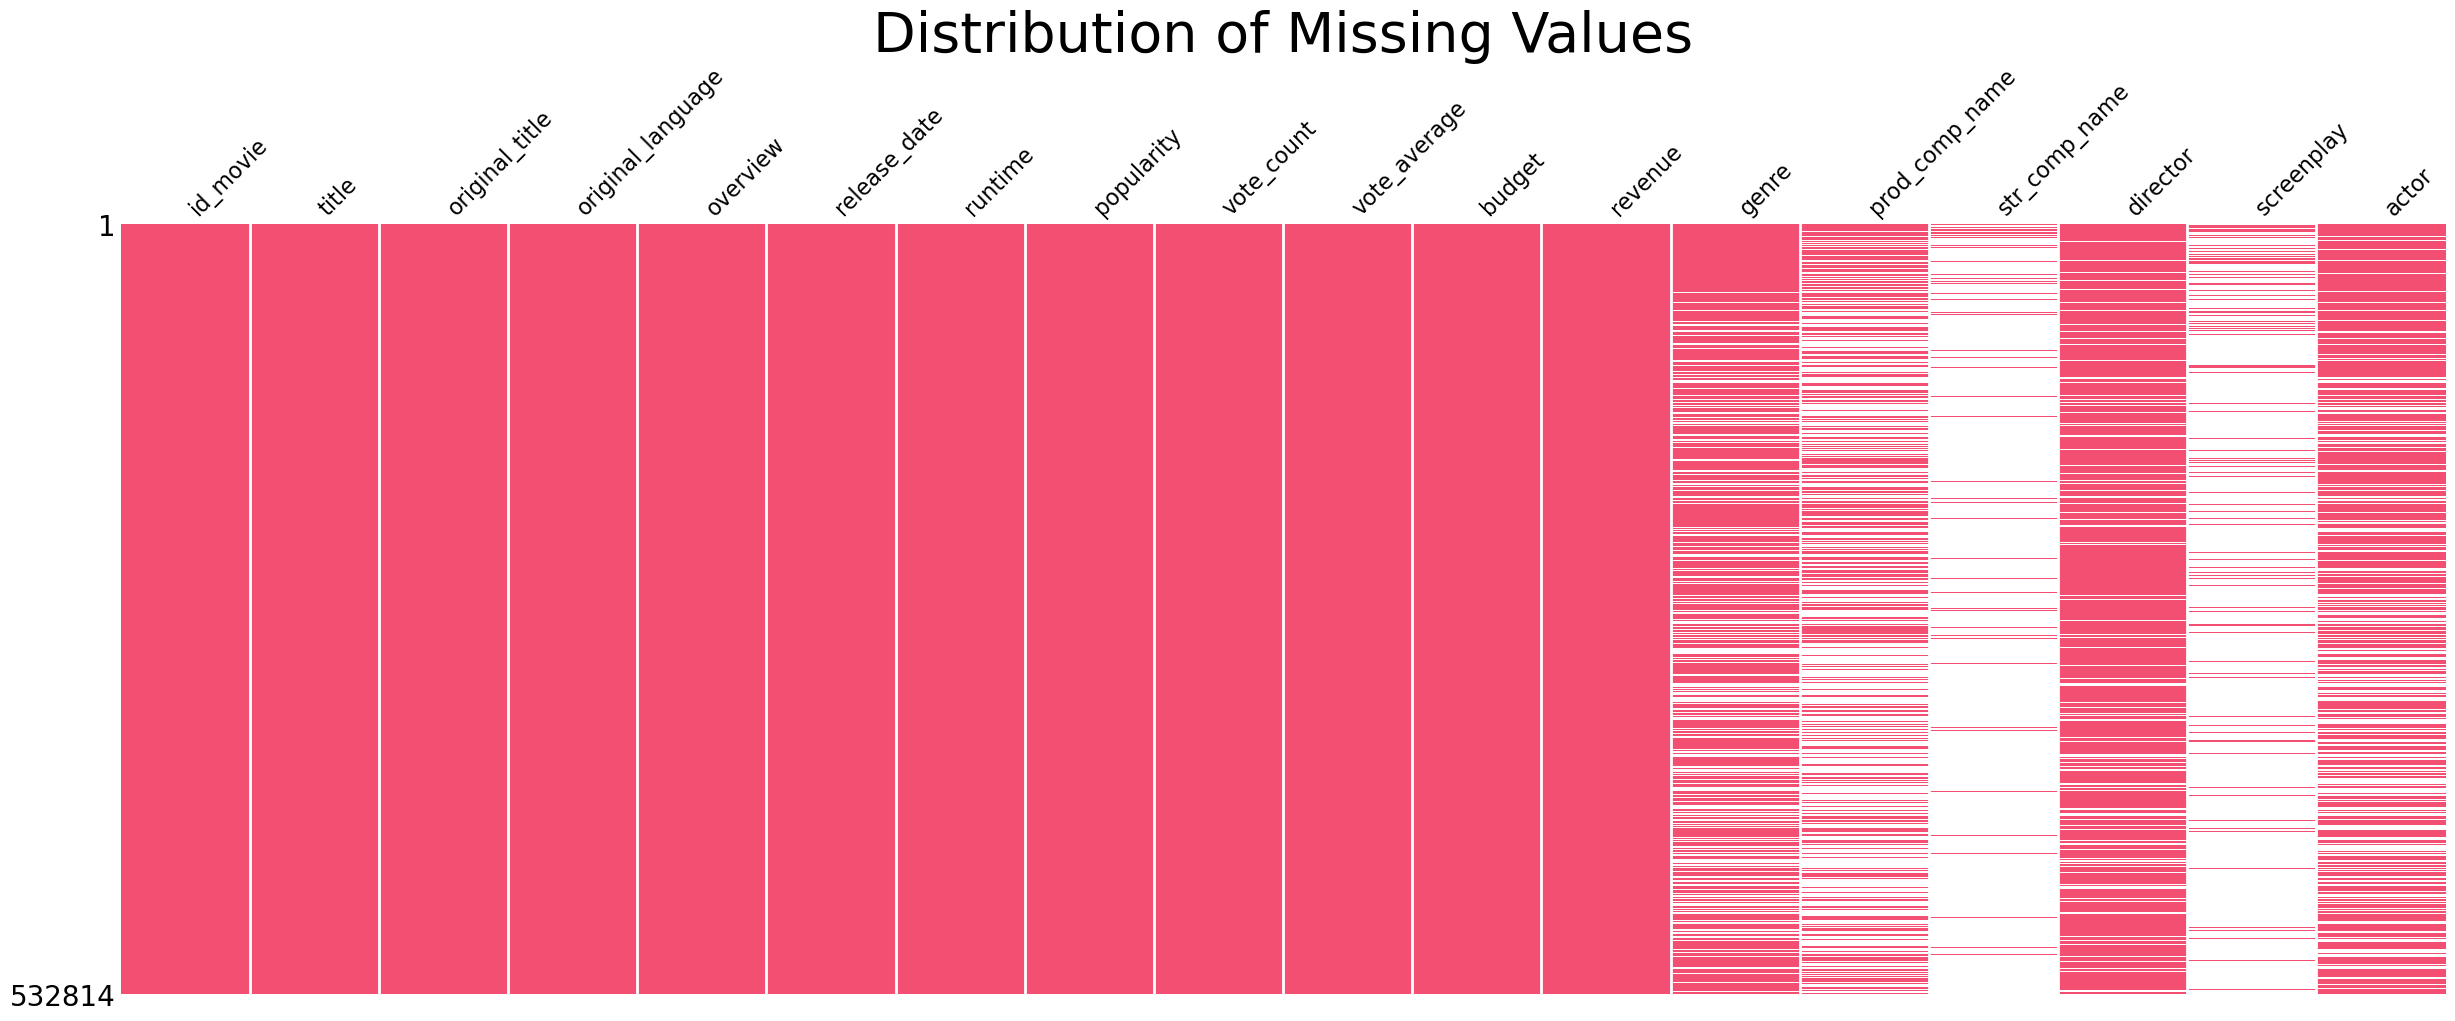

In [24]:
msno.matrix(movie_all, sparkline=False, figsize=(30,10), color=(0.95, 0.31, 0.45))
plt.title('Distribution of Missing Values', fontsize=40)

A significant number of missing values have been observed in the streaming_company and screenplay columns. After analyzing their correlation with the other data, a decision will be made regarding these columns.

Initially, the streaming_company column has been selected to analyze whether movies available to consumers through subscription-based streaming platforms (a business model that has grown in popularity in recent years) have an impact on their popularity. The screenplay column has been selected for the recommendation model. However, due to the high number of missing values, it is unlikely to be usable.

##### Zeros chart

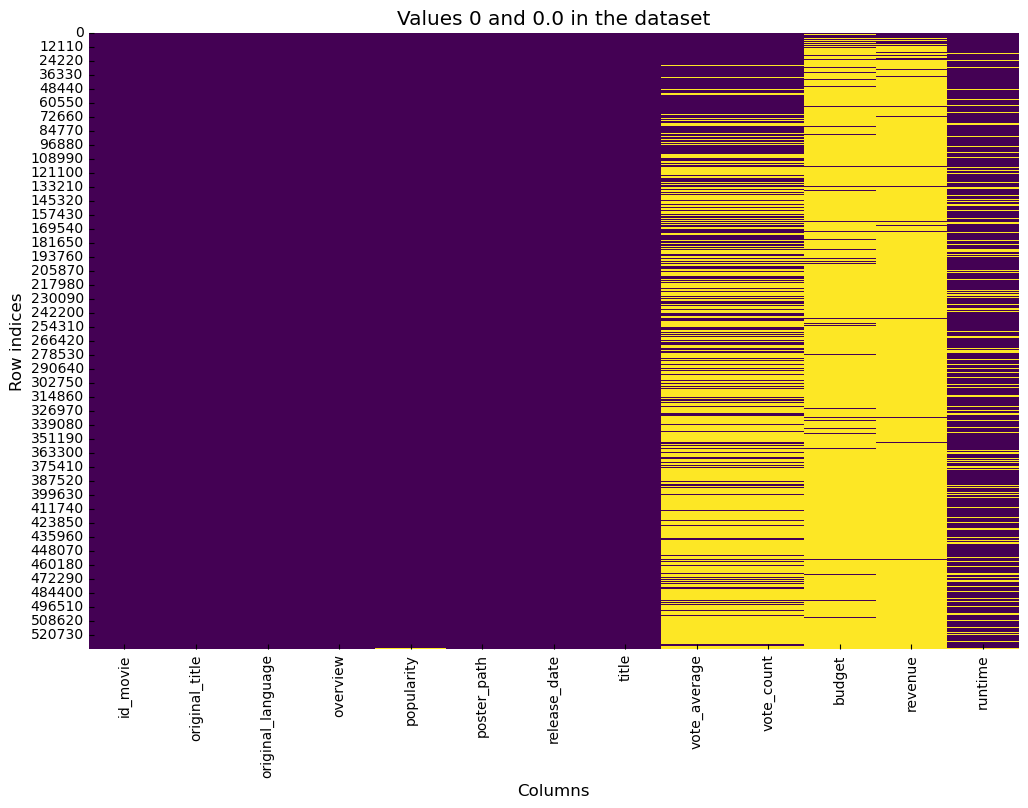

In [25]:
# Create a boolean mask for values equal to 0 or 0.0
mask = (df_movie == 0) | (df_movie == 0.0)

# Visualize the boolean mask using a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(mask, cbar=False, cmap='viridis')
plt.xlabel('Columns')
plt.ylabel('Row indices')
plt.title('Values 0 and 0.0 in the dataset')
plt.show()


The popularity metric in TMDb is based on several factors, including the number of user votes, the number of page views, the number of times it has been marked as a favorite, and the number of times it has been added to user lists. It is important to note that popularity is not necessarily an indication of a movie's quality but rather an indication of how much attention a movie has received on the TMDb platform.

The popularity column is a crucial metric in our analysis, and fortunately, it has very few missing values. Therefore, we will be using it as a dependent variable to analyze the other columns and their relationship with popularity.

Furthermore, it has been noted that the budget and revenue columns in the dataset have over 80% of zero values, which suggests that they may not be reliable indicators of a movie's financial success. In addition, the zeros in the vote_average and vote_count columns are closely related, with a movie having a vote_average of zero if no votes have been cast for it yet, due to a vote_count of zero. This underscores the importance of careful consideration when interpreting these columns in data analysis.

#### Numeric Variables

##### List of numeric columns

In [26]:
num_cols = [col for col in df_movie.columns if df_movie[col].dtype in ['int64', 'float64']and col not in ['id_movie', 'popularity']]

print(num_cols)

['vote_average', 'vote_count', 'budget', 'revenue', 'runtime']


In [27]:
num_cols2 = [col for col in df_movie.columns if df_movie[col].dtype in ['int64', 'float64']and col not in ['id_movie']]

print(num_cols2)

['popularity', 'vote_average', 'vote_count', 'budget', 'revenue', 'runtime']


##### Scatter plot

Shows the relationship between the popularity column and the other numeric columns. 
The goal is to visually explore whether there is any trend or correlation between the numeric features of movies and their popularity.

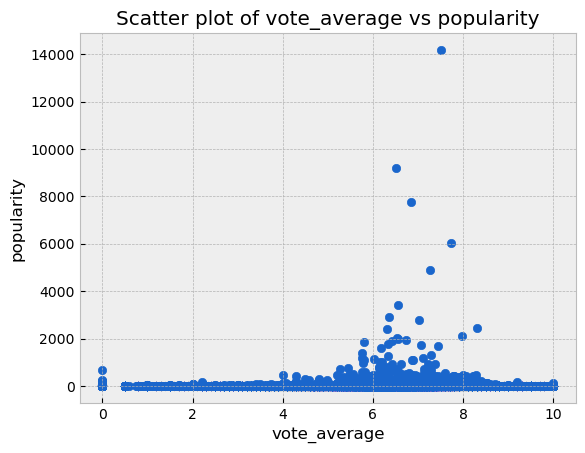

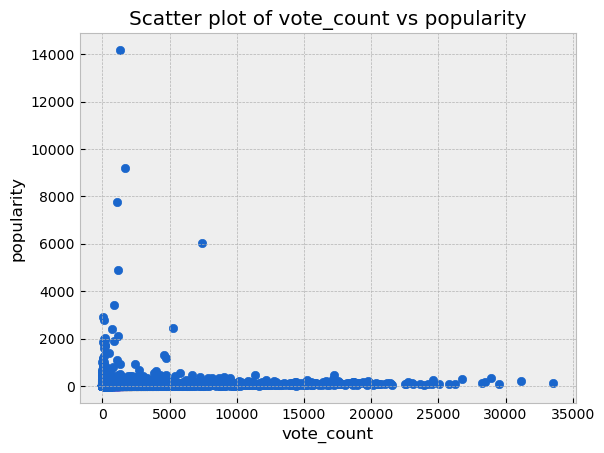

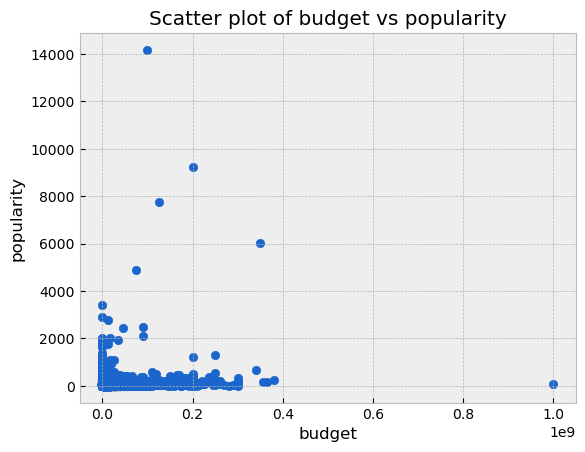

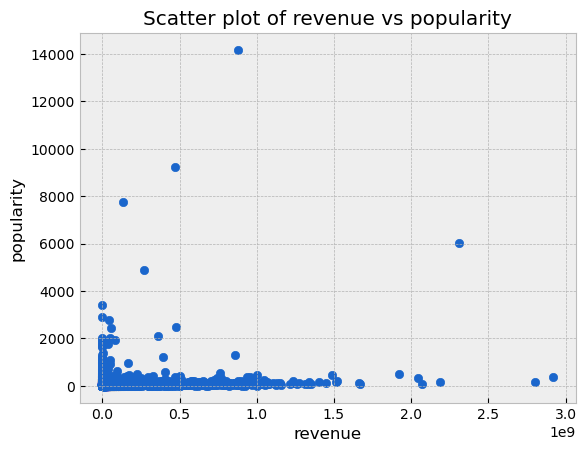

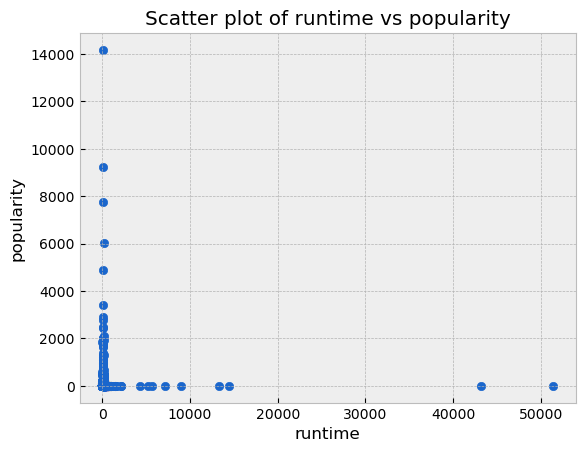

In [28]:
scatter_plot(df_movie, num_cols)

At first glance and with the raw data, we observe that the only column exhibiting a positive relationship with popularity is the vote average. All other columns are heavily influenced by a large number of missing values and outliers, making it difficult to discern any significant insights.

##### Frequency plot - create histogram

Histograms to see the distribution of the data in each numeric column. Shows the frequency of the data in intervals or "bins".

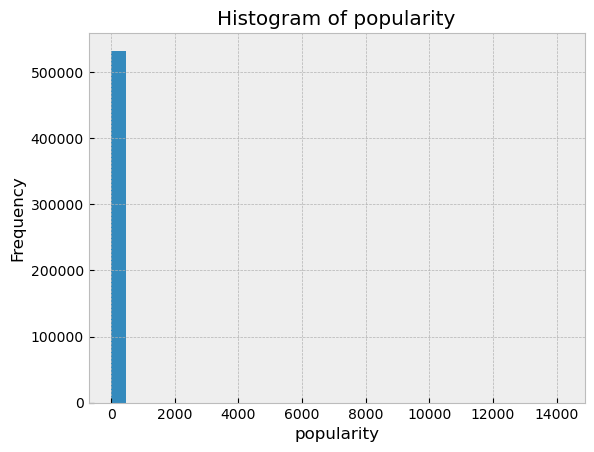

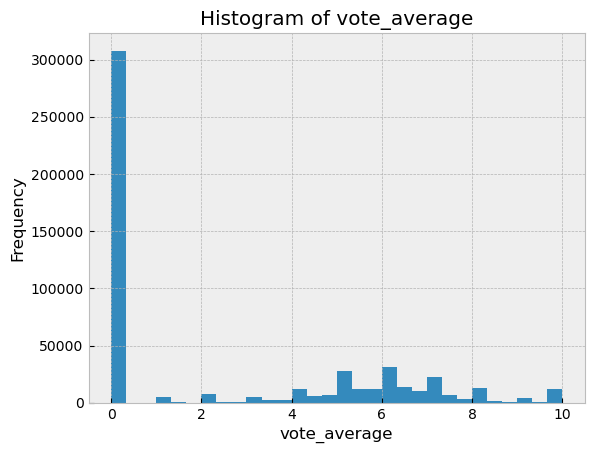

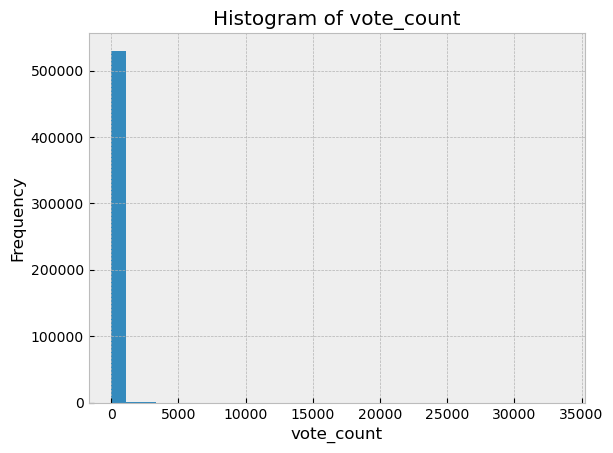

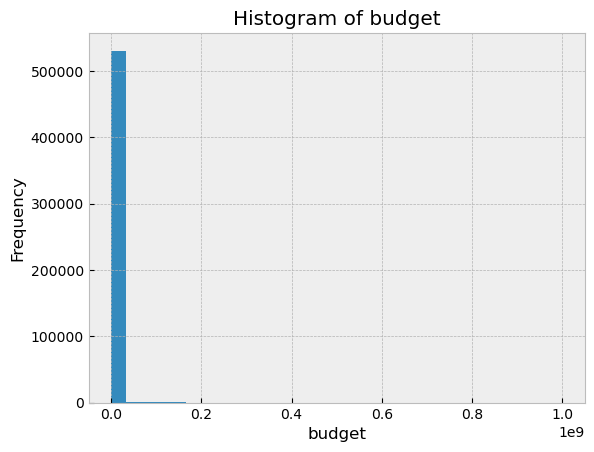

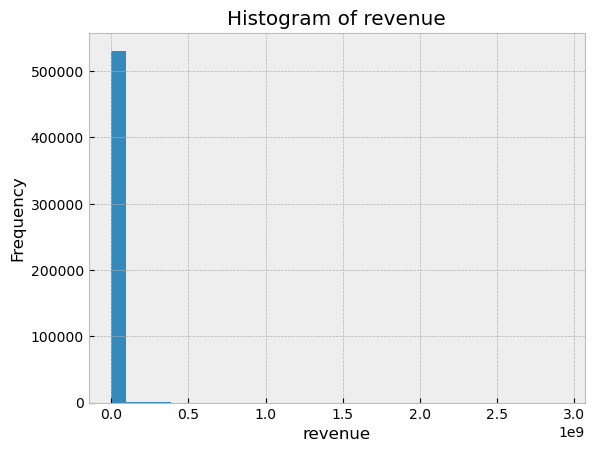

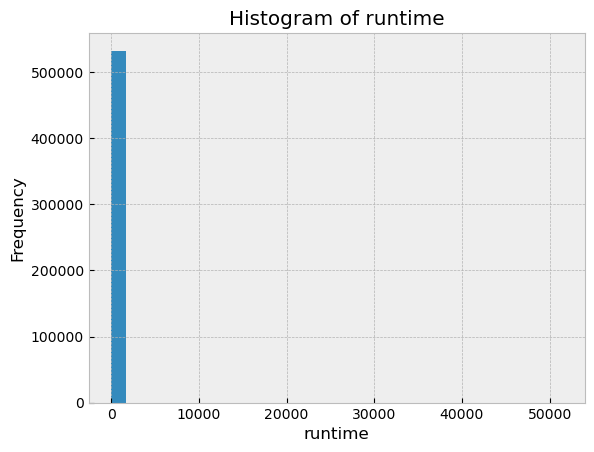

In [29]:
create_histograms(df_movie, num_cols2, bins=30)

After looking at the graphs, we can see that most of them have a tall column near zero, showing that the data is not evenly distributed. This happens because most of the values are close to zero, and only a few are much higher. These high values cause the rest of the data to appear squeezed together in the histograms, making it harder to understand the overall distribution and identify trends.

We decided to apply a logarithmic transformation to visualize the data because it helps to better handle and visualize skewed distributions, reducing the impact of extreme values or outliers. This makes it easier to identify patterns and trends in the data that may not be apparent with the raw values.

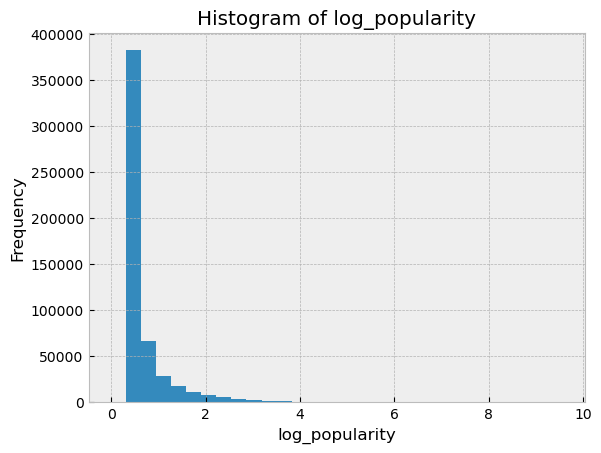

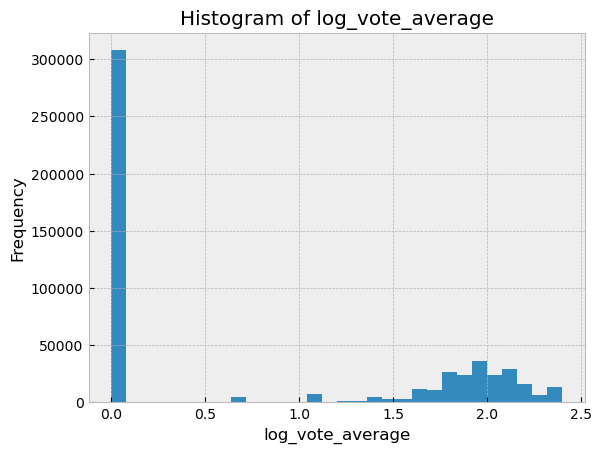

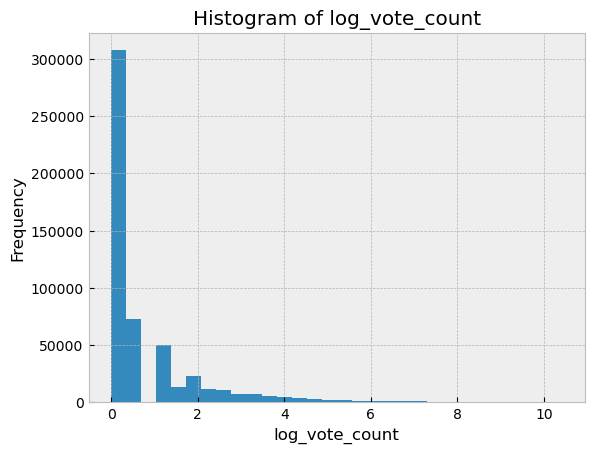

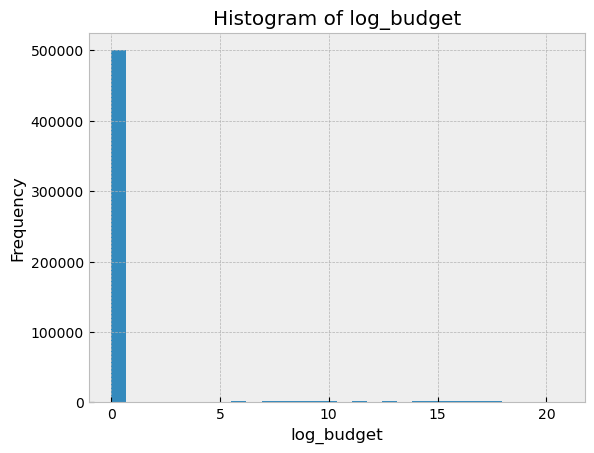

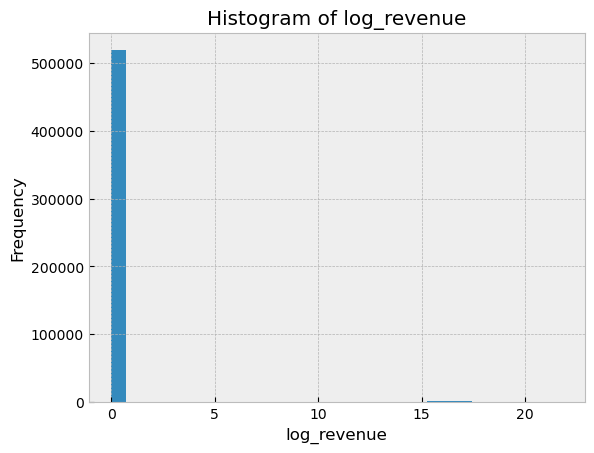

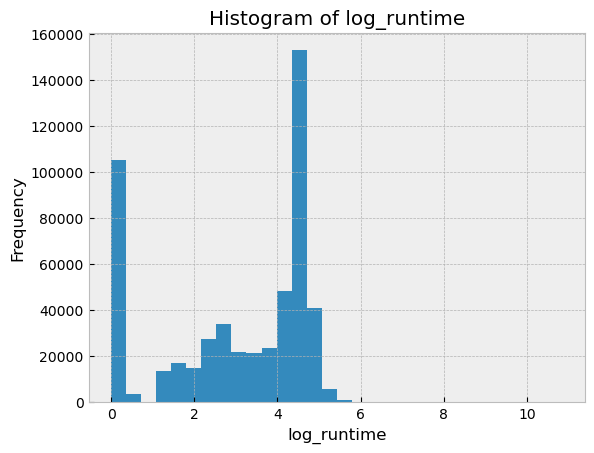

In [30]:
create_log_histograms(df_movie, num_cols2, bins=30)



We can now observe the data distribution more clearly using frequency histograms.

The majority of columns exhibit low values, resulting in left-skewed graphs (toward zero). Additionally, we can see that the 'vote_average' column, aside from the predominance of zeros, has its data mainly distributed between 4 and 8, with the most frequent score being around 6. Finally, we notice that the 'runtime' column shows a predominance of shorter films.

Moving forward, we will conduct a more exhaustive analysis on a column-by-column basis.

##### Box plot

Boxplots to visualize the distribution and outliers of a numerical variable

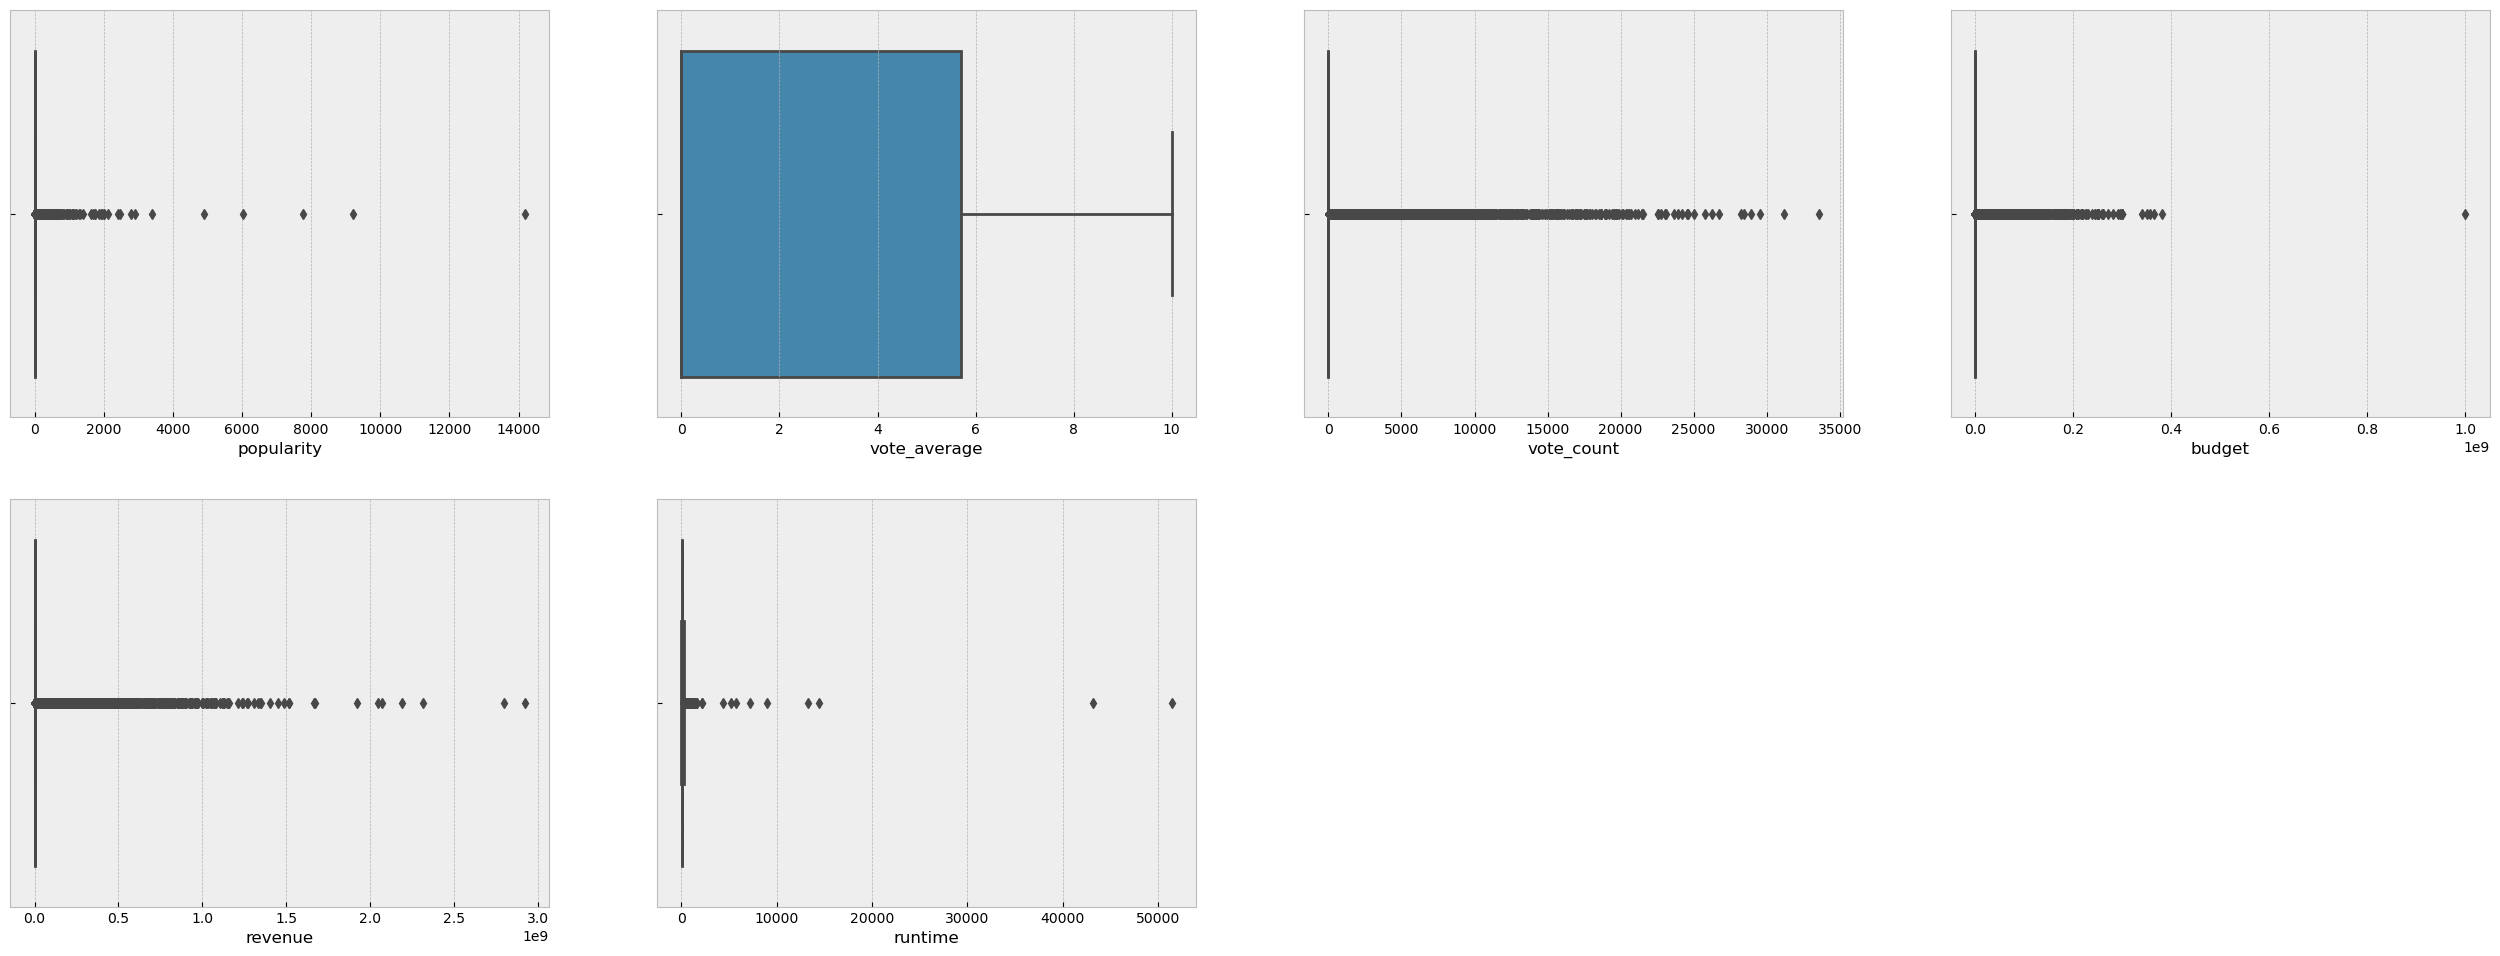

In [31]:
plot_boxplots(df_movie, num_cols2, figsize=(32, 18), ncols=4, nrows=3)

In the boxplots, we can clearly observe how the significant presence of zeros and outliers is affecting the visualization of the data.

##### Correlation plot

Heatmap to show the correlation between numeric variables in a correlation matrix.

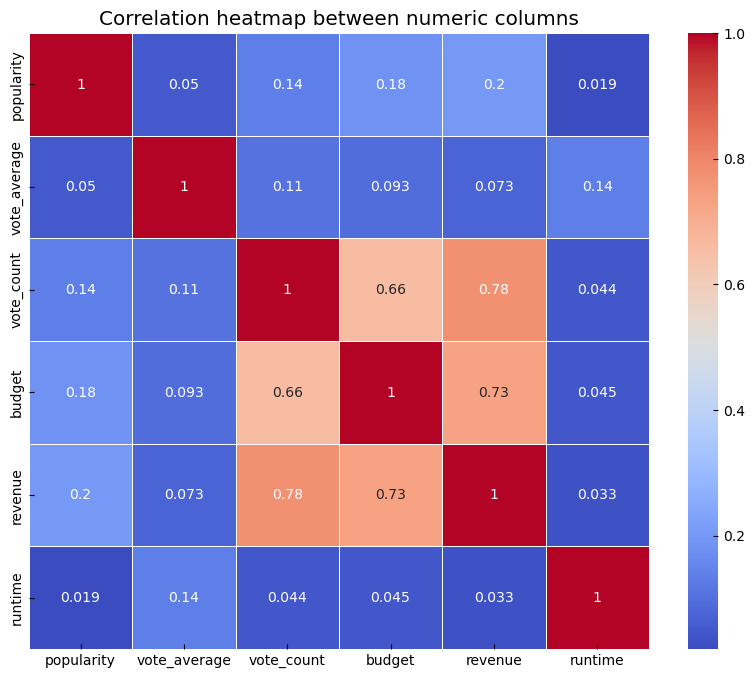

In [32]:
create_correlation_plot(df_movie, num_cols2)

In the heatmap, we observe the limited correlation between the popularity variable and the others. The highest correlation it has is with revenue at 0.2, followed by budget and vote_count. The low correlation with vote_average is surprising, indicating that the more popular a movie is, the lower its overall score tends to be.

The highest correlations in the graph show that movies with greater revenue tend to have more people voting, and consequently, they are also more popular.

#### Categorical Variables

Object type columns are transformed to categorical

In [33]:
only_obj = movie_all.select_dtypes(include=["object"])
only_numeric = movie_all.select_dtypes(include=["int64", "float64"])

for column_ in only_obj.columns:
    movie_all[column_] = pd.Categorical(movie_all[column_])
    
only_cat = movie_all.select_dtypes(include=["category"])

In [34]:
movie_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 532814 entries, 0 to 532813
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   id_movie           532814 non-null  int64   
 1   title              532814 non-null  category
 2   original_title     532814 non-null  category
 3   original_language  532814 non-null  category
 4   overview           532814 non-null  category
 5   release_date       532814 non-null  category
 6   runtime            532814 non-null  int64   
 7   popularity         532814 non-null  float64 
 8   vote_count         532814 non-null  int64   
 9   vote_average       532814 non-null  float64 
 10  budget             532814 non-null  int64   
 11  revenue            532814 non-null  int64   
 12  genre              391771 non-null  category
 13  prod_comp_name     234257 non-null  category
 14  str_comp_name      25790 non-null   category
 15  director           461074 non-null

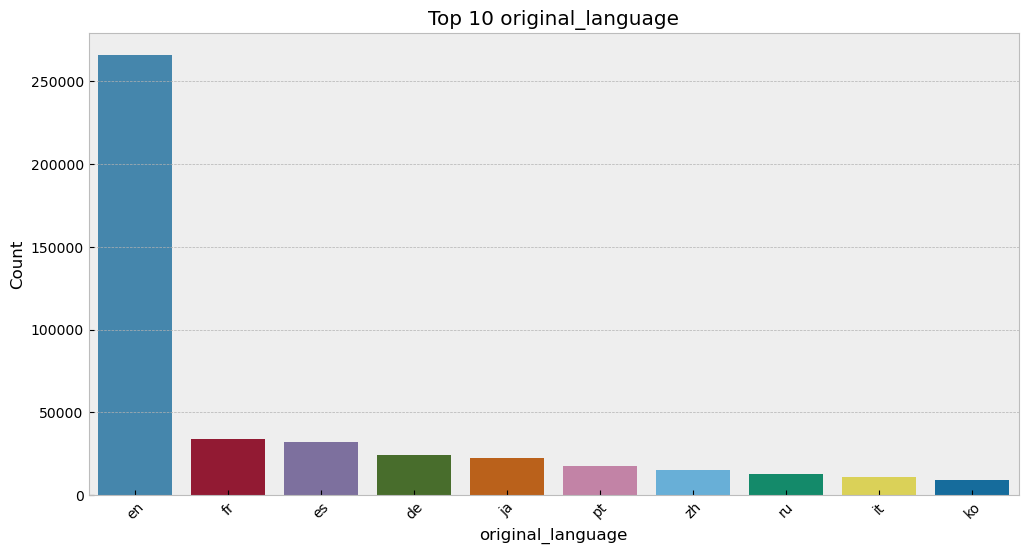

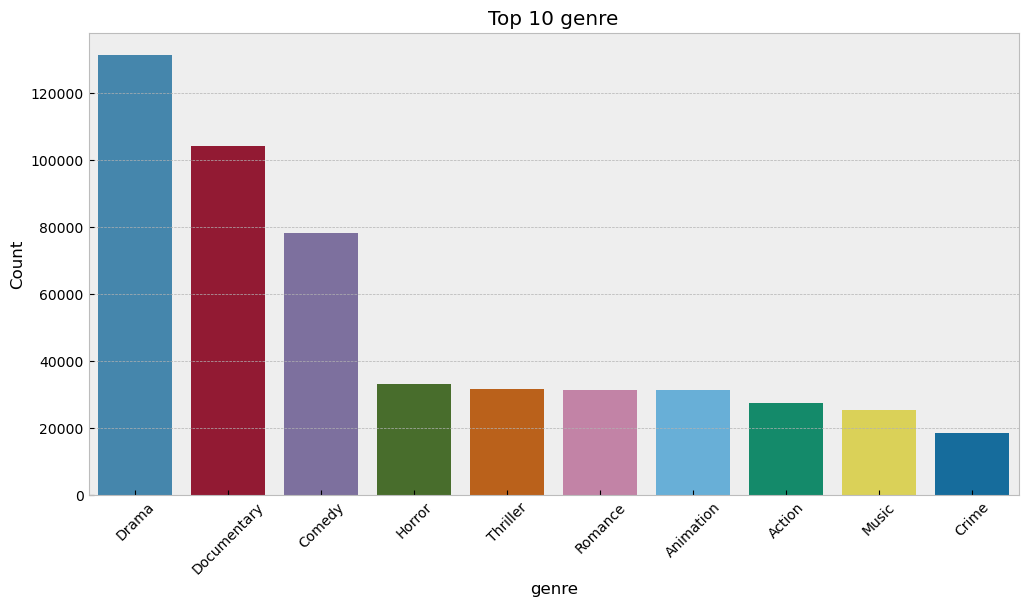

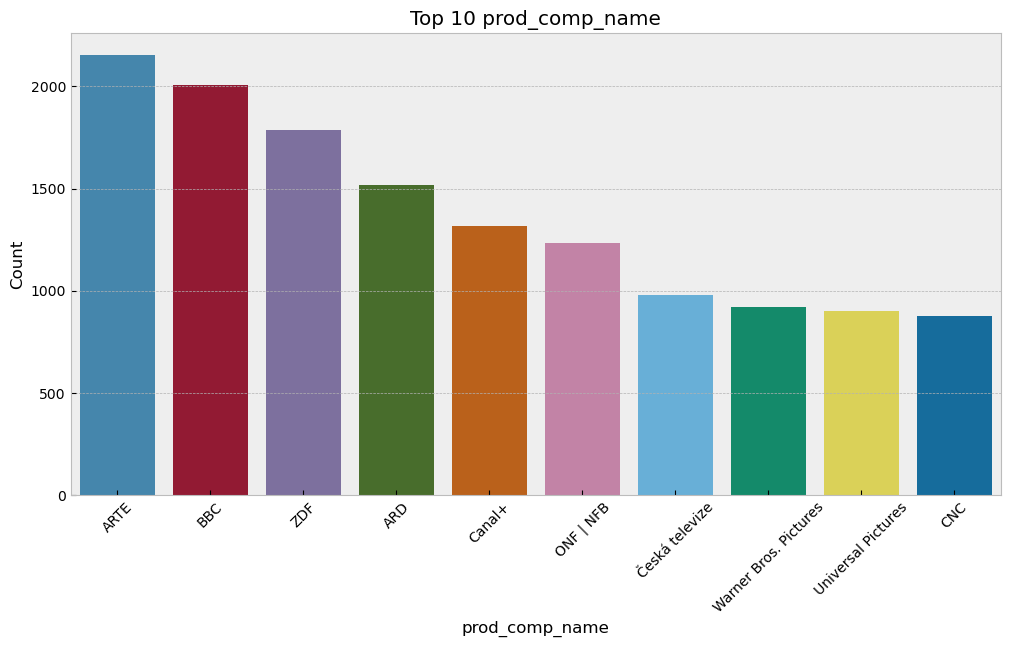

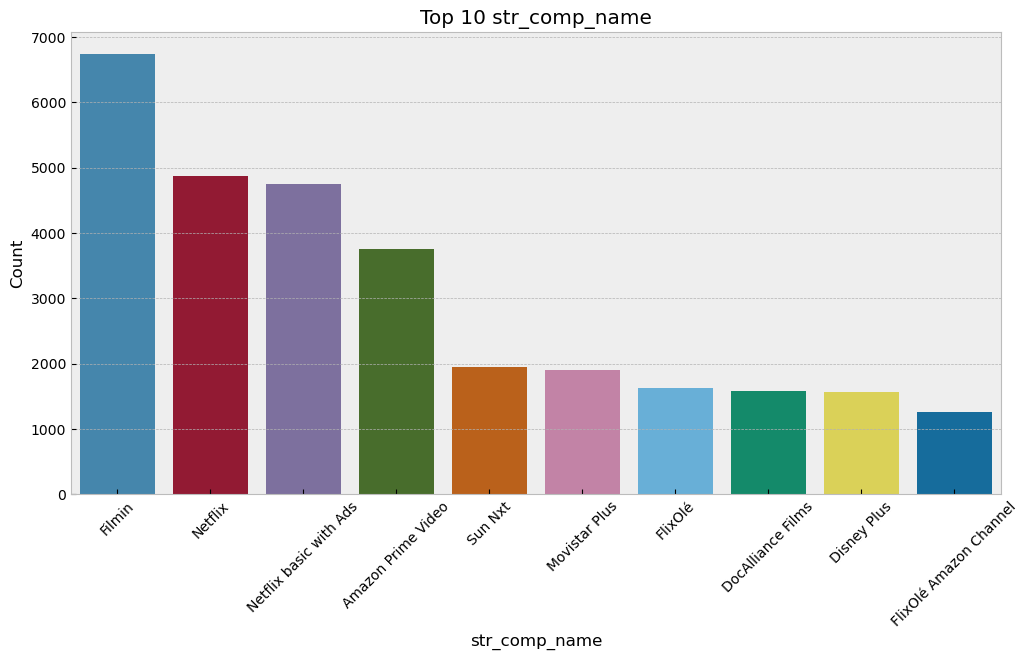

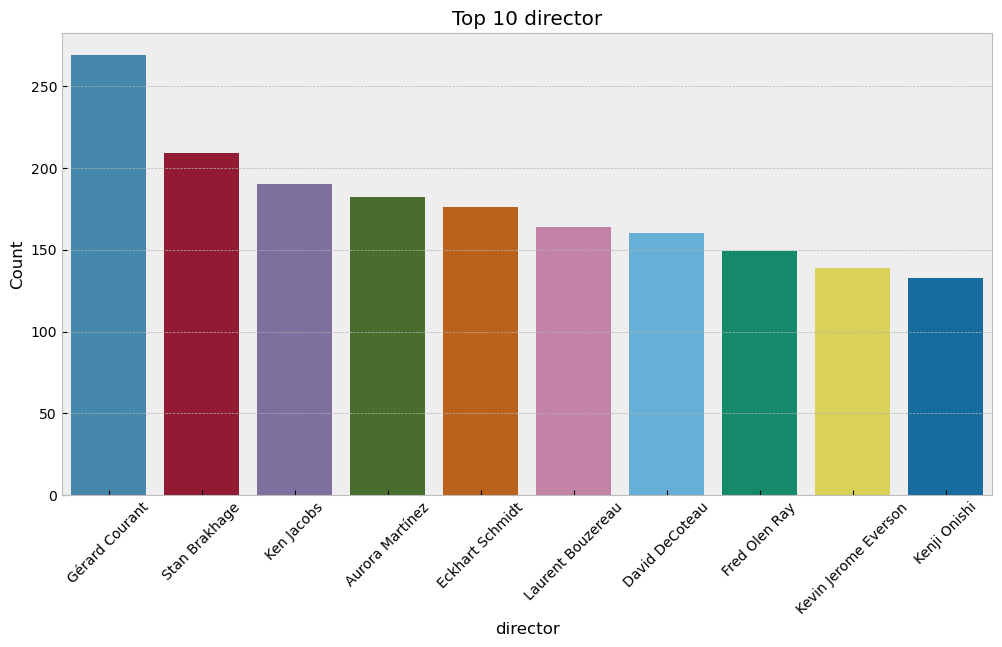

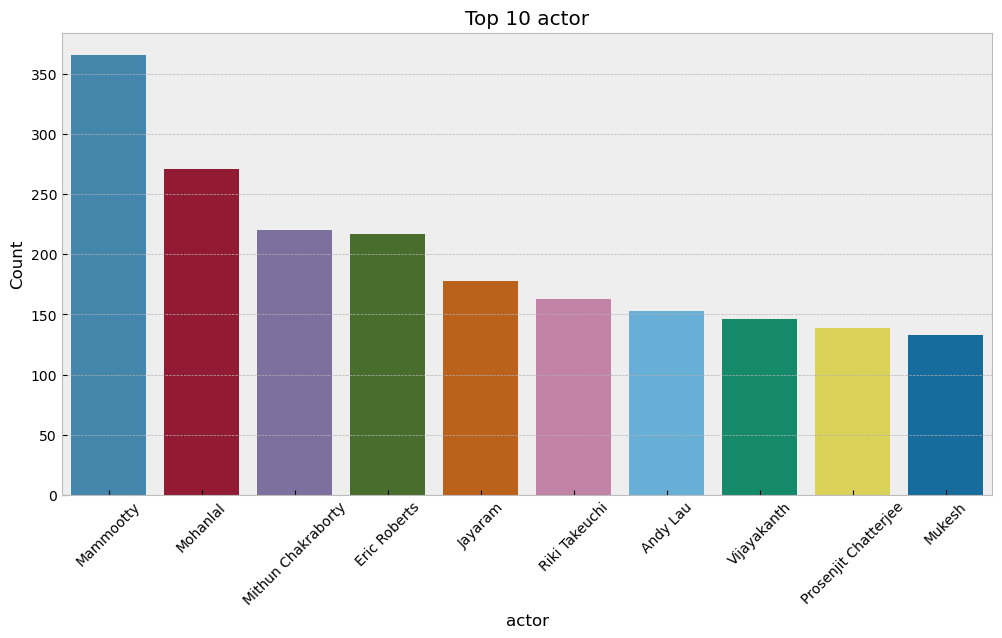

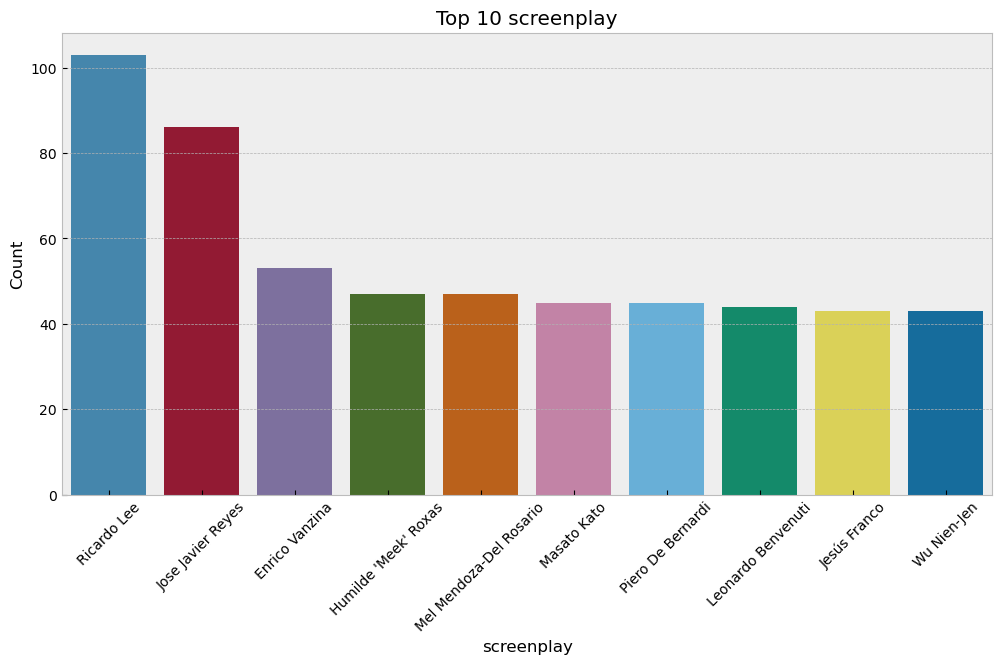

In [35]:
# Countplot for the 'original_language' column
countplot_column(movie_all, 'original_language')

# Countplot for the 'genre' column
countplot_column(movie_all, 'genre')

# Countplot for the 'prod_comp_name' column
countplot_column(movie_all, 'prod_comp_name')

# Countplot for the 'str_comp_name' column
countplot_column(movie_all, 'str_comp_name')

# Countplot for the 'director' column
countplot_column(movie_all, 'director')

# Countplot for the 'actor' column
countplot_column(movie_all, 'actor')

# Countplot for the 'screenplay' column
countplot_column(movie_all, 'screenplay')


**LANGUAGES**


en: English,
fr: French,
es: Spanish,
de: German,
ja: Japanese,
pt: Portuguese,
sh: Serbo-Croatian,
ru: Russian,
it: Italian,
ko: Korean,

**STREAMING COMPANIES**: For our analysis, we have selected the streaming companies in Spain, which show us the streaming company where each movie can be viewed in the country of Spain.

For the first exploratory analysis of the categorical data columns, we created bar charts displaying the frequency of the top 10 most common values in each column to gain better insight into the most relevant data.

We observed that the data distribution is skewed towards a large number of movies with English as their original language. While it is true that there are generally more English-language movies than movies in other languages, the imbalance in this dataset is significant. This could potentially impact users of this platform, as if the majority of movies are in English, we can assume the same is true for users, which in turn affects movie ratings and popularity.

Additionally, we observed that the predominant genres in this dataset are drama, documentary, and comedy. The most prominent streaming company in Spain is Filmin, which may be due to a significant number of short films in the dataset. Other streaming platforms with a large number of movies in Spain include Netflix and Amazon Prime.

In other graphics, we noted that the director with the most movies is Gerard Courant, a 71-year-old French filmmaker with over 250 movies to his credit. The actor with the most appearances is Mammootty, a 71-year-old Indian actor and filmmaker. Finally, the most frequent screenwriter in the dataset is Ricardo Lee, a 75-year-old Filipino screenwriter, journalist, novelist, and playwright.
 

### PREPROCESSING AND TRANSFORMATION

#### Functions

##### column_info function

The column_info function provides a concise overview of a given column in a DataFrame by returning a dictionary containing essential summary statistics. This includes the total number of values, the count of unique values, the number of missing and zero values, the percentage of zero values, and the range of values within the column. Utilizing this function offers valuable insights into the data distribution and quality within a specific column.

In [36]:
def column_info(column):
    """
    This function takes a Pandas Series (column) as input and returns a dictionary
    containing essential summary statistics about the column.

    Parameters:
    column: Pandas Series, the target column for analysis.
    """
    
    info = {}
    info['len'] = len(column)  # Total number of values in the column.
    print(f"Length of column: {info['len']}")
    
    info['unique'] = len(column.unique())  # Number of unique values in the column.
    print(f"Number of unique values: {info['unique']}")
    
    info['num_missing'] = column.isna().sum()  # Number of missing values (NaN) in the column.
    print(f"Number of missing values: {info['num_missing']}")
    
    info['num_zeros'] = ((column == 0) | (column == 0.0)).replace({True: 1, False: 0}).sum()  # Number of values equal to zero in the column.
    print(f"Number of zeros: {info['num_zeros']}")
    
    info['pct_zeros'] = round((info['num_zeros'] / info['len']) * 100, 2)  # Percentage of values equal to zero in the column.
    print(f"Percentage of zeros: {info['pct_zeros']}%")
    
    col_min = column.min()
    col_max = column.max()
    print(f"The range of values in the column is: {col_min} - {col_max}")

    return info


##### plot_column_counts function

The plot_column_counts function is designed to generate a bar plot visualizing the distribution of values within a specified column of a given DataFrame. The function takes two parameters: the name of the target column (column_name) and the DataFrame containing the column (df). By displaying the frequency of each unique value in the column, this function aids in understanding the underlying patterns and trends in the data.

In [37]:
def plot_column_counts(column_name, df):
    """
    Creates a bar plot of the distribution of values in the specified column.

    Parameters:
    column_name (str): The name of the column to plot.
    df (DataFrame): The DataFrame containing the column.

    Returns:
    None
    """
    # Get the distribution of values in the specified column
    column_counts = df[column_name].value_counts().sort_index()


    # Create the bar plot
    column_counts.plot(kind='bar', figsize=(10,6))

    # Add labels and title
    plt.xlabel(column_name)
    plt.ylabel('Frequency')
    plt.title(f'Distribution of {column_name}')

    # Show the plot
    plt.show()



##### bar_plot function

The bar_plot function creates a bar plot for a given DataFrame column. It takes in the DataFrame, the name of the column to plot, and two optional parameters: the title of the plot and the number of top values to display. If the title is provided, it will be displayed above the plot. If top_n is provided, the function will display the top n largest values in the plot. The function handles both categorical and numerical data.

In [38]:
def bar_plot(df, x_col, title=None, top_n=None):
    """
    Creates a bar plot for the specified DataFrame column.

    Parameters:
    df: DataFrame, the input DataFrame
    x_col: str, the column name to plot
    title: str, optional, the title of the plot
    top_n: int, optional, the number of top values to display for categorical columns

    Returns:
    None
    """

    # Create the plot with the specified size
    plt.figure(figsize=(12, 6))

    # Plot the top_n largest values if top_n is provided and column is categorical
    if top_n and pd.api.types.is_categorical_dtype(df[x_col]):
        data_to_plot = df[x_col].value_counts().nlargest(top_n)
        sns.barplot(x=data_to_plot.index, y=data_to_plot.values)
        plt.xticks(rotation=45)
    # Otherwise, plot all unique values
    else:
        if pd.api.types.is_numeric_dtype(df[x_col]) and not pd.api.types.is_categorical_dtype(df[x_col]):
            order = sorted(df[x_col].unique())
        else:
            order = df[x_col].value_counts().index
        sns.countplot(data=df, x=x_col, order=order)

    # Set the x and y axis labels
    plt.xlabel(x_col)
    plt.ylabel('Count')

    # Set the plot title if provided
    if title is not None:
        plt.title(title)

    # Show the plot
    plt.show()





##### boxplot_analysis function

The boxplot_analysis function performs an in-depth examination of a given column's distribution by generating a boxplot and providing summary statistics, including the interquartile range and outlier information. This analysis helps to identify underlying patterns and trends in the data, as well as potential data quality issues.

In [39]:
def boxplot_analysis(column):
    """
    This function takes a Pandas Series (column) as input and generates a boxplot 
    visualizing its distribution. It also provides summary statistics and outlier 
    information for the column.

    Parameters:
    column: Pandas Series, the target column for analysis.

    Returns:
    None
    """

    # Count number of zeros in the column
    num_zeros = len(column[column == 0])

    # Calculate quartiles and interquartile range
    q1, q3 = np.percentile(column.dropna(), [25, 75])
    iqr = q3 - q1

    # Calculate limits to detect outliers
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    # Calculate outliers
    outliers = column[(column < lower_bound) | (column > upper_bound)]

    # Calculate percentage of outliers, zeros, and missing values
    percentage_outliers = len(outliers) / len(column) * 100
    percentage_zeros = num_zeros / len(column) * 100
    percentage_missing = column.isna().sum() / len(column) * 100

    # Print statistics
    print('Data description:')
    print(column.describe())
    print('Number of zeros:', num_zeros)
    print('Percentage of zeros:', round(percentage_zeros, 2), '%')
    print('Interquartile range:', iqr)
    print('Lower bound:', lower_bound)
    print('Upper bound:', upper_bound)
    print('Number of outliers:', len(outliers))
    print('Percentage of outliers:', round(percentage_outliers, 2), '%')
    print('Percentage of missing values:', round(percentage_missing, 2), '%')

    # Create the boxplot
    fig, ax = plt.subplots(figsize=(10, 5))
    sns.boxplot(x=column, ax=ax)

    # Add labels and title to the boxplot
    plt.xlabel(column.name)
    plt.title(f'Boxplot of {column.name}')

    plt.show()



##### bar_plot_simple function

The bar_plot_simple function creates a simple bar plot for the specified x_col column of the input DataFrame df. The function counts the occurrences of each unique value in the column and then creates a bar plot displaying the counts. The bars are ordered based on the sorted unique values of the column. An optional title for the plot can be provided with the title parameter.

In [40]:
def bar_plot_simple(df, x_col, title=None):
    """
    Generates a simple bar plot for the given column.

    Parameters:
    df (pd.DataFrame): Input DataFrame containing the data to analyze.
    x_col (str): Column name for which the bar plot is to be created.
    title (str, optional): Title for the bar plot, default is None.

    Returns:
    None
    """
    plt.figure(figsize=(12, 6))
    sns.countplot(data=df, x=x_col, order=sorted(df[x_col].unique()))
    plt.xlabel(x_col)
    plt.ylabel('Count')

    if title is not None:
        plt.title(title)

    plt.show()


##### bar_plot_top_categories function

The bar_plot_top_categories function creates a bar plot for the top top_n most frequent categories in the specified x_col column of the input DataFrame df. The function counts the occurrences of each category in the column and then creates a bar plot displaying the counts for the top top_n categories.

In [41]:
def bar_plot_top_categories(df, x_col, top_n=20):
    """
    Generates a bar plot for the top most frequent categories in the given column.

    Parameters:
    df (pd.DataFrame): Input DataFrame containing the data to analyze.
    x_col (str): Column name for which the bar plot is to be created.
    top_n (int, optional): Number of top most frequent categories to display, default is 20.

    Returns:
    None
    """
    plt.figure(figsize=(12, 6))
    top_n_categories = df[x_col].value_counts().iloc[:top_n].index
    sns.countplot(data=df, x=x_col, order=top_n_categories)
    plt.xlabel(x_col)
    plt.ylabel('Count')
    plt.show()


##### scatter_plot function

The scatter_plot function creates a scatter plot for the specified x_col and y_col columns of the input DataFrame df. The function plots the data points for the given columns against each other and then labels the axes and sets the title. The plot is then displayed.

In [42]:
def scatter_plot(df, x_col, y_col):
    """
    Generates a scatter plot for the given x and y columns.

    Parameters:
    df (pd.DataFrame): Input DataFrame containing the data to plot.
    x_col (str): Column name for the x-axis.
    y_col (str): Column name for the y-axis.

    Returns:
    None
    """
    plt.figure()
    plt.scatter(df[x_col], df[y_col])
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.title(f'Scatter plot of {x_col} vs {y_col}')
    plt.show()


##### stacked_bar_plot function

When both variables are categorical, we can use a heatmap to display the relationship between them. First, we need to create a contingency table to show the frequency of each combination of categories.

In [43]:
def create_contingency_table(df, x_col, y_col):
    contingency_table = pd.crosstab(df[x_col], df[y_col])
    return contingency_table

We normalize the contingency tables so that each row sums up to 1.

In [44]:
def normalize_contingency_table(contingency_table):
    return contingency_table.div(contingency_table.sum(axis=1), axis=0)

The stacked_bar_plot function creates a stacked bar plot using the data in the input normalized_contingency_table, which should be a pandas DataFrame. The bars represent the proportions of each category in the y_label column, stacked according to the categories in the x_label column. The function then labels the axes, sets the legend title and position, and displays the plot.

In [45]:
def stacked_bar_plot(normalized_contingency_table, x_label, y_label):
    """
    Generates a stacked bar plot using the data in the input normalized contingency table.

    Parameters:
    normalized_contingency_table (pd.DataFrame): Input DataFrame containing the data to plot.
    x_label (str): Label for the x-axis.
    y_label (str): Label for the y-axis and legend title.

    Returns:
    None
    """
    plt.figure()
    ax = normalized_contingency_table.plot.bar(stacked=True, colormap='viridis', figsize=(10, 6))
    plt.xlabel(x_label)
    plt.ylabel('Proportion')
    plt.legend(title=y_label, loc='upper left', bbox_to_anchor=(1.05, 1))
    plt.show()


#### Numeric Columns

##### popularity Column

###### Overview

In [46]:
movie_all['popularity'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 532814 entries, 0 to 532813
Series name: popularity
Non-Null Count   Dtype  
--------------   -----  
532814 non-null  float64
dtypes: float64(1)
memory usage: 4.1 MB


In [47]:
popularity_info = column_info(movie_all['popularity'])
print(popularity_info)

Length of column: 532814
Number of unique values: 19522
Number of missing values: 0
Number of zeros: 28
Percentage of zeros: 0.01%
The range of values in the column is: 0.0 - 14176.7
{'len': 532814, 'unique': 19522, 'num_missing': 0, 'num_zeros': 28, 'pct_zeros': 0.01}


######  Zero Values

In [48]:
# Filter rows with popularity equal to zero
zero_popularity = movie_all.loc[movie_all['popularity'] == 0]

# Select specific columns
df_popularity_zeros = zero_popularity.loc[:, ['id_movie', 'original_title', 'original_language', 'vote_average', 'vote_count', 'runtime']]

# Print the new DataFrame with selected columns
print(df_popularity_zeros.to_string(index=False))

 id_movie                                       original_title original_language  vote_average  vote_count  runtime
  1116831                                             Ice Cold                en           0.0           0       26
  1116833                                        Health Hazard                en           0.0           0        4
  1116893                             S vůní mastixu a vanilky                cs           8.0           1        0
  1116895                                              Asosyal                tr           0.0           0        7
  1117046                                            CrossSnow                no           6.0           1        7
  1117060                                           Potyatusok                hu           0.0           0       94
  1117065                                         许茂和他的女儿们 北影版                zh           0.0           0        0
  1117069                                       Kraina Złudzeń          

It can be observed that among the 28 rows with a zero value in popularity, signifying no user interaction on the website, the majority are short films with no votes or ratings. Nevertheless, there are 3 movies that received a single vote and have ratings of 8, 6, and 9, respectively. This observation aligns with the earlier analysis of the correlation graph, wherein movies with a lower number of votes, and thus less popularity, were found to have higher ratings.

Henceforth, the dataframe will be divided into two distinct datasets. The original dataset will encompass the zero values, missing values, and outliers, whereas the clean dataset will exclude these elements.

In [49]:
movie_all['popularity'] = movie_all['popularity'].replace(0, np.nan) # Replace 0 with NaN
movie_all_original = movie_all[movie_all['popularity'].isna()] # Dataframe with rows that contain NaN
movie_all_clean = movie_all.dropna(subset=['popularity']) # Dataframe without rows that contain NaN

In [50]:
popularity_info = column_info(movie_all_clean['popularity'])
print(popularity_info)

Length of column: 532786
Number of unique values: 19521
Number of missing values: 0
Number of zeros: 0
Percentage of zeros: 0.0%
The range of values in the column is: 0.6 - 14176.7
{'len': 532786, 'unique': 19521, 'num_missing': 0, 'num_zeros': 0, 'pct_zeros': 0.0}


###### Outlayers

Data description:
count    532786.000000
mean          2.043138
std          32.011843
min           0.600000
25%           0.600000
50%           0.600000
75%           1.058000
max       14176.700000
Name: popularity, dtype: float64
Number of zeros: 0
Percentage of zeros: 0.0 %
Interquartile range: 0.4580000000000001
Lower bound: -0.08700000000000008
Upper bound: 1.745
Number of outliers: 77619
Percentage of outliers: 14.57 %
Percentage of missing values: 0.0 %


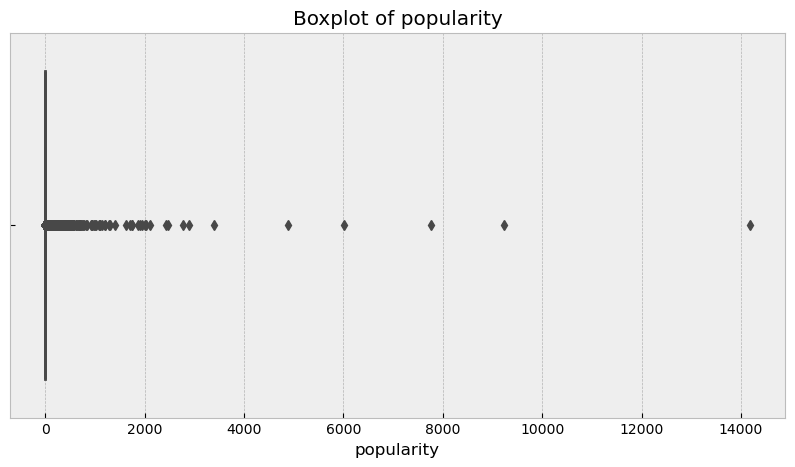

In [51]:
boxplot_analysis(movie_all_clean['popularity'])

- The majority of values are concentrated around the lower end of the range, with a median popularity of 0.6 and a mean of 2.04.

- The variable exhibits a high standard deviation of 32.01, indicating a significant dispersion of values.

- The interquartile range (IQR) is 0.458, which is relatively small compared to the overall range of values, suggesting that the central 50% of the data is closely clustered.

- A considerable number of outliers are present, accounting for 14.57% of the dataset. These outliers might be attributed to exceptionally popular movies or other factors.

- There are no missing values in the dataset, ensuring a complete analysis of the popularity variable.

In summary, the "popularity" variable exhibits a skewed distribution, with a high concentration of low values and a significant number of outliers. The complete dataset allows for a comprehensive understanding of the popularity patterns in the analyzed movies.

###### Binning proces

In order to address the issue of outliers in the popularity column, we have decided to implement a process of binning or discretization. This process involves grouping the data into smaller, more manageable ranges or categories, rather than simply removing the outliers altogether. We believe that all the information in this column is important and that one of the main objectives of data analysis is to visualize and understand the data as fully as possible.

The advantages of binning include simplifying complex data sets and making them more manageable, reducing the impact of outliers on statistical analysis, and potentially highlighting patterns or trends in the data that might otherwise be obscured. However, there are also some disadvantages to consider. Binning can result in the loss of precision and may not accurately represent the true distribution of the data. Additionally, the choice of bin size or category can be subjective and may affect the conclusions drawn from the analysis.

Overall, we have decided to proceed with binning as a way to address the outliers in the popularity column while retaining all the data for further analysis. We will create a new column with the binned data and leave the original data in the popularity column.

In [52]:
num_categories = 10
percentiles = [np.percentile(movie_all_clean['popularity'], i) for i in range(0, 101, 10)]

In [53]:
unique_percentiles = sorted(list(set(percentiles)))

movie_all_clean['popularity_binned'] = pd.cut(movie_all_clean['popularity'], bins=unique_percentiles, include_lowest=True)


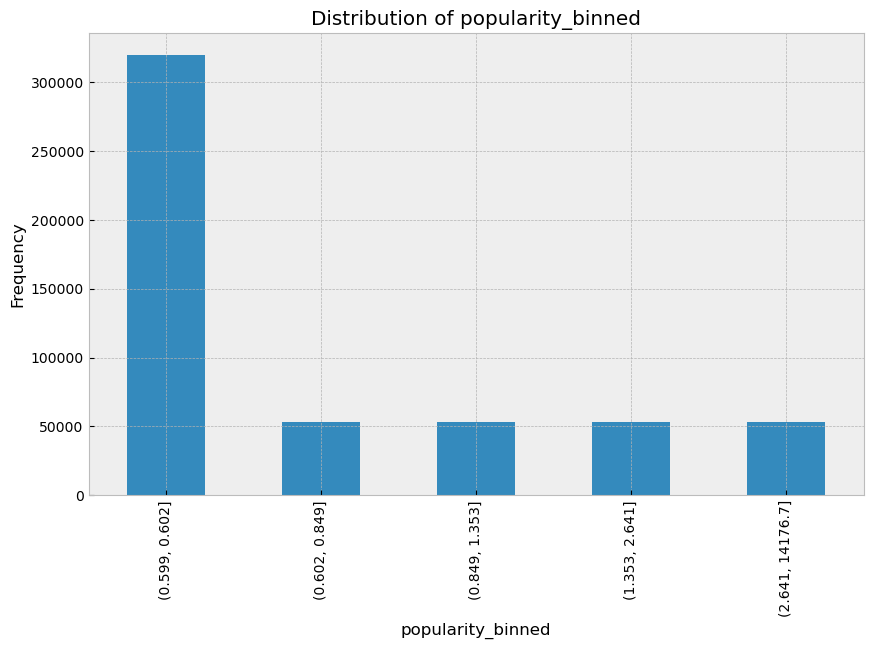

In [54]:
plot_column_counts('popularity_binned', movie_all_clean)

In this graph, we can more clearly observe the overwhelming predominance of movies with very low popularity. The difference is quite significant and will greatly influence the data analysis. In contrast, the other four categories exhibit a relatively similar volume of data.

In [55]:
popularity_info = column_info( movie_all_clean['popularity_binned'])
print(popularity_info)

Length of column: 532786
Number of unique values: 5
Number of missing values: 0
Number of zeros: 0
Percentage of zeros: 0.0%
The range of values in the column is: (0.599, 0.602] - (2.641, 14176.7]
{'len': 532786, 'unique': 5, 'num_missing': 0, 'num_zeros': 0, 'pct_zeros': 0.0}


###### Analysis of results

In [56]:
# Get the count and percentage of movies in the (2.641, 14176.7] category
popularity_category = movie_all_clean[movie_all_clean['popularity_binned'] == pd.Interval(2.641, 14176.7)]
popularity_count = popularity_category.shape[0]
popularity_percent = popularity_count / movie_all_clean.shape[0] * 100

print(f"The number of movies in the (2.641, 14176.7] category is {popularity_count}, which represents {popularity_percent:.2f}% of the total popularity values.")


The number of movies in the (2.641, 14176.7] category is 53279, which represents 10.00% of the total popularity values.


In [57]:
# Get the count and percentage of movies in the (0.599, 0.602] category
popularity_category = movie_all_clean[movie_all_clean['popularity_binned'] == pd.Interval(0.599, 0.602)]
popularity_count = popularity_category.shape[0]
popularity_percent = popularity_count / movie_all_clean.shape[0] * 100

print(f"The number of movies in the (0.599, 0.602] category is {popularity_count}, which represents {popularity_percent:.2f}% of the total popularity values.")


The number of movies in the (0.599, 0.602] category is 319832, which represents 60.03% of the total popularity values.


We removed 60% of the values from the DataFrame, which correspond to those in the popularity category of (0.599, 0.602], in order to conduct a more accurate analysis. However, we retain all values in the movie_all_clean DataFrame for further analysis and comparison.


Later on, we will continue analyzing the categories within the popularity column, once we have the other data cleaned and categorized.

In [58]:
# Filter out rows with 'popularity_binned' in the specified range
movie_all_clean_model = movie_all_clean[movie_all_clean['popularity_binned'] != pd.Interval(0.599, 0.602)]

# Update the 'popularity_binned' column by removing the specified category
movie_all_clean_model['popularity_binned'] = movie_all_clean_model['popularity_binned'].cat.remove_categories([pd.Interval(0.599, 0.602)])


In [59]:
movie_all_clean_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 212954 entries, 0 to 532785
Data columns (total 19 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   id_movie           212954 non-null  int64   
 1   title              212954 non-null  category
 2   original_title     212954 non-null  category
 3   original_language  212954 non-null  category
 4   overview           212954 non-null  category
 5   release_date       212954 non-null  category
 6   runtime            212954 non-null  int64   
 7   popularity         212954 non-null  float64 
 8   vote_count         212954 non-null  int64   
 9   vote_average       212954 non-null  float64 
 10  budget             212954 non-null  int64   
 11  revenue            212954 non-null  int64   
 12  genre              189801 non-null  category
 13  prod_comp_name     133812 non-null  category
 14  str_comp_name      21414 non-null   category
 15  director           199259 non-null

##### vote_average column 

###### Overview

In [60]:
movie_all_clean['vote_average'].info()

<class 'pandas.core.series.Series'>
Int64Index: 532786 entries, 0 to 532798
Series name: vote_average
Non-Null Count   Dtype  
--------------   -----  
532786 non-null  float64
dtypes: float64(1)
memory usage: 8.1 MB


In [61]:
movie_all_clean_model['vote_average'].info()

<class 'pandas.core.series.Series'>
Int64Index: 212954 entries, 0 to 532785
Series name: vote_average
Non-Null Count   Dtype  
--------------   -----  
212954 non-null  float64
dtypes: float64(1)
memory usage: 3.2 MB


In [62]:
vote_average_info = column_info(movie_all_clean['vote_average'])
print(vote_average_info)

Length of column: 532786
Number of unique values: 4457
Number of missing values: 0
Number of zeros: 307668
Percentage of zeros: 57.75%
The range of values in the column is: 0.0 - 10.0
{'len': 532786, 'unique': 4457, 'num_missing': 0, 'num_zeros': 307668, 'pct_zeros': 57.75}


In [63]:
vote_average_info = column_info(movie_all_clean_model['vote_average'])
print(vote_average_info)

Length of column: 212954
Number of unique values: 4447
Number of missing values: 0
Number of zeros: 56432
Percentage of zeros: 26.5%
The range of values in the column is: 0.0 - 10.0
{'len': 212954, 'unique': 4447, 'num_missing': 0, 'num_zeros': 56432, 'pct_zeros': 26.5}


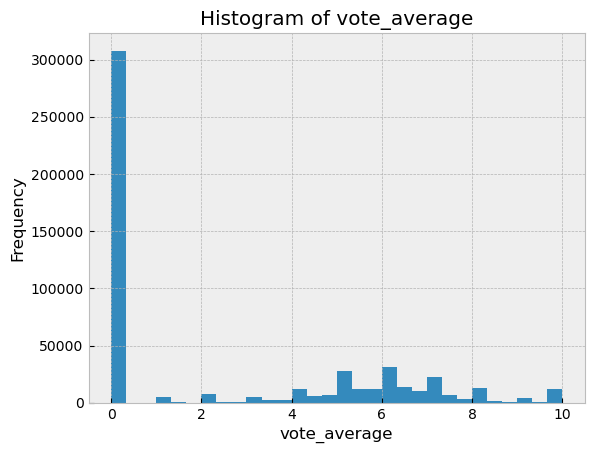

In [64]:
create_histograms(movie_all_clean,['vote_average'], bins=30)

With nearly 60% of zeros in the data. This corresponds to 60% of data with almost zero popularity. This extreme amount of zeros greatly affects the outcome of the analysis.

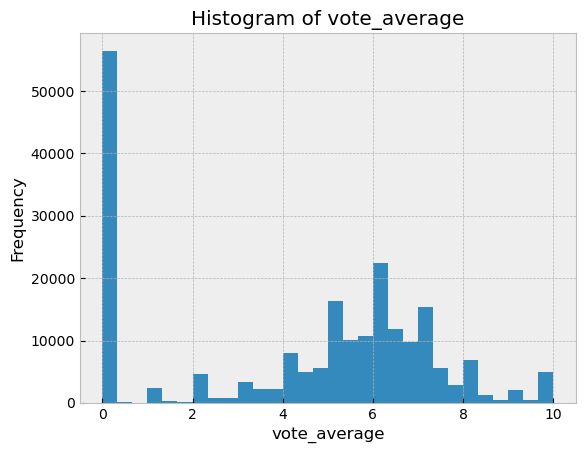

In [65]:
create_histograms(movie_all_clean_model,['vote_average'], bins=30)

###### Outliers

Data description:
count    212954.000000
mean          4.326763
std           2.998689
min           0.000000
25%           0.000000
50%           5.300000
75%           6.538000
max          10.000000
Name: vote_average, dtype: float64
Number of zeros: 56432
Percentage of zeros: 26.5 %
Interquartile range: 6.538
Lower bound: -9.807
Upper bound: 16.345
Number of outliers: 0
Percentage of outliers: 0.0 %
Percentage of missing values: 0.0 %


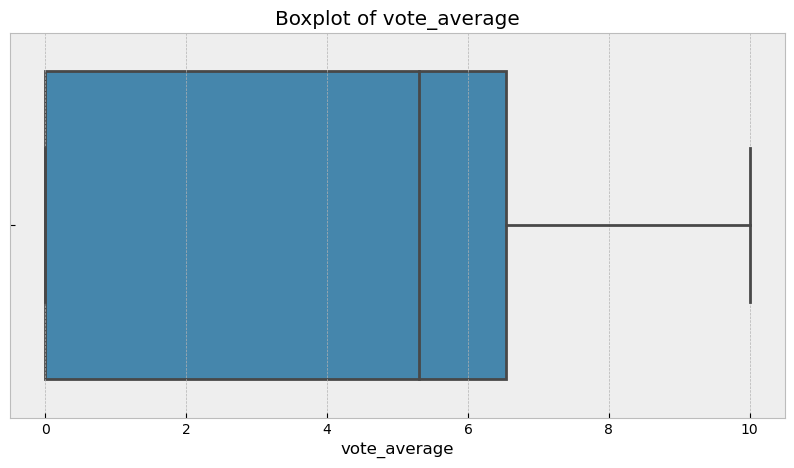

In [66]:
boxplot_analysis(movie_all_clean_model['vote_average'])

the average rating is 4.33 on a scale of 0 to 10, indicating that the overall ratings tend to be moderately low. The standard deviation of 2.998 suggests that there is a considerable spread in the ratings.

The interquartile range (IQR) of 6.538 represents the range between the 25th percentile (Q1) and the 75th percentile (Q3). This shows that the middle 50% of the ratings fall between 0 and 6.538, further highlighting the range of ratings in the dataset. The lower and upper bounds calculated from the IQR are used to identify potential outliers. However, there are no outliers detected in this data, which means that all the ratings fall within the expected range

###### Zero values

In [67]:
movie_all_clean_model_score = movie_all_clean_model[movie_all_clean_model['vote_average'] != 0]


Data description:
count    156522.000000
mean          5.886722
std           1.746726
min           0.500000
25%           5.000000
50%           6.000000
75%           7.000000
max          10.000000
Name: vote_average, dtype: float64
Number of zeros: 0
Percentage of zeros: 0.0 %
Interquartile range: 2.0
Lower bound: 2.0
Upper bound: 10.0
Number of outliers: 3142
Percentage of outliers: 2.01 %
Percentage of missing values: 0.0 %


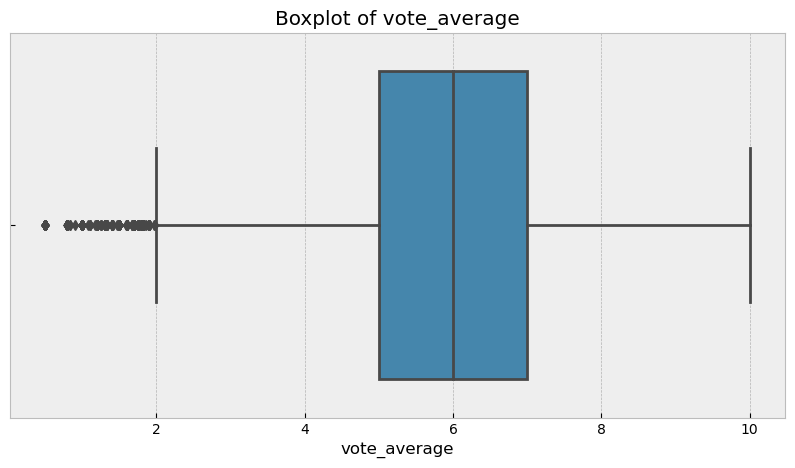

In [68]:
boxplot_analysis(movie_all_clean_model_score['vote_average'])

The 'vote_average' column has a mean of 5.89 and a standard deviation of 1.75, indicating that the average rating for movies in the dataset is relatively high and has relatively low variability. The minimum rating is 0.5, the 25th percentile is 5, the median is 6, and the 75th percentile is 7, showing that most of the movies have ratings above 5. The maximum rating is 10, which is the highest possible rating.

The interquartile range (IQR) is 2, which indicates that 50% of the data falls within a narrow range of 2 points (5 and 7), while the lower bound and upper bound are 2 and 10, respectively, suggesting that the distribution of the data is not skewed. There are 3,142 outliers, which is 2.01% of the data, indicating that there are some movies with very low ratings. 

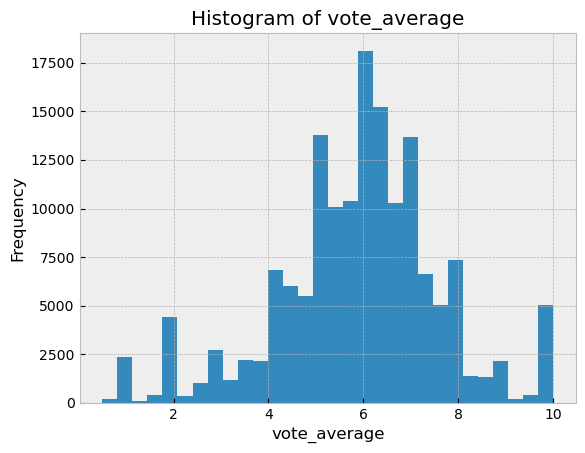

In [69]:
create_histograms(movie_all_clean_model_score,['vote_average'], bins=30)

After removing the overwhelming prevalence of 0 values in this column, we can now observe in this histogram a distribution with a central tendency slightly skewed to the right. The most frequent value in the column is 6, and we can also notice a significant number of occurrences of 10. Contrary to the initial impression we had of this column

###### Analysis vote_average column without zeros


We selected these bin values for the runtime column based on our analysis. After removing zeros and conducting a boxplot analysis to assess data dispersion, we determined that the average runtime was 60, and the maximum value prior to encountering outliers was 217.

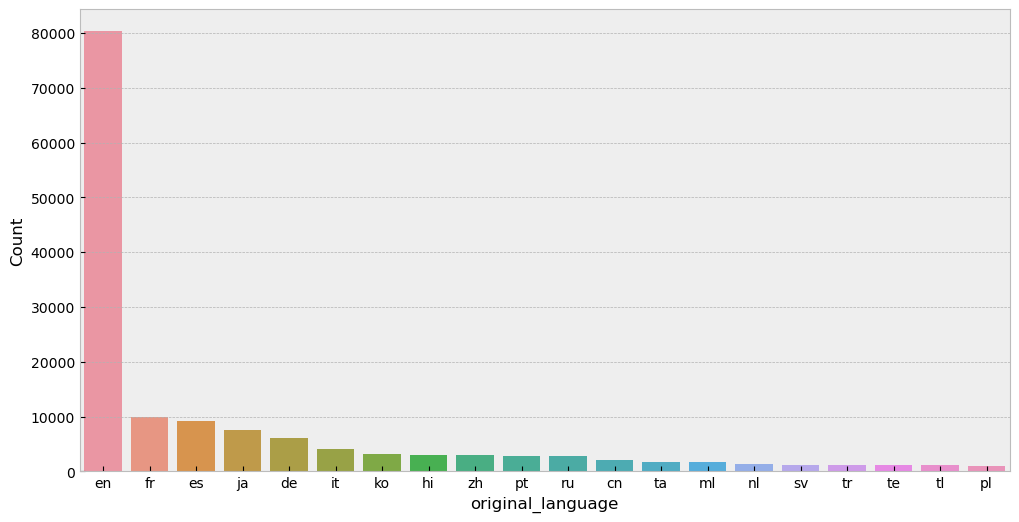

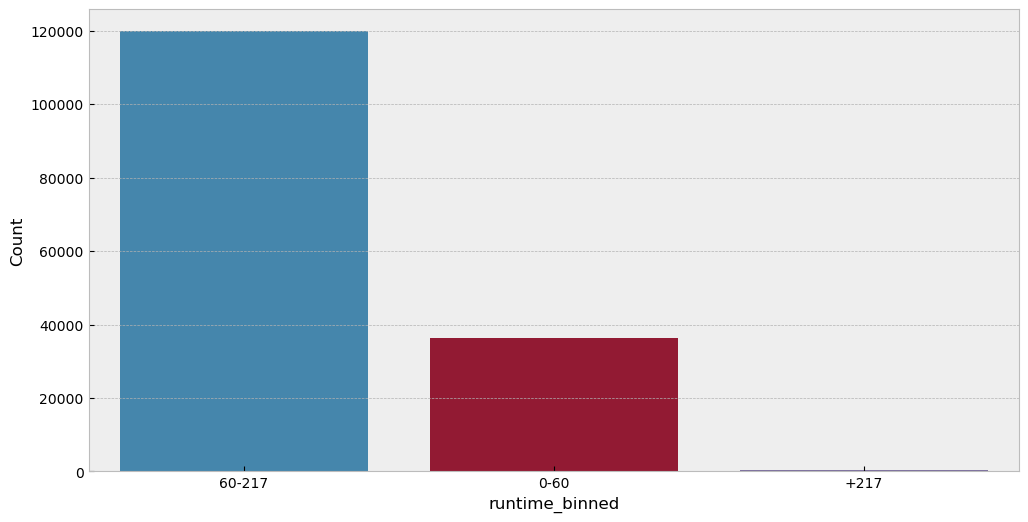

In [70]:
# Bar plot for original_language (top 20)
bar_plot_top_categories(movie_all_clean_model_score, 'original_language')

# Bar plot for runtime
# Binning runtime for the movies_with_nan_vote_average DataFrame
runtime_bins = pd.cut(movie_all_clean_model_score['runtime'], bins=[0, 60, 217, float('inf')], labels=False, include_lowest=True)
movie_all_clean_model_score['runtime_binned'] = runtime_bins

bin_labels = ['0-60', '60-217', '+217']
movie_all_clean_model_score['runtime_binned'] = movie_all_clean_model_score['runtime_binned'].apply(lambda x: bin_labels[x])

# Bar plot for runtime_binned
bar_plot(movie_all_clean_model_score, 'runtime_binned')



LANGUAGES: 

en: English
fr: French
es: Spanish
ja: Japanese
de: German
it: Italian
ko: Korean
hi: Hindi
zh: Chinese
pt: Portuguese
ru: Russian
cn: Chinese
ta: Tamil
ml: Malayalam
nl: Dutch
sv: Swedish
tr: Turkish
te: Telugu
tl: Tagalog
pl: Polish

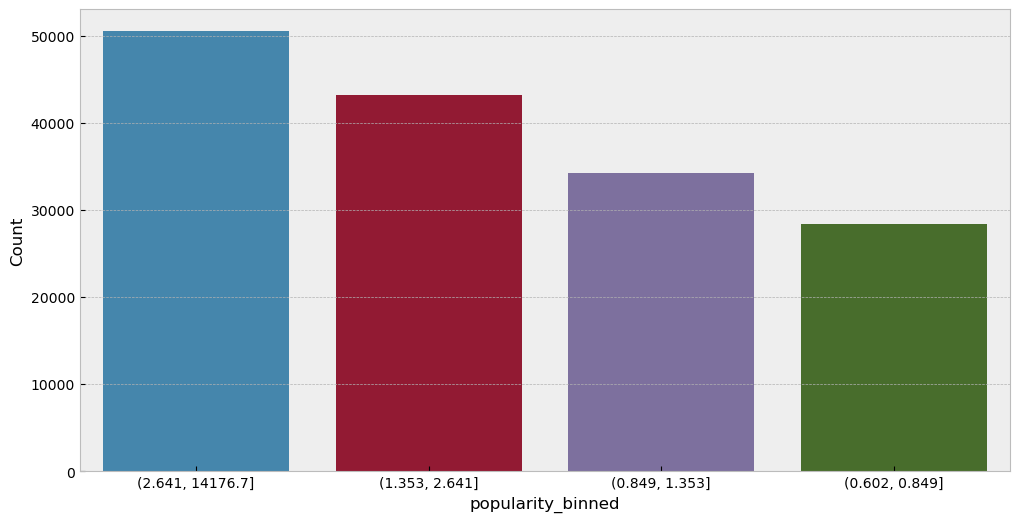

In [71]:
# Bar plot for popularity_binned
bar_plot_top_categories(movie_all_clean_model_score, 'popularity_binned')

The overwhelming predominance of English-language films is strikingly high, which will significantly skew our analysis. After removing all the lower values in the popularity column, we can see that films between 60 and 217 minutes are the most prevalent. Thus, we can deduce that by eliminating less popular films, the majority of short films have been removed.

Lastly, the highest popularity category is the most predominant, with its distribution exhibiting a fairly even descending pattern.

###### Binning proces

In [72]:
# Split the data into fixed intervals
bins = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

# Create the 'vote_average_binned' column using the defined intervals
movie_all_clean_model_score['vote_average_binned'] = pd.cut(movie_all_clean_model_score['vote_average'], bins=bins, include_lowest=True)

# Show the value count for each category
print(movie_all_clean_model_score['vote_average_binned'].value_counts())


(6.0, 7.0]       40857
(5.0, 6.0]       39316
(4.0, 5.0]       22756
(7.0, 8.0]       21455
(3.0, 4.0]        9968
(9.0, 10.0]       5624
(8.0, 9.0]        5013
(1.0, 2.0]        4915
(2.0, 3.0]        4102
(-0.001, 1.0]     2516
Name: vote_average_binned, dtype: int64


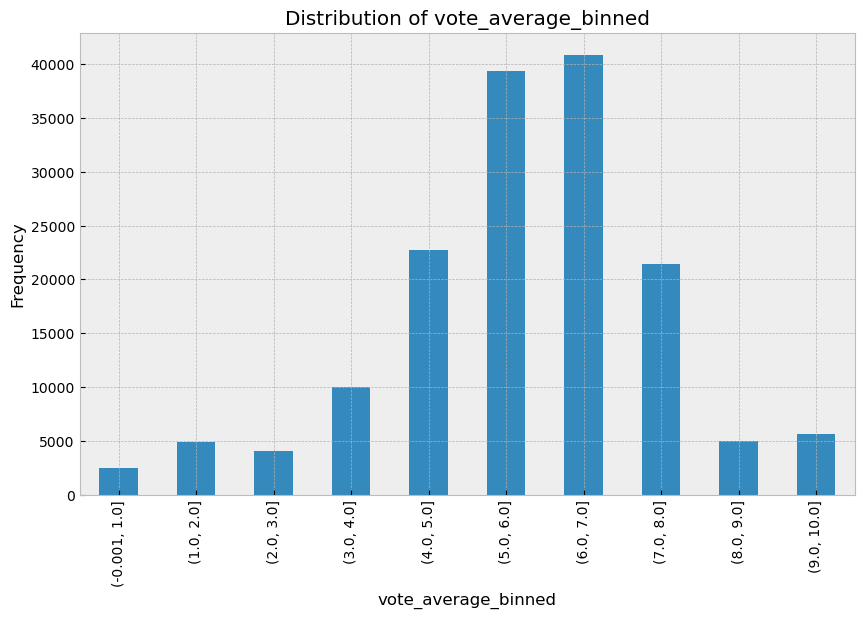

In [73]:
plot_column_counts('vote_average_binned', movie_all_clean_model_score)

In [74]:
vote_average_binned_info = column_info(movie_all_clean_model_score['vote_average_binned'])
print(vote_average_binned_info)

Length of column: 156522
Number of unique values: 10
Number of missing values: 0
Number of zeros: 0
Percentage of zeros: 0.0%
The range of values in the column is: (-0.001, 1.0] - (9.0, 10.0]
{'len': 156522, 'unique': 10, 'num_missing': 0, 'num_zeros': 0, 'pct_zeros': 0.0}


###### Analysis highest vote averages binned movies

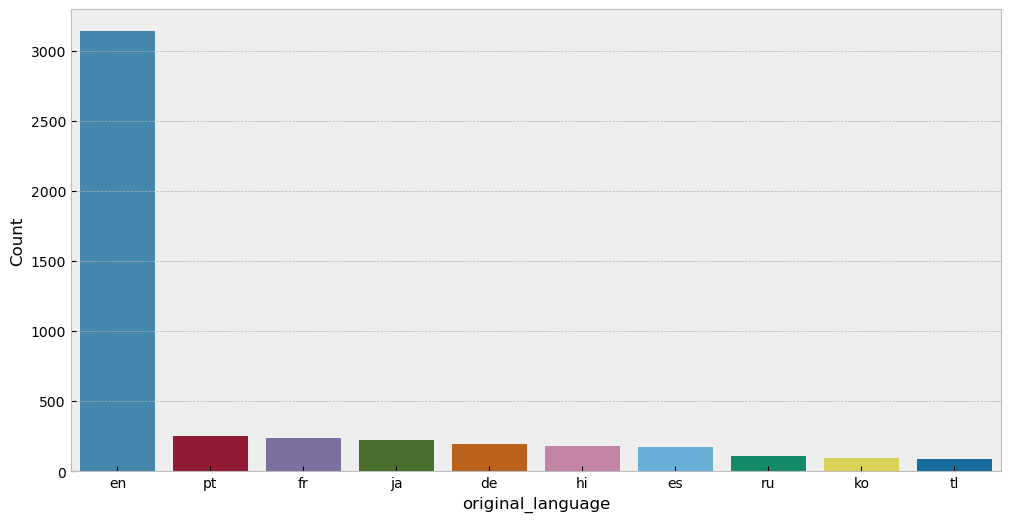

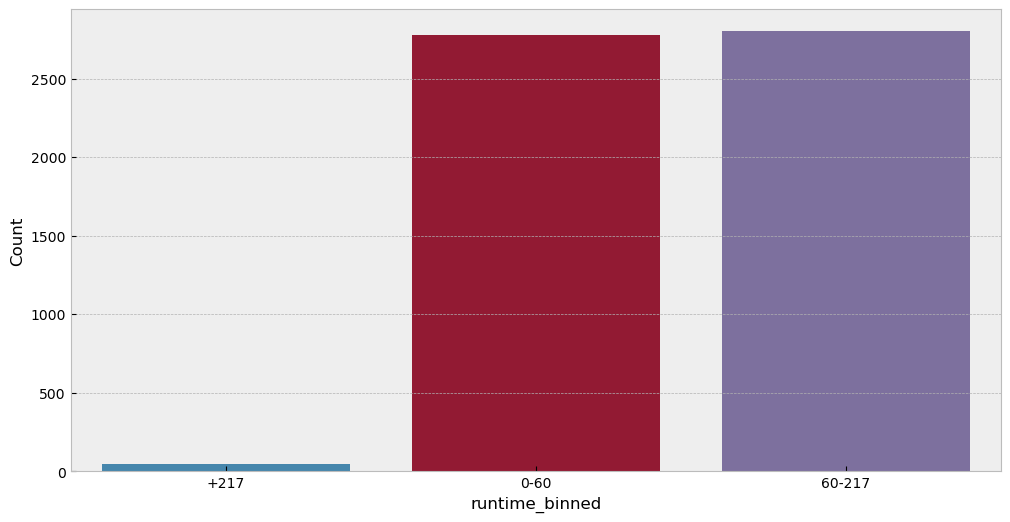

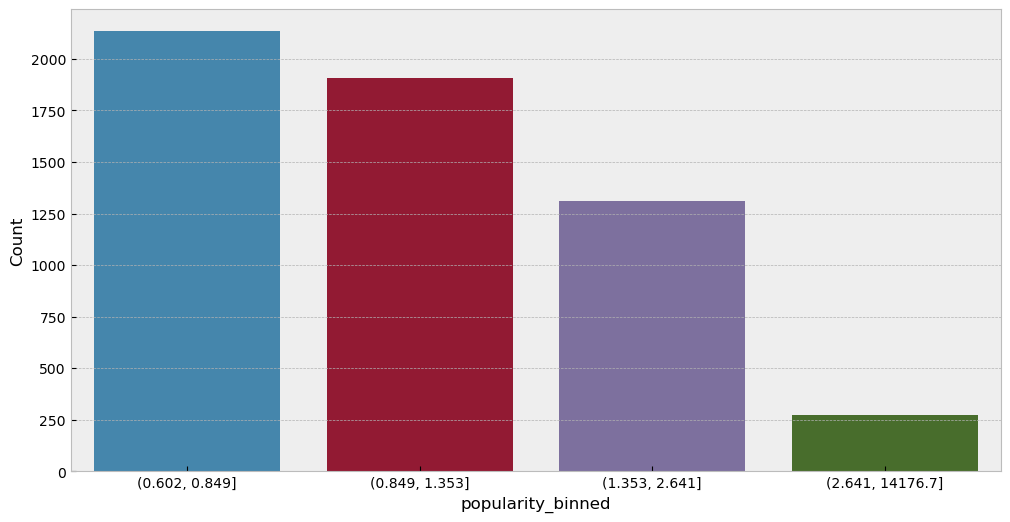

In [75]:
# Filter rows with highest vote_average
highest_vote_average_movies = movie_all_clean_model_score[movie_all_clean_model_score['vote_average_binned'] == pd.Interval(9, 10, closed='right')]

# Bar plot for original_language (top 20)
bar_plot_top_categories(highest_vote_average_movies, 'original_language', top_n=10)

# Bar plot for runtime_binned
bar_plot_simple(highest_vote_average_movies, 'runtime_binned')

# Bar plot for popularity_binned
bar_plot_simple(highest_vote_average_movies, 'popularity_binned')


###### Analysis popularity vs vote avreage

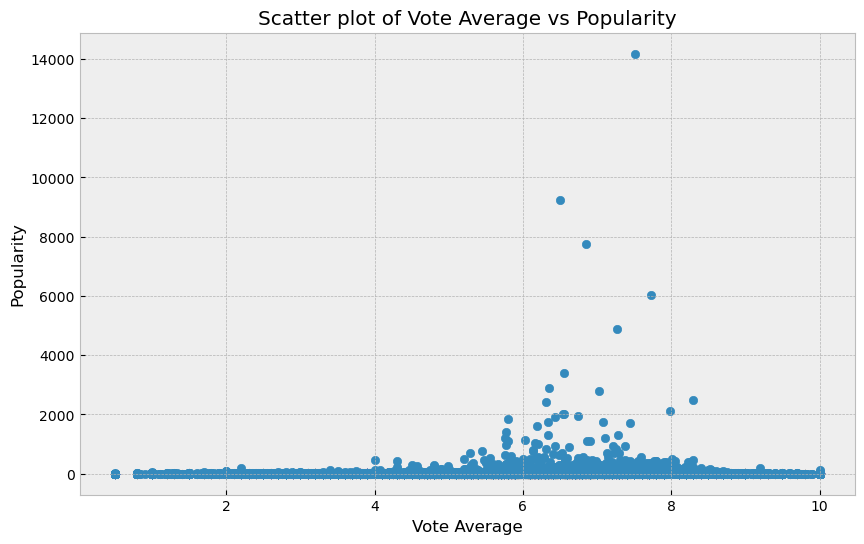

In [76]:
plt.figure(figsize=(10, 6))
plt.scatter(movie_all_clean_model_score['vote_average'], movie_all_clean_model_score['popularity'])
plt.xlabel('Vote Average')
plt.ylabel('Popularity')
plt.title('Scatter plot of Vote Average vs Popularity')
plt.show()


OBSERVACIONES > ESTOY HACIENDO LA MISMA GRÁFICO QUE HE HECHO AL PRINCIPIO CON TODOS LOS DATOS, HAY CAMBIO? 

##### vote_count column

###### Overview

In [77]:
movie_all_clean_model_score['vote_count'].info()

<class 'pandas.core.series.Series'>
Int64Index: 156522 entries, 0 to 532781
Series name: vote_count
Non-Null Count   Dtype
--------------   -----
156522 non-null  int64
dtypes: int64(1)
memory usage: 2.4 MB


In [78]:
vote_count_info = column_info(movie_all_clean_model_score['vote_count'])
print(vote_count_info)

Length of column: 156522
Number of unique values: 3461
Number of missing values: 0
Number of zeros: 89
Percentage of zeros: 0.06%
The range of values in the column is: 0 - 33549
{'len': 156522, 'unique': 3461, 'num_missing': 0, 'num_zeros': 89, 'pct_zeros': 0.06}


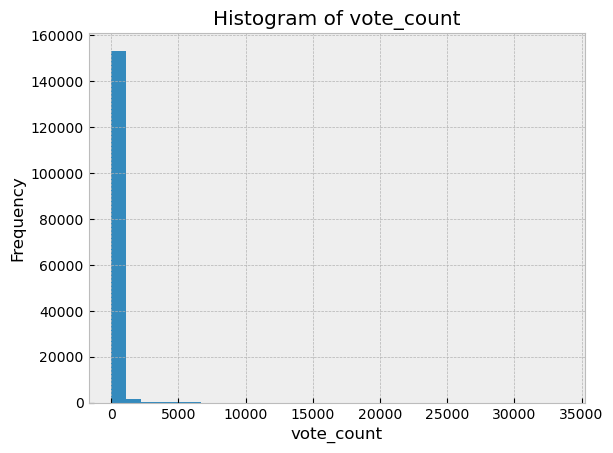

In [79]:
create_histograms(movie_all_clean_model_score,['vote_count'], bins=30)

###### Outliers

Data description:
count    156522.000000
mean        118.221419
std         808.005366
min           0.000000
25%           2.000000
50%           5.000000
75%          19.000000
max       33549.000000
Name: vote_count, dtype: float64
Number of zeros: 89
Percentage of zeros: 0.06 %
Interquartile range: 17.0
Lower bound: -23.5
Upper bound: 44.5
Number of outliers: 23988
Percentage of outliers: 15.33 %
Percentage of missing values: 0.0 %


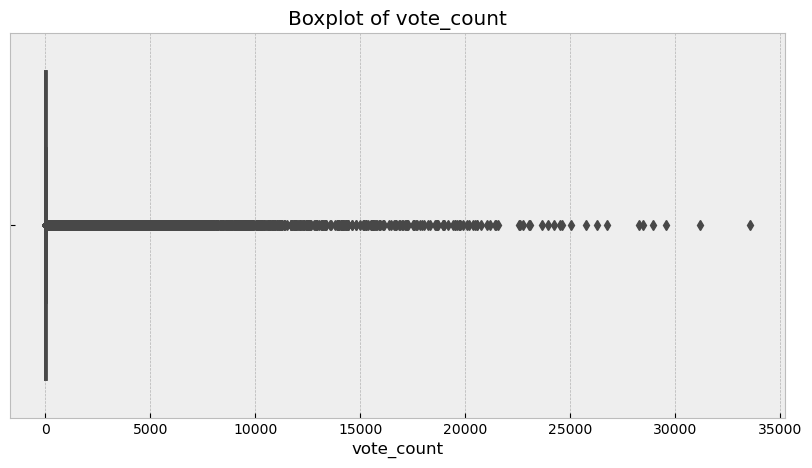

In [80]:
boxplot_analysis(movie_all_clean_model_score['vote_count'])


The data displays a wide range in the number of votes, with the maximum vote count being 33,549 and the minimum being 0. The average number of votes per movie is 118.22, which is considerably lower than the maximum value. This discrepancy can be attributed to the large standard deviation of 808, indicating a high variability in the vote counts.

The interquartile range (IQR) is 17 votes, meaning that 50% of the movies received between 2 and 19 votes. Notably, there are 89 movies with zero votes, which may suggest limited audience engagement or data collection issues for these particular films. There are 23,988 outliers in the dataset, accounting for 15.33% of the total observations. These outliers represent movies with exceptionally high vote counts and may indicate popular or influential films within the dataset.

The mean vote count is 118, which indicates that on average, movies received 118 votes. However, the standard deviation is quite high at 808, which means that there is a large variation in the number of votes movies received. The minimum vote count is 0, which indicates that some movies did not receive any votes, while the maximum is 33,549. The majority of the movies (75%) have received 19 votes or fewer. The interquartile range is 17, which means that half of the movies received between 2 and 19 votes. The lower bound is negative (-23.5), which is not a meaningful value in this context, while the upper bound is 44.5. There are 89 movies with zero votes, and 15.33% of the movies have vote counts that are considered outliers based on the calculated limits. There are almost no missing values in this column, 0.06%.

DECIDIMOS no eliminar nada más y estandarizar lo que tenemos - explaya

###### Binning Proces

In [81]:
# Calculate percentiles
percentiles = np.percentile(movie_all_clean_model_score['vote_count'], [0, 33.33, 66.67, 100])

# Create labels for the bins
labels = ['low', 'medium', 'high']

# Remove duplicate bin edges and sort them in ascending order
unique_bins = sorted(list(set([0] + list(percentiles))))

# Apply binning to the column
movie_all_clean_model_score['vote_count_binned'] = pd.cut(movie_all_clean_model_score['vote_count'], bins=unique_bins, labels=labels, include_lowest=True)

# Show distribution of bins
print(movie_all_clean_model_score['vote_count_binned'].value_counts())



low       63536
high      51670
medium    41316
Name: vote_count_binned, dtype: int64


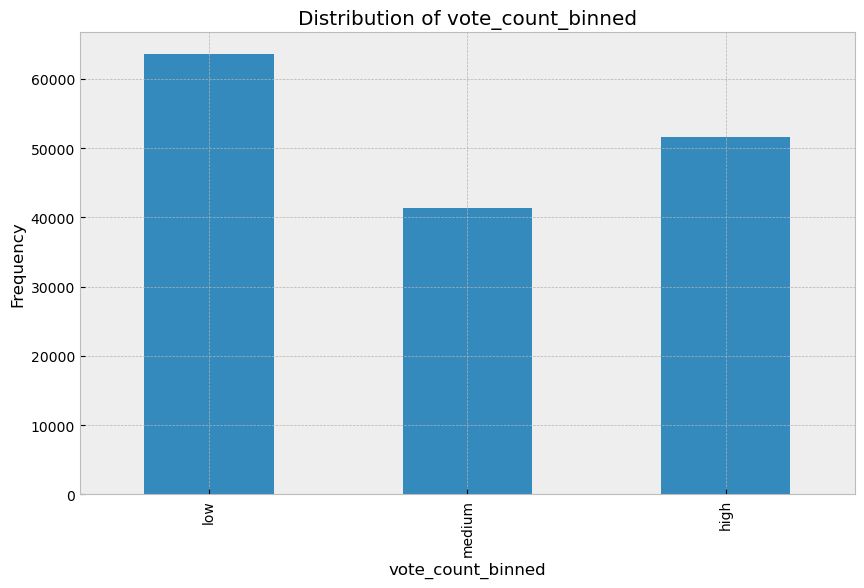

In [82]:
plot_column_counts('vote_count_binned', movie_all_clean_model_score)

###### Analysis vote count vs popularity & vote count vs vote average 

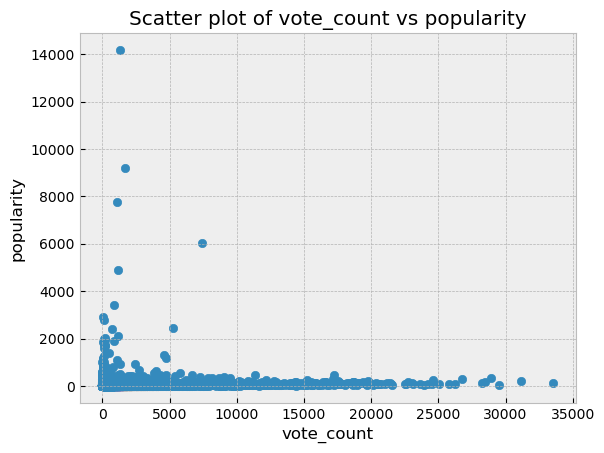

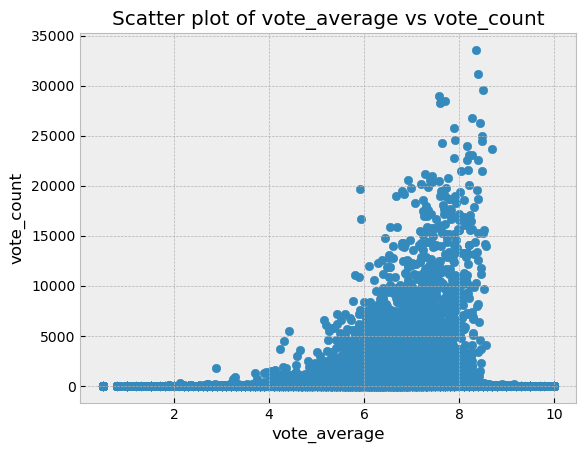

In [83]:
# Scatter plot of vote_count vs popularity
scatter_plot(movie_all_clean_model_score, 'vote_count', 'popularity')

# Scatter plot of vote_count vs vote_average
scatter_plot(movie_all_clean_model_score, 'vote_average', 'vote_count')



###### Analysis vote count binned vs popularity binned & vote count binned vs vote average binned

As both variables are categorical, we can use a heatmap to display the relationship between them. First, we need to create a contingency table to show the frequency of each combination of categories.

In [84]:
# Create a contingency table for vote_count_binned vs popularity_binned
vote_count_popularity = create_contingency_table(movie_all_clean_model_score, 'vote_count_binned', 'popularity_binned')

# Create a contingency table for vote_count_binned vs vote_average_binned
vote_count_vote_average = create_contingency_table(movie_all_clean_model_score, 'vote_count_binned', 'vote_average_binned')


We normalize the contingency tables so that each row sums up to 1.

In [85]:
normalized_vote_count_popularity = normalize_contingency_table(vote_count_popularity)
normalized_vote_count_vote_average = normalize_contingency_table(vote_count_vote_average)


<Figure size 640x480 with 0 Axes>

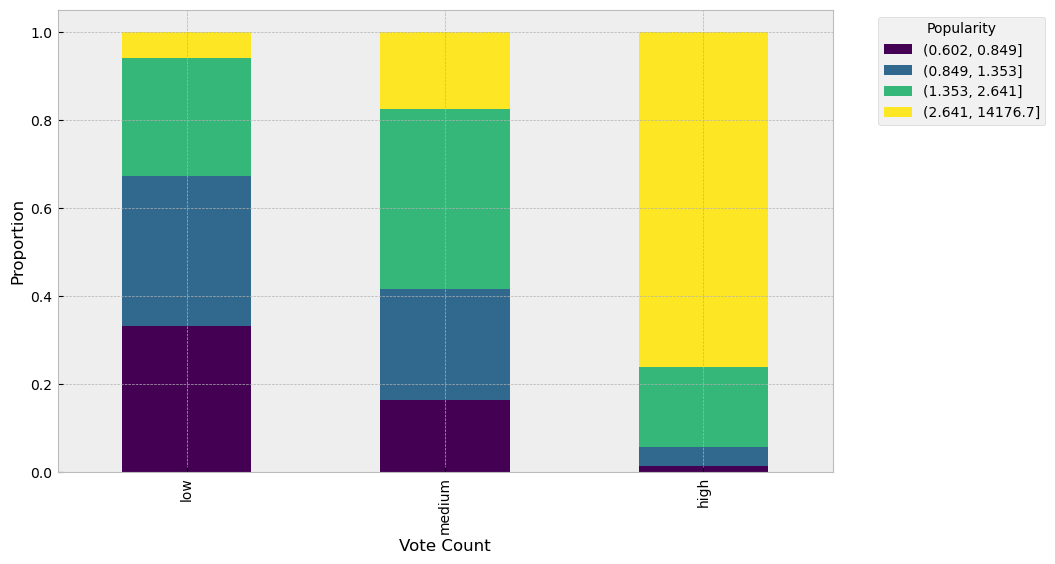

<Figure size 640x480 with 0 Axes>

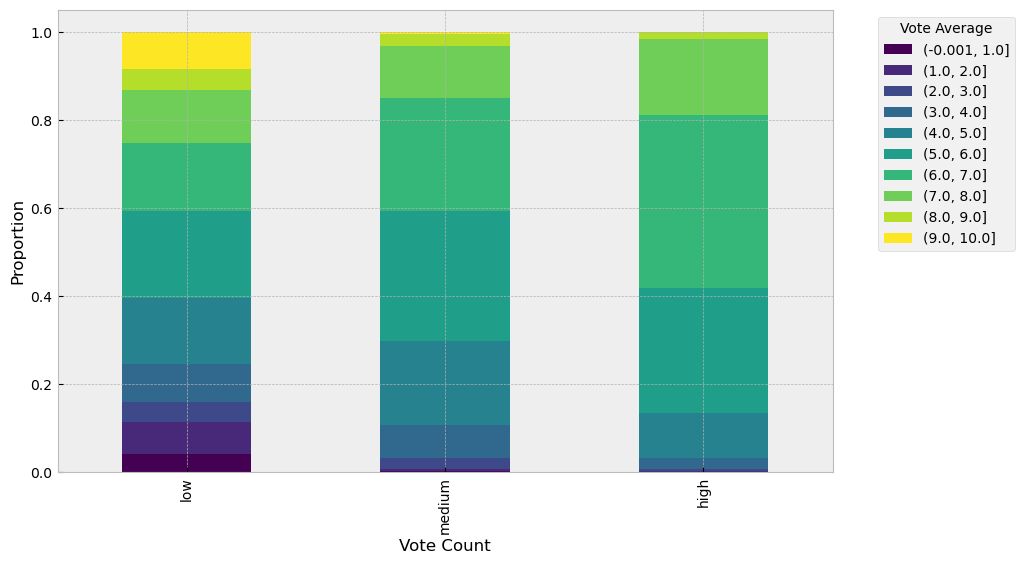

In [86]:
# Stacked bar chart for vote_count_binned vs popularity_binned
stacked_bar_plot(normalized_vote_count_popularity, 'Vote Count', 'Popularity')

# Stacked bar chart for vote_count_binned vs vote_average_binned
stacked_bar_plot(normalized_vote_count_vote_average, 'Vote Count', 'Vote Average')


###### Analysis high vote count and high popularity values


Porcentaje de filas con 'high' en 'vote_count_binned' y (2.641, 14176.7] en 'popularity_binned': 25.16%


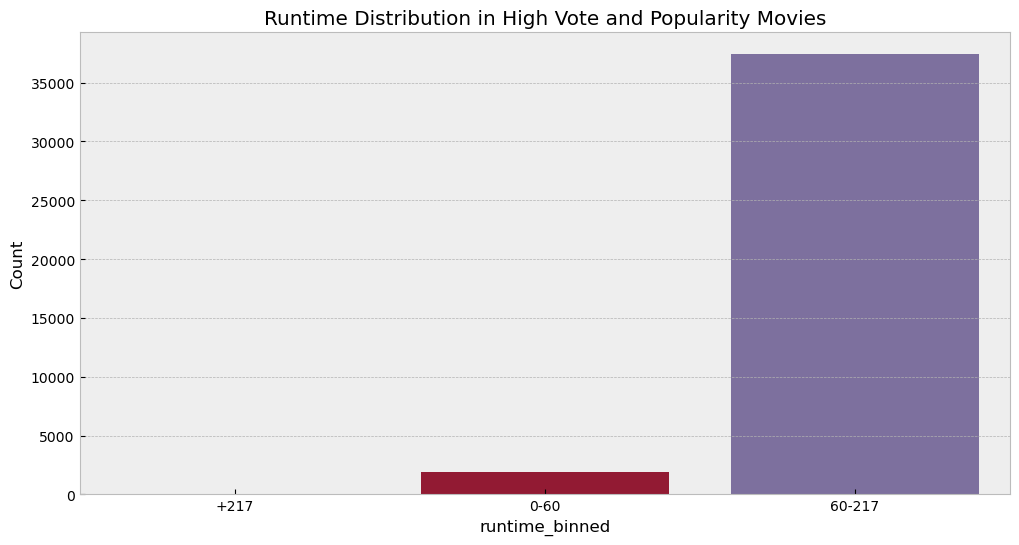

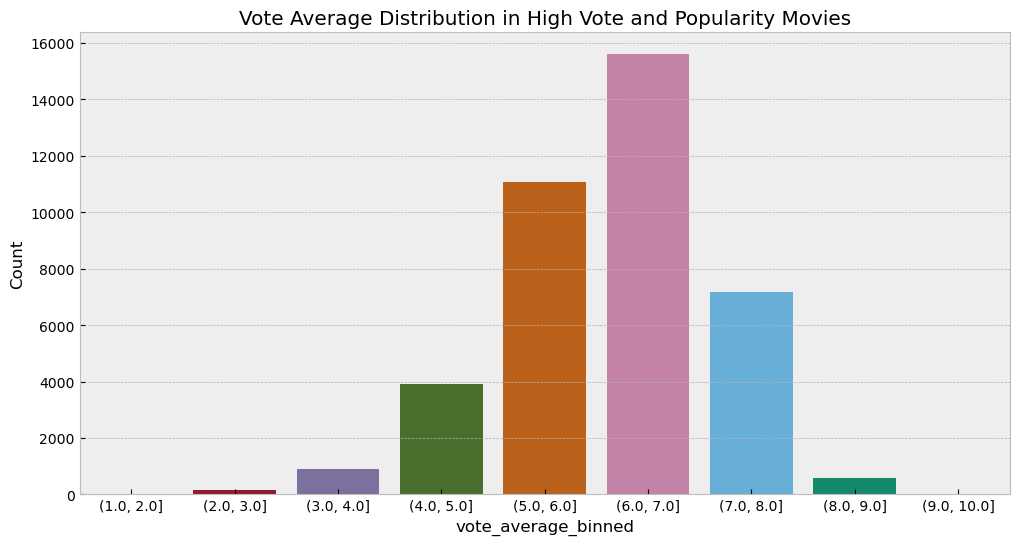

In [87]:
category_to_compare = None
for category in movie_all_clean_model_score['popularity_binned'].cat.categories:
    if category.right == 14176.7:
        category_to_compare = category
        break

# Filter the rows with 'high' in 'vote_count_binned' and (2.641, 14176.7] in 'popularity_binned'
high_vote_and_popularity = movie_all_clean_model_score[(movie_all_clean_model_score['vote_count_binned'] == 'high') & (movie_all_clean_model_score['popularity_binned'] == category_to_compare)]

# Calculate the percentage of these rows in the original DataFrame
percentage = (len(high_vote_and_popularity) / len(movie_all_clean_model_score)) * 100
print(f"Porcentaje de filas con 'high' en 'vote_count_binned' y (2.641, 14176.7] en 'popularity_binned': {percentage:.2f}%")

# Bar chart for runtime
bar_plot_simple(high_vote_and_popularity, 'runtime_binned', 'Runtime Distribution in High Vote and Popularity Movies')

# Bar chart for vote_average
bar_plot_simple(high_vote_and_popularity, 'vote_average_binned', 'Vote Average Distribution in High Vote and Popularity Movies')


In [88]:
# Calculate the 10 most frequent original languages in the high_vote_and_popularity DataFrame.
top_10_languages = high_vote_and_popularity['original_language'].value_counts().nlargest(10)

print("Top 10 original languages in high_vote_and_popularity DataFrame:")
print(top_10_languages)


Top 10 original languages in high_vote_and_popularity DataFrame:
en    25297
fr     2642
ja     1778
es     1537
it     1344
hi      878
ko      818
de      757
zh      544
cn      517
Name: original_language, dtype: int64


LANGUAGES:

en (English)
fr (French)
ja (Japanese)
es (Spanish)
it (Italian)
hi (Hindi)
ko (Korean)
de (German)
zh (Chinese)
cn (Chinese, Mandarin)

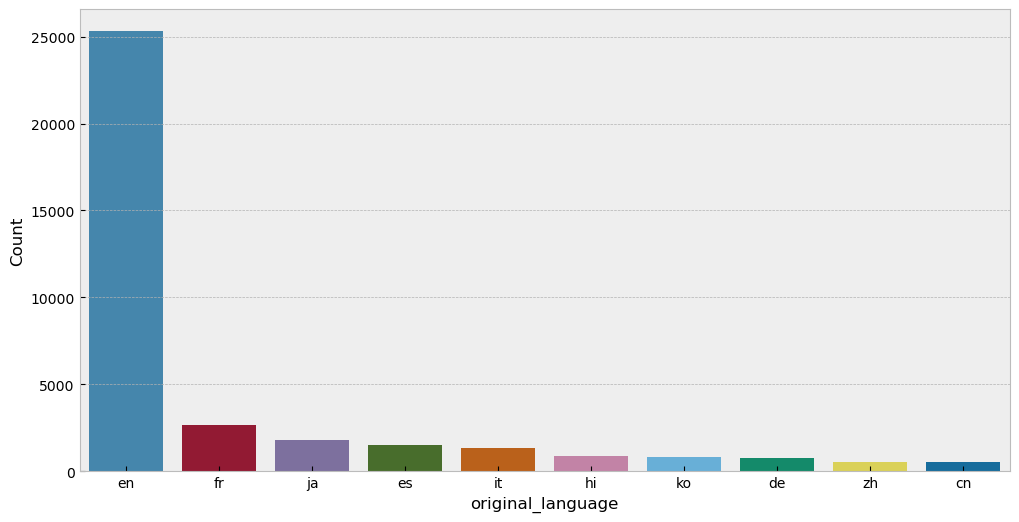

In [89]:
# Bar chart for the 10 most frequent original languages.
bar_plot_top_categories(high_vote_and_popularity, 'original_language', top_n=10)


##### year column

###### Transform date to year

In [90]:
type(movie_all_clean_model_score ['release_date'])

pandas.core.series.Series

In [91]:
# Convert 'release_date' to datetime
movie_all_clean_model_score['release_date'] = pd.to_datetime(movie_all_clean_model_score['release_date'])

# Now we can call the column_info function for 'release_date'
release_date_info = column_info(movie_all_clean_model_score['release_date'])
print(release_date_info)


Length of column: 156522
Number of unique values: 15251
Number of missing values: 0
Number of zeros: 0
Percentage of zeros: 0.0%
The range of values in the column is: 1980-01-01 00:00:00 - 2023-04-27 00:00:00
{'len': 156522, 'unique': 15251, 'num_missing': 0, 'num_zeros': 0, 'pct_zeros': 0.0}


In [92]:
def transform_dates_to_years(df, column):
    df[column] = pd.to_datetime(df[column])
    df['year'] = df[column].apply(lambda x: int(datetime.datetime.strftime(x, '%Y')) if pd.notnull(x) else np.nan)
    
    df = df.drop(column, axis=1)
    df = df.dropna(subset=['year'])
    df['year'] = df['year'].astype(int)
    
    return df



In [93]:
import datetime

In [94]:
transform_dates_to_years (movie_all_clean_model_score,'release_date')

id_movie                                              title  \
0              2                                              Ariel   
1              3                                Shadows in Paradise   
2              5                                         Four Rooms   
3              6                                     Judgment Night   
4              8                   Life in Loops (A Megacities RMX)   
...          ...                                                ...   
532704   1116920                     Smosh Live: Presented by 5 Gum   
532724   1116997  Nøtteknekkeren - ballett i to akter fra Den No...   
532725   1116999                                              Frida   
532765   1117114                                      Le petit Karl   
532781   1117157                      Ashley Gavin: Live in Chicago   

                                           original_title original_language  \
0                                                   Ariel                fi   
1                                    Varjoja paratiisissa                fi   
2                                              Four Rooms                en   
3                                          Judgment Night                en   
4                        Life in Loops (A Megacities RMX)                en   
...                                                   ...               ...   
532704                     Smosh Live: Presented by 5 Gum                en   
532724  Nøtteknekkeren - ballett i to akter fra Den No...                en   
532725                                              Frida                no   
532765                                      Le petit Karl                fr   
532781                      Ashley Gavin: Live in Chicago                en   

                                                 overview  runtime  \
0       Taisto Kasurinen is a Finnish coal miner whose...       73   
1       An episode in the life of Nikander, a garbage ...       76   
2       It's Ted the Bellhop's first night on the job....       98   
3       While racing to a boxing match, Frank, Mike, J...      109   
4       Timo Novotny labels his new project an experim...       80   
...                                                   ...      ...   
532704  The very first Smosh live stream with sketches...       83   
532724  The Nutcracker is about a young girl who recei...       93   
532725  Frida is 11 years old and on the threshold of ...       40   
532765                                                           0   
532781  It's Ashley Gavin's debut comedy special! You ...       59   

        popularity  vote_count  vote_average    budget  ...  \
0            6.736         247         7.055         0  ...   
1            6.212         268         7.200         0  ...   
2           23.513        2350         5.756   4000000  ...   
3            9.613         283         6.558  21000000  ...   
4            2.037          24         7.708     42000  ...   
...            ...         ...           ...       ...  ...   
532704       1.187           1        10.000         0  ...   
532724       0.751           1         8.000         0  ...   
532725       0.730           1         6.000         0  ...   
532765       0.811           1        10.000         0  ...   
532781       1.400           1        10.000         0  ...   

                           prod_comp_name                str_comp_name  \
0               Villealfa Filmproductions                       Filmin   
1               Villealfa Filmproductions                          NaN   
2                   A Band Apart, Miramax                Movistar Plus   
3                JVC, Largo Entertainment                       Filmin   
4                                 inLoops  DocAlliance Films, GuideDoc   
...                                   ...                          ...   
532704                  Defy Media, Smosh                          NaN   
532724          

###### Overview

In [95]:
movie_all_clean_model_score.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 156522 entries, 0 to 532781
Data columns (total 23 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   id_movie             156522 non-null  int64         
 1   title                156522 non-null  category      
 2   original_title       156522 non-null  category      
 3   original_language    156522 non-null  category      
 4   overview             156522 non-null  category      
 5   release_date         156522 non-null  datetime64[ns]
 6   runtime              156522 non-null  int64         
 7   popularity           156522 non-null  float64       
 8   vote_count           156522 non-null  int64         
 9   vote_average         156522 non-null  float64       
 10  budget               156522 non-null  int64         
 11  revenue              156522 non-null  int64         
 12  genre                146202 non-null  category      
 13  prod_comp_name

In [96]:
year_info = column_info(movie_all_clean_model_score['year'])
print(year_info)

Length of column: 156522
Number of unique values: 44
Number of missing values: 0
Number of zeros: 0
Percentage of zeros: 0.0%
The range of values in the column is: 1980 - 2023
{'len': 156522, 'unique': 44, 'num_missing': 0, 'num_zeros': 0, 'pct_zeros': 0.0}


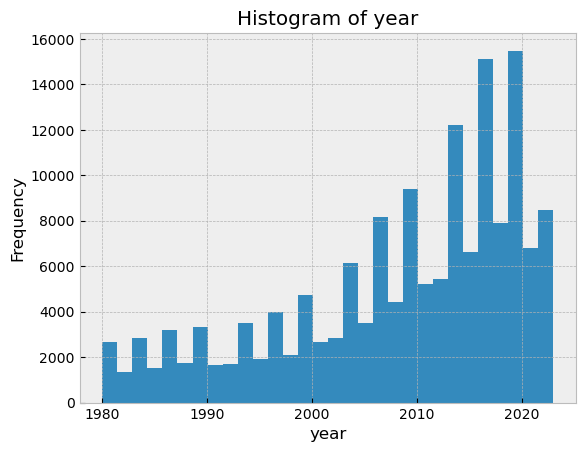

In [97]:
create_histograms(movie_all_clean_model_score,['year'], bins=30)

###### Outliers

Data description:
count    156522.000000
mean       2008.370868
std          11.254138
min        1980.000000
25%        2002.000000
50%        2011.000000
75%        2017.000000
max        2023.000000
Name: year, dtype: float64
Number of zeros: 0
Percentage of zeros: 0.0 %
Interquartile range: 15.0
Lower bound: 1979.5
Upper bound: 2039.5
Number of outliers: 0
Percentage of outliers: 0.0 %
Percentage of missing values: 0.0 %


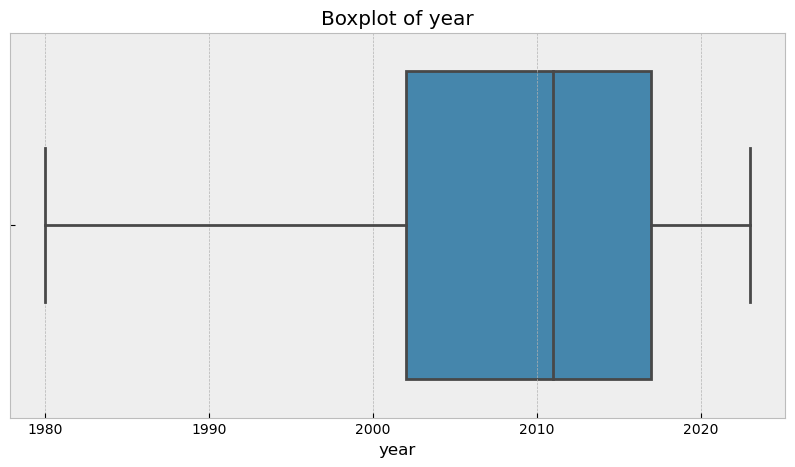

In [98]:
boxplot_analysis(movie_all_clean_model_score['year'])

The data spans from 1980 to 2023, with a total of 156,522 observations. The average release year is 2008, indicating that the majority of the movies in this dataset are from the 21st century. The standard deviation of 11.25 suggests a moderate variability in the release years.

The interquartile range (IQR), which measures the spread of the middle 50% of the data, is 15 years. This means that 50% of the movies in the dataset were released between 2002 and 2017. Notably, there are no zero values, outliers, or missing values in this variable. This implies that the data is complete and well-distributed within the observed period, without any extreme or unexpected values that could affect the analysis.

###### Analysis year vs popularity binned, vote average binned and vote_count binned

<Figure size 640x480 with 0 Axes>

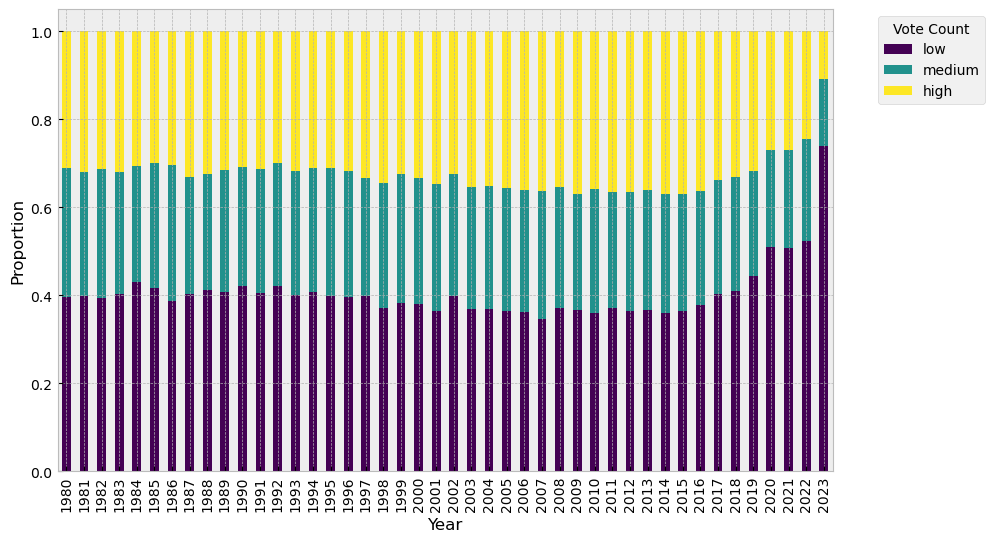

<Figure size 640x480 with 0 Axes>

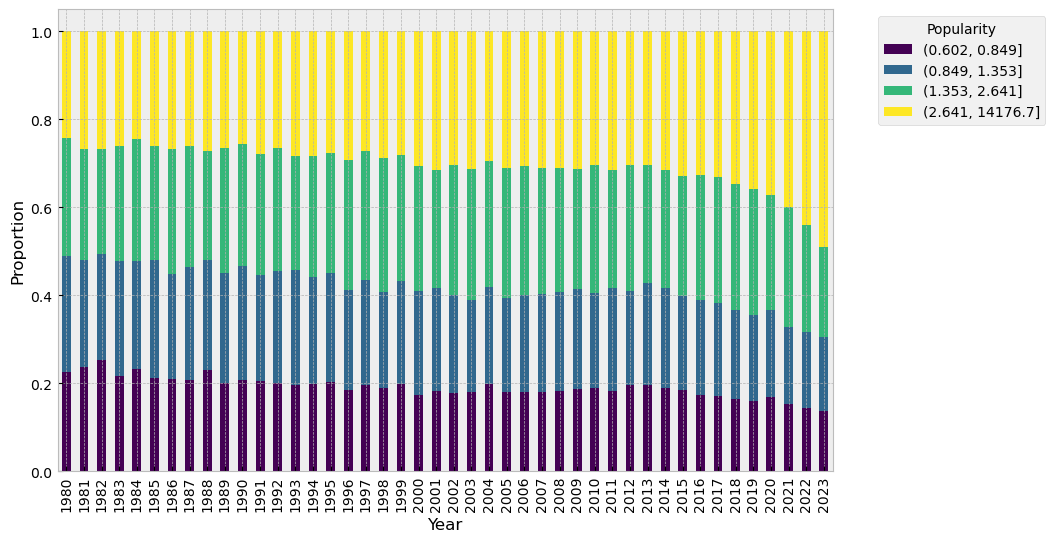

<Figure size 640x480 with 0 Axes>

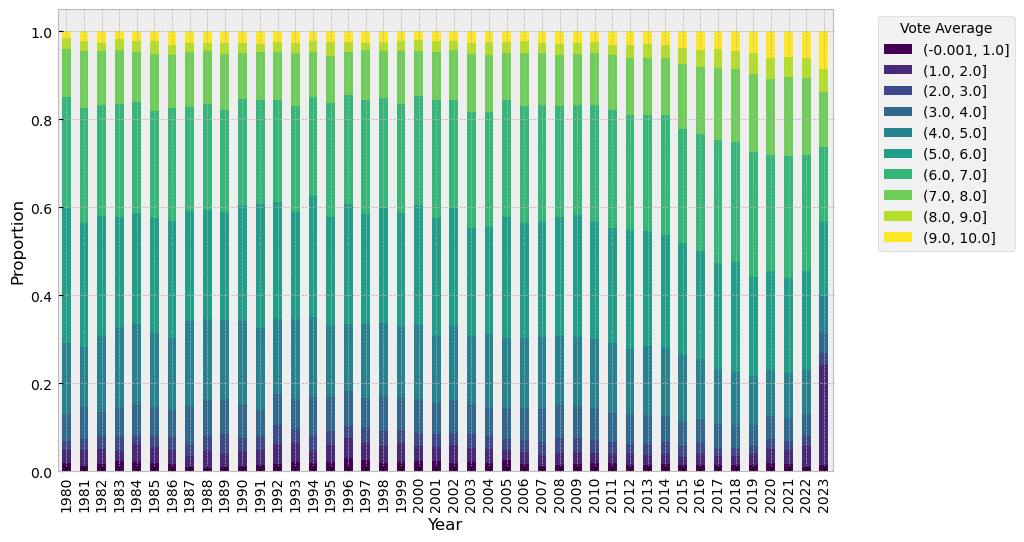

In [99]:
# Calculate the normalized contingency tables
normalized_year_vote_count = pd.crosstab(movie_all_clean_model_score['year'], movie_all_clean_model_score['vote_count_binned'], normalize='index')
normalized_year_popularity = pd.crosstab(movie_all_clean_model_score['year'], movie_all_clean_model_score['popularity_binned'], normalize='index')
normalized_year_vote_average = pd.crosstab(movie_all_clean_model_score['year'], movie_all_clean_model_score['vote_average_binned'], normalize='index')

# Stacked bar plot for year vs vote_count_binned
stacked_bar_plot(normalized_year_vote_count, 'Year', 'Vote Count')

# Stacked bar plot for year vs popularity_binned
stacked_bar_plot(normalized_year_popularity, 'Year', 'Popularity')

# Stacked bar plot for year vs vote_average_binned
stacked_bar_plot(normalized_year_vote_average, 'Year', 'Vote Average')



#####  budget column

###### Overview

In [100]:
movie_all_clean_model_score['budget'].info()

<class 'pandas.core.series.Series'>
Int64Index: 156522 entries, 0 to 532781
Series name: budget
Non-Null Count   Dtype
--------------   -----
156522 non-null  int64
dtypes: int64(1)
memory usage: 2.4 MB


In [101]:
budget_info = column_info(movie_all_clean_model_score['budget'])
print(budget_info)

Length of column: 156522
Number of unique values: 2496
Number of missing values: 0
Number of zeros: 138759
Percentage of zeros: 88.65%
The range of values in the column is: 0 - 999999999
{'len': 156522, 'unique': 2496, 'num_missing': 0, 'num_zeros': 138759, 'pct_zeros': 88.65}


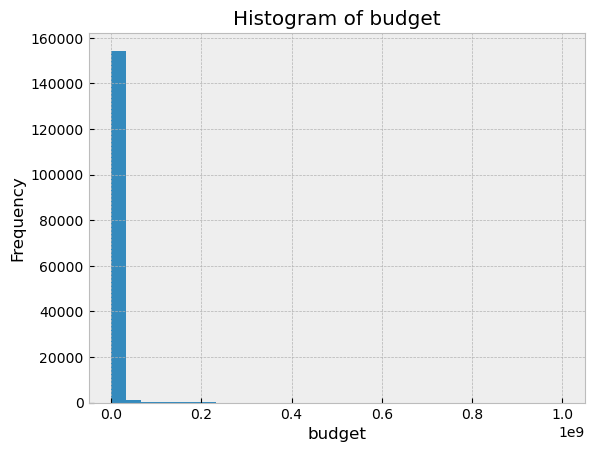

In [102]:
create_histograms(movie_all_clean_model_score,['budget'], bins=30)

###### Outliers

Data description:
count    1.565220e+05
mean     1.650707e+06
std      1.141517e+07
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.000000e+09
Name: budget, dtype: float64
Number of zeros: 138759
Percentage of zeros: 88.65 %
Interquartile range: 0.0
Lower bound: 0.0
Upper bound: 0.0
Number of outliers: 17763
Percentage of outliers: 11.35 %
Percentage of missing values: 0.0 %


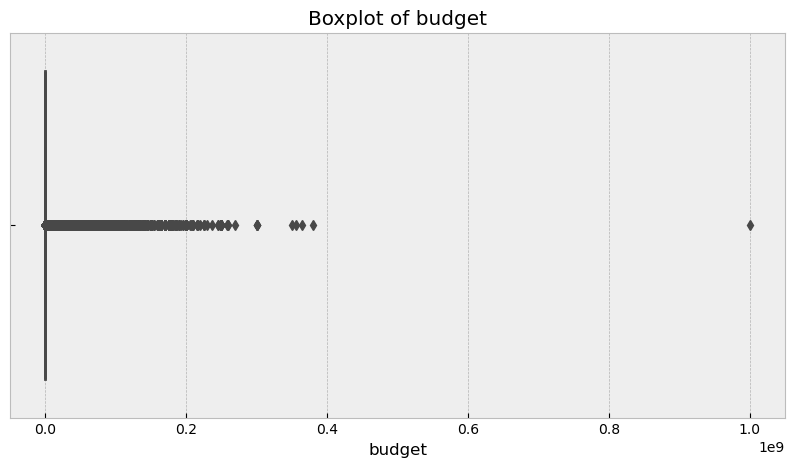

In [103]:
boxplot_analysis(movie_all_clean_model_score['budget'])

The data reveals a significant presence of zero values with 138,759 movies (88.65% of the dataset). This significantly  affects the distribution of the data, skews the data heavily towards zero, which causes the mean budget to be relatively low at 1,650,707. Moreover, the interquartile range, lower bound, and upper bound are all equal to zero, indicating that the zero values are dominating the distribution and providing a limited view of the actual budget distribution. These zero values also impact the identification of outliers. 

The non-zero observations show a considerable range in movie budgets, with the maximum value reaching 1 billion dollars. The average budget for all movies in the dataset is 1.65 million dollars; however, this value may not accurately represent the true average, given the high number of zero values. 
There are 17,763 outliers in the data, accounting for 11.35% of the total observations. These outliers represent movies with exceptionally high budgets and may include blockbuster or high-profile films.

###### Top budget movies

In [104]:
top_budget_movies = movie_all_clean_model_score.nlargest(10, 'budget')
top_budget_movies = top_budget_movies[['title', 'year','original_language', 'runtime', 'popularity', 'vote_average', 'budget']]
print(top_budget_movies)


                                              title  year original_language  \
21533                                         Rango  2011                en   
874     Pirates of the Caribbean: On Stranger Tides  2011                en   
47838                       Avengers: Age of Ultron  2015                en   
118736                            Avengers: Endgame  2019                en   
38621                      Avatar: The Way of Water  2022                en   
180        Pirates of the Caribbean: At World's End  2007                en   
61578                                Justice League  2017                en   
62428                  Mega Man X: The Day of Sigma  2005                ja   
118737                       Avengers: Infinity War  2018                en   
670                                Superman Returns  2006                en   

        runtime  popularity  vote_average     budget  
21533       107      77.673         6.811  999999999  
874         137     

###### Zero Values

Upon removing the zero values from the column, a more accurate representation of the data distribution can be obtained, enabling a more thorough analysis. However, it is important to note that not all rows with zero budget values will be eliminated, as doing so would result in the loss of a substantial amount of data. Instead, the budget column will be retained as supplementary information, without playing a significant role in the overall analysis. This approach balances data preservation with an understanding of the limitations posed by the presence of zero values in the budget column.

###### Average Budget by Year for Movies with Non-Zero Budgets

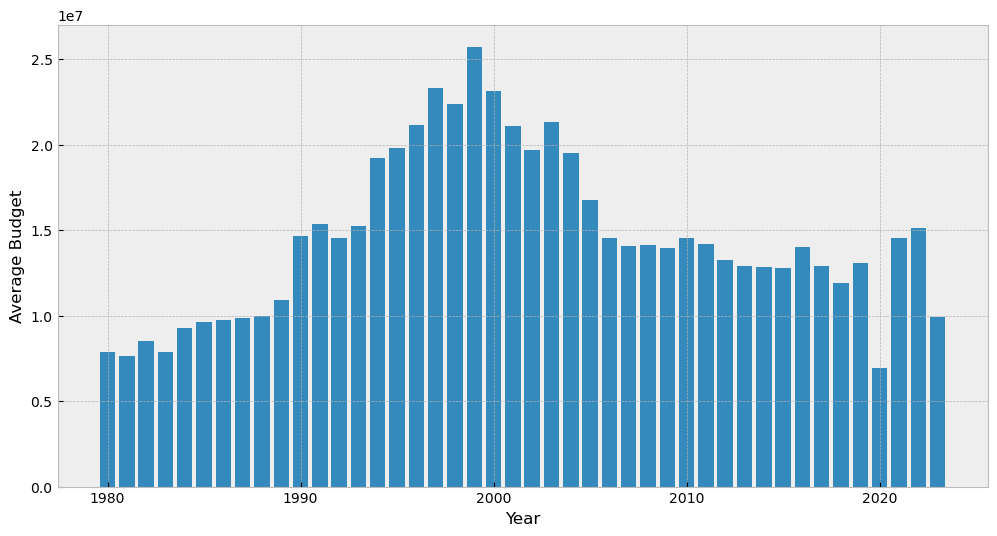

In [105]:
# Calculate the mean budget by year, excluding zeros
movie_all_clean_no_zero_budget = movie_all_clean_model_score[movie_all_clean_model_score['budget'] > 0]
budget_by_year = movie_all_clean_no_zero_budget.groupby('year')['budget'].mean()

# Create the bar plot for budget
plt.figure(figsize=(12, 6))
plt.bar(budget_by_year.index, budget_by_year.values)
plt.xlabel('Year')
plt.ylabel('Average Budget')
plt.show()

The utilization of the mean as a measure of central tendency for the given dataset is deemed inappropriate due to the presence of extreme values, which can significantly impact the mean. Consequently, the mode is considered a more representative measure in this case, allowing for a more accurate analysis of trends in the budget column over the years.

###### Mode Budget by Year for Movies with Non-Zero Budgets

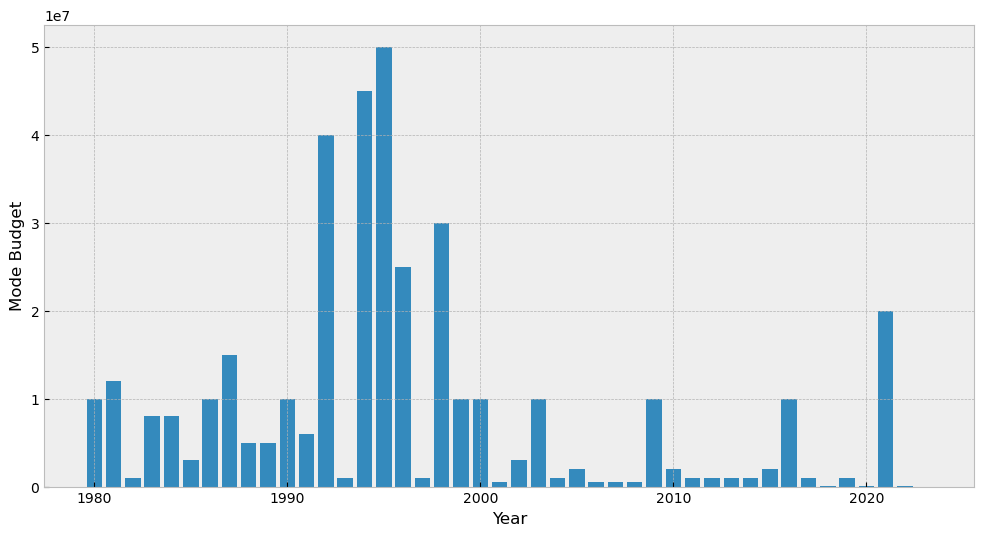

In [106]:
# Calculate the mode budget by year, excluding zeros
movie_all_clean_no_zero_budget = movie_all_clean_model_score[movie_all_clean_model_score['budget'] > 0]
budget_by_year = movie_all_clean_no_zero_budget.groupby('year')['budget'].agg(lambda x: x.mode()[0])

# Create the bar plot for budget
plt.figure(figsize=(12, 6))
plt.bar(budget_by_year.index, budget_by_year.values)
plt.xlabel('Year')
plt.ylabel('Mode Budget')
plt.show()


It is remarkable to see that in the 1990s there was a trend of high budgets for movies. This could be attributed to the high costs associated with special effects due to the lack of digital technologies during that time. Additionally, the significant social trend of going to the cinema may have contributed to the popularity of extravagant films that attracted the main audiences, resulting in high box office revenues.

###### Boxplot without zeros

Data description:
count    1.776300e+04
mean     1.454552e+07
std      3.099518e+07
min      1.000000e+00
25%      2.500000e+05
50%      3.000000e+06
75%      1.500000e+07
max      1.000000e+09
Name: budget, dtype: float64
Number of zeros: 0
Percentage of zeros: 0.0 %
Interquartile range: 14750000.0
Lower bound: -21875000.0
Upper bound: 37125000.0
Number of outliers: 1927
Percentage of outliers: 10.85 %
Percentage of missing values: 0.0 %


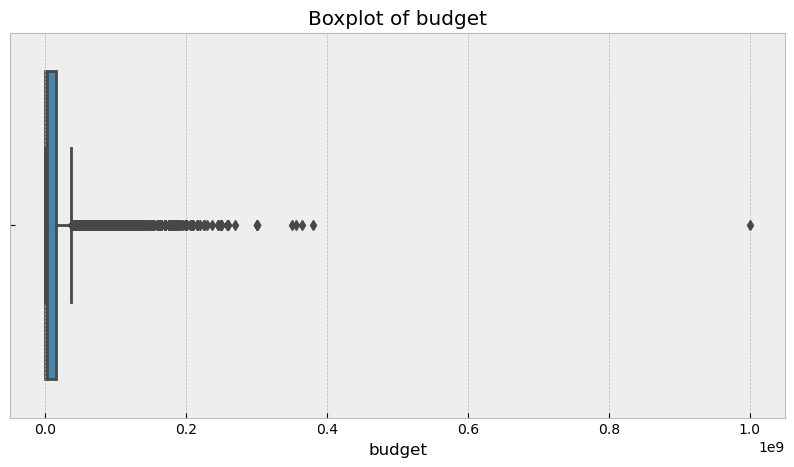

In [107]:
boxplot_analysis(movie_all_clean_no_zero_budget ['budget'])

Upon comparing the two boxplots, significant differences emerge in the data distributions when zero values are removed versus when they are included.

For the dataset without zero values, the mean budget is approximately 14.55 million, with a standard deviation of $30.995 million. The interquartile range (IQR) spans from $250,000 to $15 million, indicating a wide range of budgets for films. Outliers account for 10.85% of the data points, which could be indicative of exceptionally high or low budgets within the dataset.

In [108]:
budget_info = column_info(movie_all_clean_model_score['budget'])
print(budget_info)

Length of column: 156522
Number of unique values: 2496
Number of missing values: 0
Number of zeros: 138759
Percentage of zeros: 88.65%
The range of values in the column is: 0 - 999999999
{'len': 156522, 'unique': 2496, 'num_missing': 0, 'num_zeros': 138759, 'pct_zeros': 88.65}


###### Binning proces

In [109]:
# Filter out the data that is not zero
non_zero_budget = movie_all_clean_model_score[movie_all_clean_model_score['budget'] > 0]['budget']

# Calculate percentiles
percentiles = np.percentile(non_zero_budget, [0, 33.33, 66.67, 100])

# Create labels for bins
labels = ['no.info', 'low', 'medium', 'high']  # Change 'zero' to 'no.info'

# Apply binning to the column
movie_all_clean_model_score['budget_binned'] = pd.cut(movie_all_clean_model_score['budget'], bins=[0] + list(percentiles), labels=labels, include_lowest=True)

# Show the distribution of the bins
print(movie_all_clean_model_score['budget_binned'].value_counts())



no.info    138823
high         5921
medium       5907
low          5871
Name: budget_binned, dtype: int64


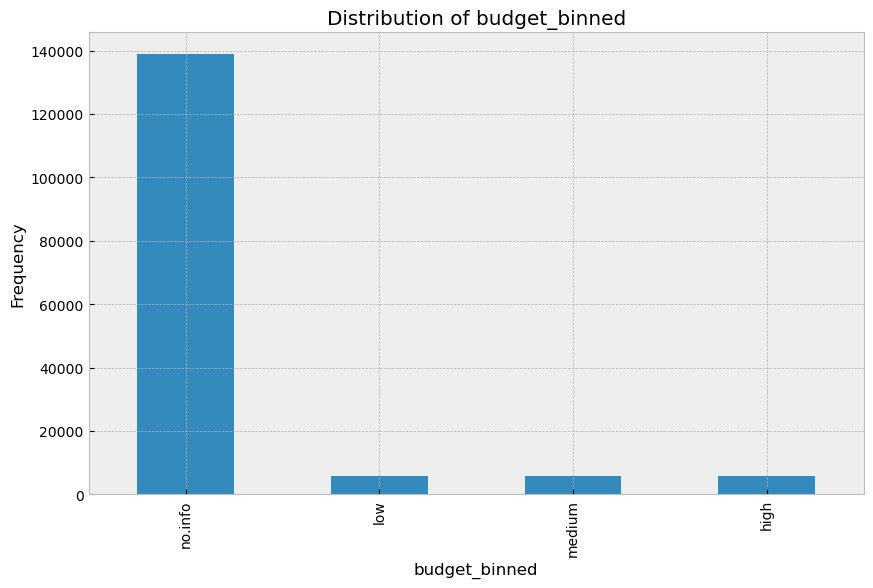

In [110]:
plot_column_counts('budget_binned', movie_all_clean_model_score)

###### Visualizations without no.info values.

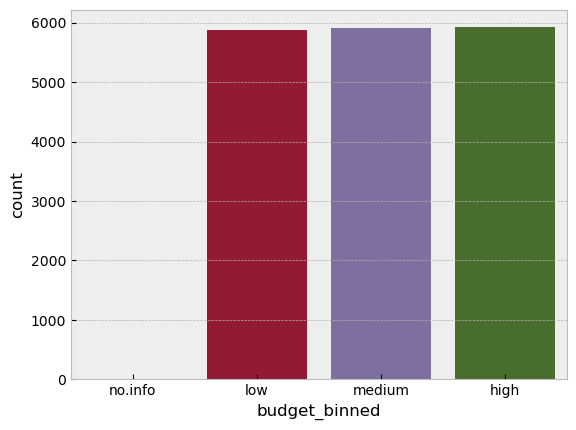

In [111]:
def plot_column_counts(column, df):
    plt.figure()
    sns.countplot(data=df, x=column)
    plt.xlabel(column)
    plt.ylabel('count')
    plt.show()

# Filtrar el DataFrame para excluir las filas con 'no.info' en la columna 'revenue_binned'
movie_all_clean_without_no_info_budget = movie_all_clean_model_score[movie_all_clean_model_score['budget_binned'] != 'no.info']

# Crear el gráfico de barras para la columna 'revenue_binned' sin 'no.info'
plot_column_counts('budget_binned', movie_all_clean_without_no_info_budget)


The distribution of budget data is almost evenly spread across the three categories. The fact that there is almost an equal distribution of budget data in the three categories is good for our analysis. It means that we have a relatively balanced representation of budget data across different budget levels, allowing us to make more accurate comparisons and draw more meaningful insights. It also indicates that the binning method used to categorize budget data was effective in creating evenly distributed categories.

######  Analysis budged binnes vs year, vote count binned, popularity binned y vote average binned

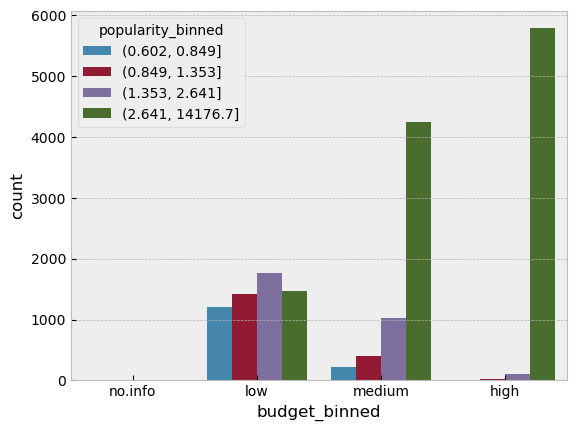

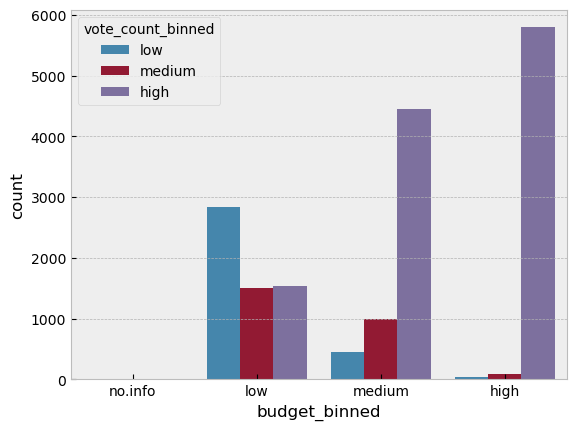

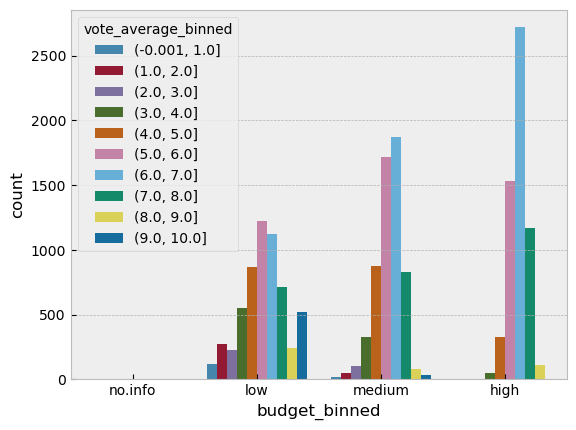

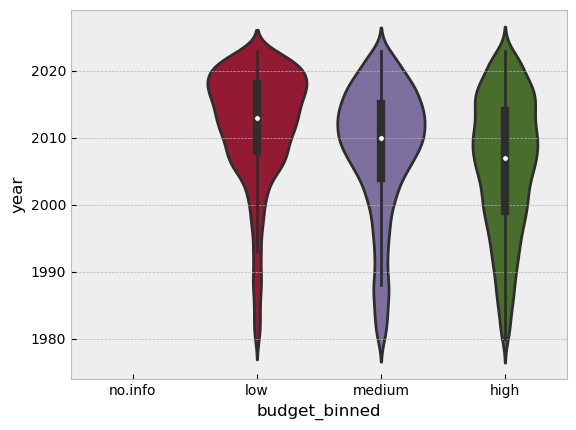

In [112]:
def bar_plot(df, x_col, y_col):
    plt.figure()
    sns.countplot(data=df, x=x_col, hue=y_col)
    plt.xlabel(x_col)
    plt.ylabel('count')
    plt.legend(title=y_col, loc='upper left')
    plt.show()

# Bar plot of 'budget_binned' vs 'popularity_binned'
bar_plot(movie_all_clean_without_no_info_budget, 'budget_binned', 'popularity_binned')

# Bar plot of 'budget_binned' vs 'vote_count_binned'
bar_plot(movie_all_clean_without_no_info_budget, 'budget_binned', 'vote_count_binned')

# Bar plot of 'budget_binned' vs 'vote_average_binned'
bar_plot(movie_all_clean_without_no_info_budget, 'budget_binned', 'vote_average_binned')

# Violin plot of 'budget_binned' vs 'year'
plt.figure()
sns.violinplot(data=movie_all_clean_without_no_info_budget, x='budget_binned', y='year')
plt.xlabel('budget_binned')
plt.ylabel('year')
plt.show()


Through the analysis of these graphs, we can derive significant insights into the impact of the budget on various movie metrics.

Firstly, we can observe that movies with medium and high budgets tend to receive more attention from users. As the budget of a film increases, it garners a greater level of user engagement. This is evident in the analysis of the vote count, where higher-budget movies receive more votes, while low-budget films predominantly have a lower vote count.

The vote average graph is particularly interesting, as it demonstrates that the most popular films and those with the highest vote counts are not necessarily the ones with the highest ratings. As more people vote, the scores tend to become more standardized. The predominant rating range for high-budget films lies between 5 and 7, which is similar to that of medium-budget films.

Lastly, low-budget films exhibit a higher proportion of maximum scores. This suggests that, although these films may not receive the same level of attention or votes as their higher-budget counterparts, they can still achieve exceptional ratings among those who do engage with them. This is also because when there are fewer voters, the high-score values are more prominently highlighted.

##### revenue column

###### Overview

In [113]:
movie_all_clean_model_score['revenue'].info()

<class 'pandas.core.series.Series'>
Int64Index: 156522 entries, 0 to 532781
Series name: revenue
Non-Null Count   Dtype
--------------   -----
156522 non-null  int64
dtypes: int64(1)
memory usage: 2.4 MB


In [114]:
revenue_info = column_info(movie_all_clean_model_score['revenue'])
print(revenue_info)

Length of column: 156522
Number of unique values: 11743
Number of missing values: 0
Number of zeros: 143398
Percentage of zeros: 91.62%
The range of values in the column is: 0 - 2920357254
{'len': 156522, 'unique': 11743, 'num_missing': 0, 'num_zeros': 143398, 'pct_zeros': 91.62}


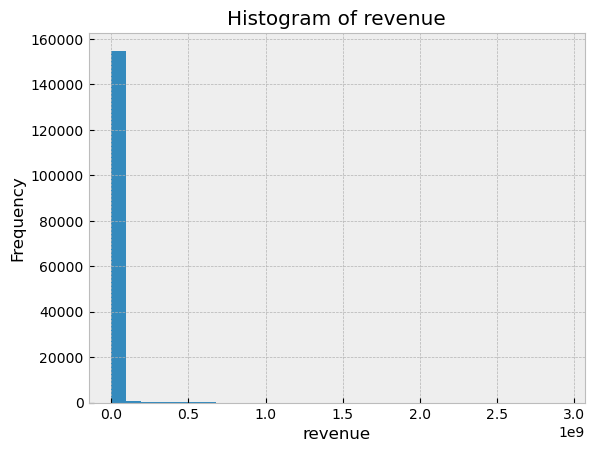

In [115]:
create_histograms(movie_all_clean_model_score,['revenue'], bins=30)

###### Budget vs revenue Zero Values 

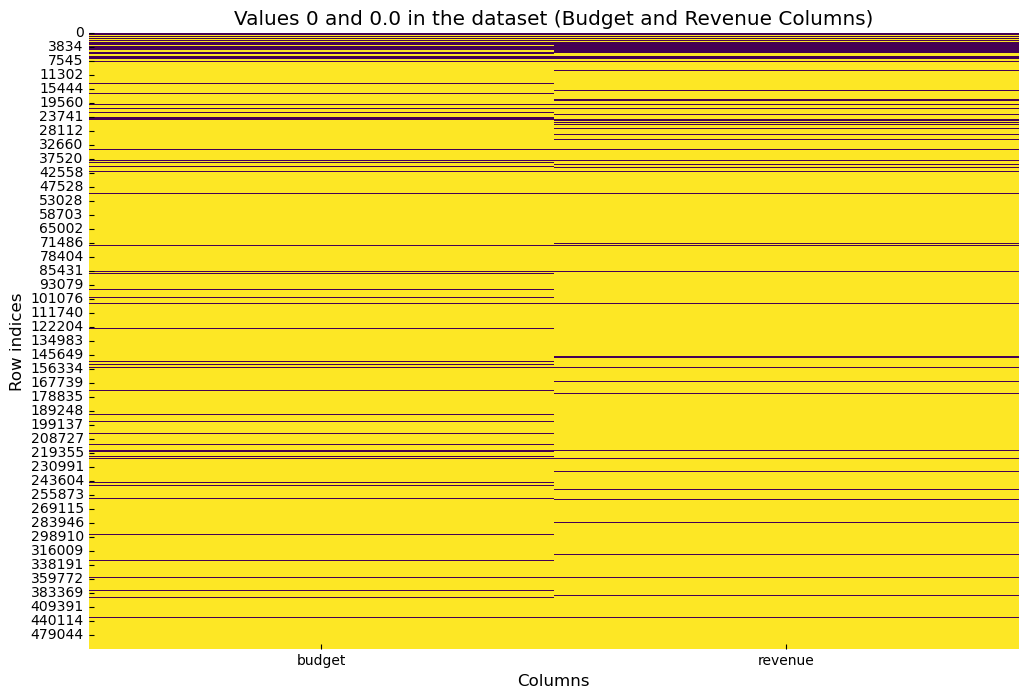

In [116]:
# Filter the dataframe to keep only the 'budget' and 'revenue' columns
df_filtered = movie_all_clean_model_score[['budget', 'revenue']]

# Create a boolean mask for values equal to 0 or 0.0
mask = (df_filtered == 0) | (df_filtered == 0.0)

# Visualize the boolean mask using a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(mask, cbar=False, cmap='viridis')
plt.xlabel('Columns')
plt.ylabel('Row indices')
plt.title('Values 0 and 0.0 in the dataset (Budget and Revenue Columns)')
plt.show()


In this analysis, the goal was to examine the relationship between missing values in the 'budget' column and missing values in the 'revenue' column. The heatmap visualization suggests that, to a large extent, there is a correlation between missing values in both columns. However, it is important to note that this relationship is not absolute. There are instances where missing values in one column do not necessarily correspond to missing values in the other column. Consequently, it would be imprudent to assume a complete dependence between missing values in the 'budget' and 'revenue' columns. Further investigation may be needed to understand the underlying factors contributing to these discrepancies.






###### Outliers

Data description:
count    1.565220e+05
mean     4.255962e+06
std      4.198305e+07
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.920357e+09
Name: revenue, dtype: float64
Number of zeros: 143398
Percentage of zeros: 91.62 %
Interquartile range: 0.0
Lower bound: 0.0
Upper bound: 0.0
Number of outliers: 13124
Percentage of outliers: 8.38 %
Percentage of missing values: 0.0 %


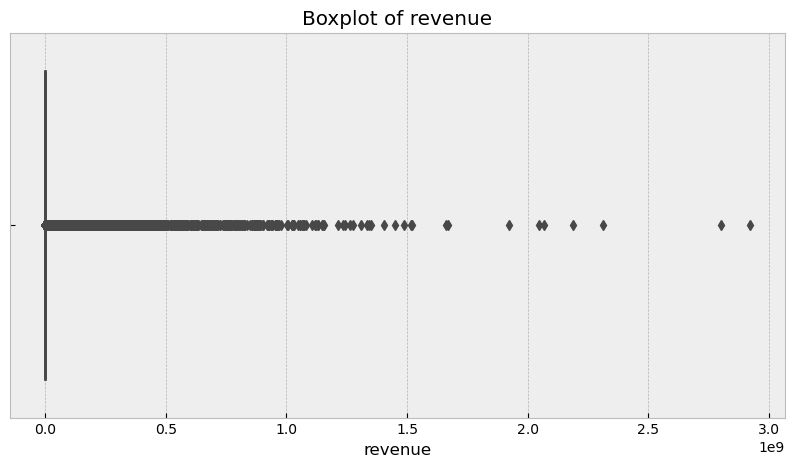

In [117]:
boxplot_analysis(movie_all_clean_model_score['revenue'])

The data reveals that a significant proportion of the 'revenue' column contains zero values (143,398 instances), which results in an interquartile range of 0. This suggests that the majority of the dataset's revenue values are concentrated at or around 0, which may impact the mean and other measures of central tendency. 
A high standard deviation indicates that the revenue values are widely dispersed around the mean ($4,255,962). This suggests that there is a significant variation in the revenues of the movies in the dataset.
However, it is essential to note that the presence of numerous zero values and outliers can significantly impact the standard deviation. As a result, the calculated standard deviation may not provide an accurate representation of the dataset's true dispersion.

###### Top revenue movies

In [118]:
top_revenue_movies = movie_all_clean_model_score.nlargest(10, 'revenue')
top_revenue_movies = top_revenue_movies[['title', 'year', 'original_language', 'popularity', 'vote_average', 'budget', 'revenue']]
print(top_revenue_movies)

                               title  year original_language  popularity  \
9383                          Avatar  2009                en     356.760   
118736             Avengers: Endgame  2019                en     150.611   
38621       Avatar: The Way of Water  2022                en    6019.160   
356                          Titanic  1997                en     154.505   
61423   Star Wars: The Force Awakens  2015                en      68.585   
118737        Avengers: Infinity War  2018                en     309.749   
295675       Spider-Man: No Way Home  2021                en     476.278   
59600                 Jurassic World  2015                en      93.394   
183127                 The Lion King  2019                en     118.892   
11174                   The Avengers  2012                en     181.156   

        vote_average     budget     revenue  
9383           7.569  237000000  2920357254  
118736         8.267  356000000  2799439100  
38621          7.727  350

###### Zero Values

###### Average revenue by Year for Movies with Non-Zero revenue

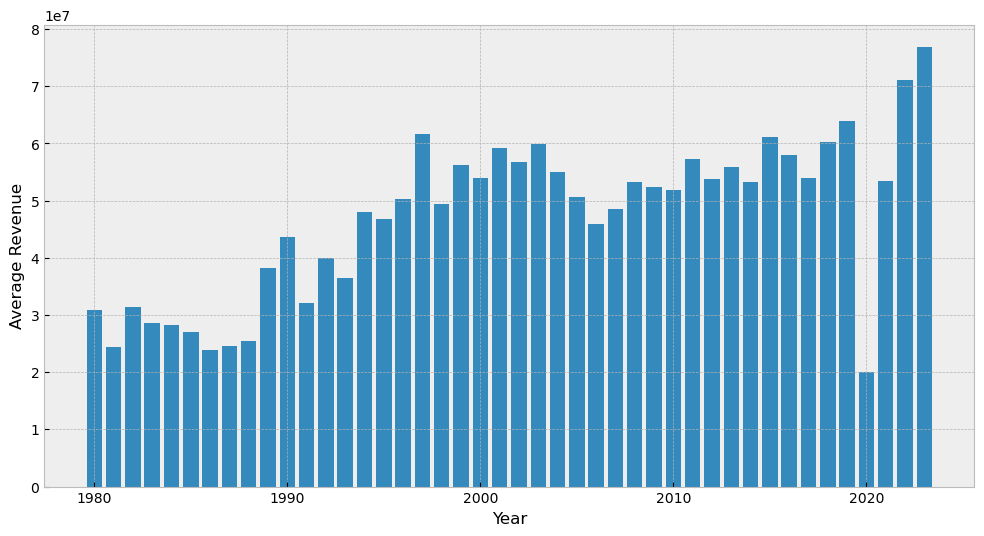

In [119]:
# Calculate the mean revenue by year, excluding zeros
movie_all_clean_no_zero_revenue = movie_all_clean_model_score[movie_all_clean_model_score['revenue'] > 0]
revenue_by_year = movie_all_clean_no_zero_revenue.groupby('year')['revenue'].mean()

# Create the bar plot for revenue
plt.figure(figsize=(12, 6))
plt.bar(revenue_by_year.index, revenue_by_year.values)
plt.xlabel('Year')
plt.ylabel('Average Revenue')
plt.show()

###### Mode revenue by Year for Movies with Non-Zero revenue

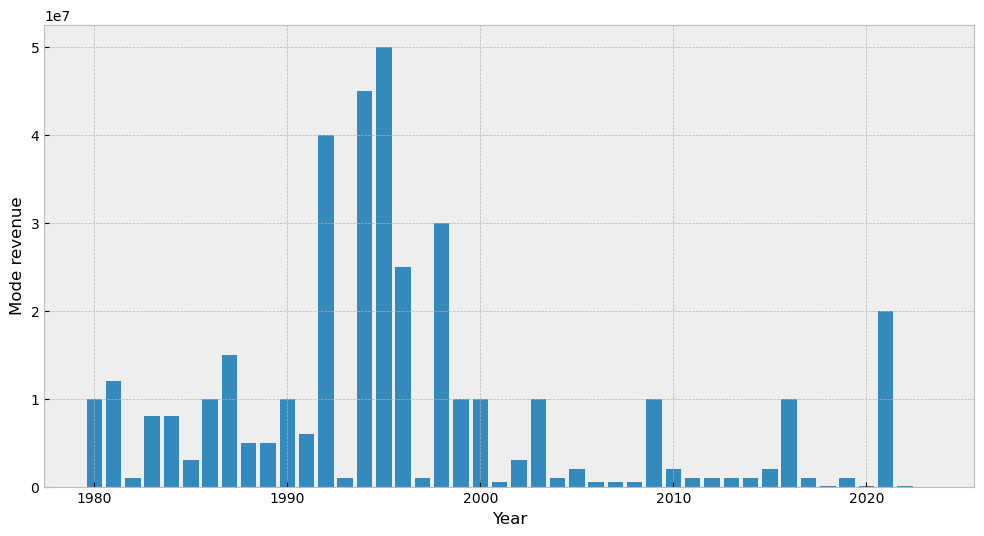

In [120]:
# Calculate the mode revenue by year, excluding zeros
movie_all_clean_no_zero_revenue = movie_all_clean_model_score[movie_all_clean_model_score['revenue'] > 0]
revenue_by_year = movie_all_clean_no_zero_revenue.groupby('year')['revenue'].agg(lambda x: x.mode()[0])

# Create the bar plot for budget
plt.figure(figsize=(12, 6))
plt.bar(budget_by_year.index, budget_by_year.values)
plt.xlabel('Year')
plt.ylabel('Mode revenue')
plt.show()

When comparing the graphs of mean movie revenue and mode movie revenue per year, it becomes evident that extreme values can significantly impact the data. Thus, it is suggested that the mode is a better metric to describe this data. The analysis showed that the high-budget movies of the 1990s were directly related to the high revenues generated during that period. This finding supports the conclusions drawn from the budget analysis, where a trend of high budgets for movies in the 1990s was observed.

###### Boxplot without zeros

Data description:
count    1.312400e+04
mean     5.075829e+07
std      1.366093e+08
min      1.000000e+00
25%      7.001372e+05
50%      6.751916e+06
75%      3.680945e+07
max      2.920357e+09
Name: revenue, dtype: float64
Number of zeros: 0
Percentage of zeros: 0.0 %
Interquartile range: 36109313.25
Lower bound: -53463832.625
Upper bound: 90973420.375
Number of outliers: 1817
Percentage of outliers: 13.84 %
Percentage of missing values: 0.0 %


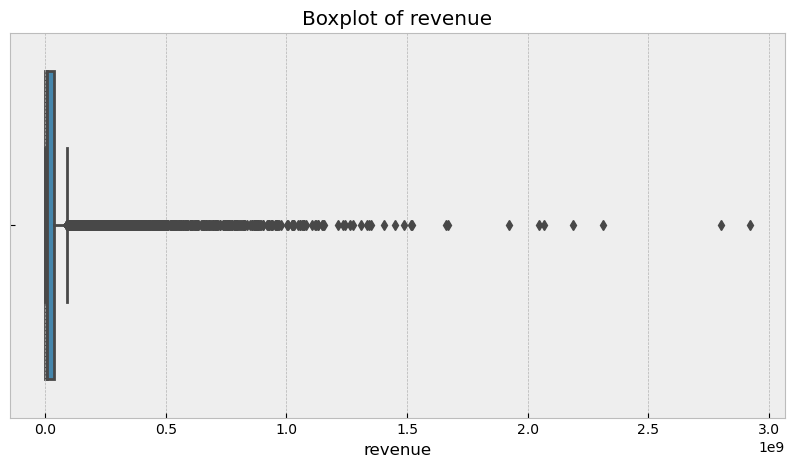

In [121]:
boxplot_analysis(movie_all_clean_no_zero_revenue ['revenue'])

After removing all zero values from the dataset, we can now observe that the standard deviation is 136,609,300, indicating a high level of variability in the revenue data.
The minimum revenue is 1, while the maximum revenue reaches 2,920,357,000.
The interquartile range (IQR) is 36,109,313.25, which demonstrates the spread of the middle 50% of the revenue data. The lower bound is -53,463,832.625, and the upper bound is 90,973,420.375. There are 1,817 outliers, accounting for 13.84% of the data. This suggests that a considerable number of movies have revenue figures significantly different from the majority.

###### Binning proces

In [122]:
# Filter out zero values
non_zero_revenue = movie_all_clean_model_score[movie_all_clean_model_score['revenue'] > 0]['revenue']

# Calculate percentiles
percentiles = np.percentile(non_zero_revenue, [0, 33.33, 66.67, 100])

# Create labels for the bins
labels = ['no.info', 'low', 'medium', 'high']  # Change 'zero' to 'no.info'

# Apply binning to the column
movie_all_clean_model_score['revenue_binned'] = pd.cut(movie_all_clean_model_score['revenue'], bins=[0] + list(percentiles), labels=labels, include_lowest=True)

# Show the distribution of the bins
print(movie_all_clean_model_score['revenue_binned'].value_counts())



no.info    143428
medium       4376
high         4374
low          4344
Name: revenue_binned, dtype: int64


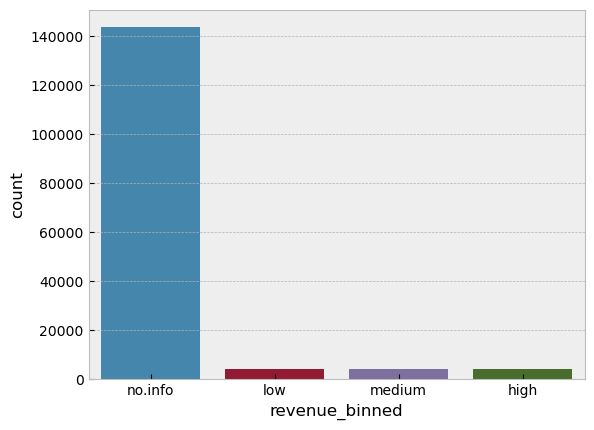

In [123]:
plot_column_counts('revenue_binned', movie_all_clean_model_score)

###### Visualizations without no.info values.

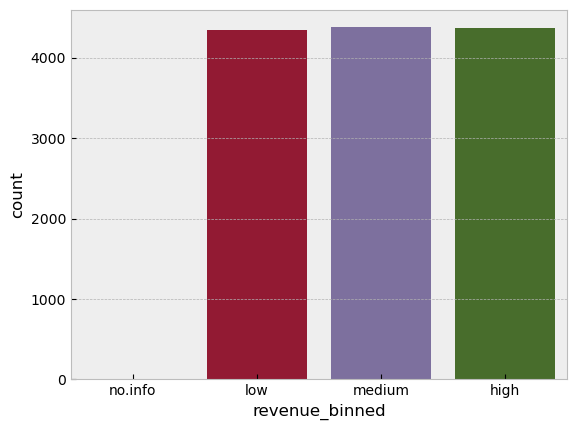

In [124]:
# Filter the DataFrame to exclude rows with 'no.info' in the 'revenue_binned' column
movie_all_clean_without_no_info_revenue = movie_all_clean_model_score[movie_all_clean_model_score['revenue_binned'] != 'no.info']

# Create the bar chart for the 'revenue_binned' column without 'no.info'
plot_column_counts('revenue_binned', movie_all_clean_without_no_info_revenue)



The revenue distribution follows a similar pattern as the budget column. The data is almost evenly spread across the three categories, indicating a balanced representation of revenue data across different revenue levels. This allows for more accurate comparisons and meaningful insights. The effective binning method used to categorize revenue data created evenly distributed categories, as observed in the budget analysis.

######  Analysis revenue binned vs budged binnes, year, vote count binned, popularity binned y vote average binned

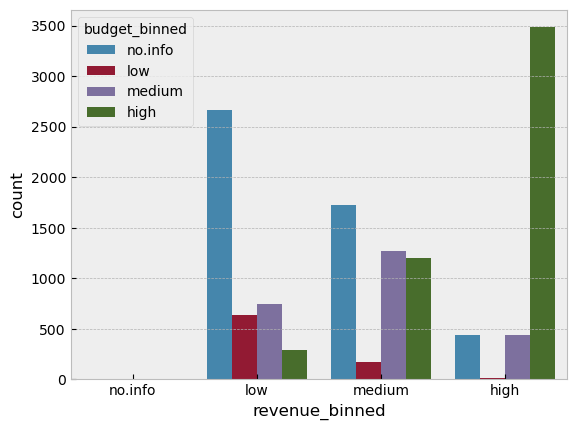

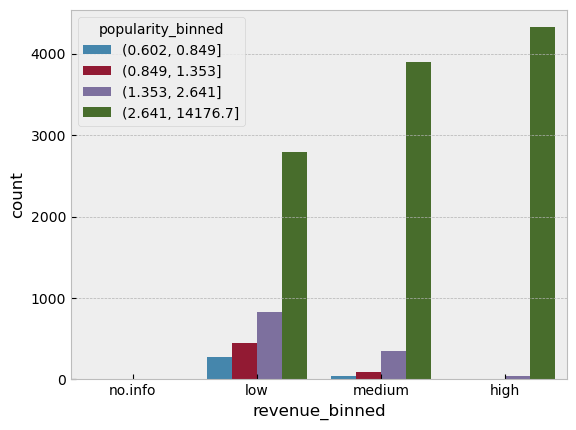

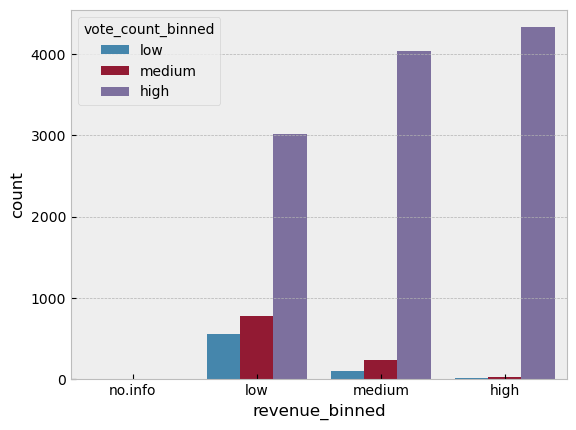

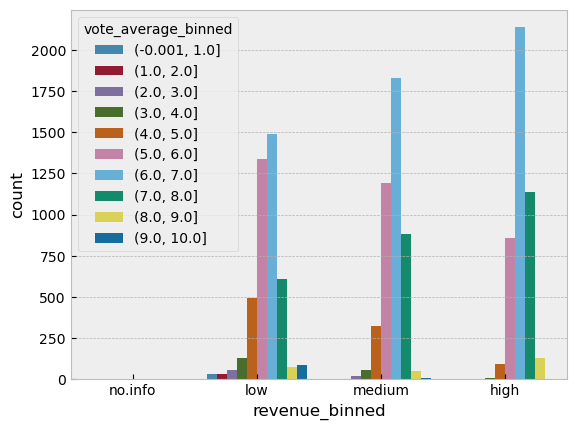

In [125]:
# Bar plot of 'revenue_binned' vs 'budget_binned'
bar_plot(movie_all_clean_without_no_info_revenue, 'revenue_binned', 'budget_binned')

# Bar plot of 'revenue_binned' vs 'popularity_binned'
bar_plot(movie_all_clean_without_no_info_revenue, 'revenue_binned', 'popularity_binned')

# Bar plot of 'revenue_binned' vs 'vote_count_binned'
bar_plot(movie_all_clean_without_no_info_revenue, 'revenue_binned', 'vote_count_binned')

# Bar plot of 'revenue_binned' vs 'vote_average_binned'
bar_plot(movie_all_clean_without_no_info_revenue, 'revenue_binned', 'vote_average_binned')



The analysis reveals a directly proportional relationship between the revenue and budget columns. High-revenue movies predominantly have higher budgets, while low-revenue films tend to have lower budgets. This indicates that investment in a movie's production often translates into higher earnings.

When comparing the revenue and popularity columns, it is observed that movies with revenue information are generally highly popular. The distribution of popularity is fairly equitable, with high-revenue films being slightly more popular than those with lower revenues. The vote count column exhibits a similar relationship with the revenue column as with the popularity column. In high-revenue movies, a high vote count and popularity are nearly always observed.

Lastly, the relationship between average votes and a movie's revenue reveals that central tendencies predominate across all three columns. This suggests that the factors of revenue, popularity, and vote count are interconnected and that they influence each other in a movie's overall success.

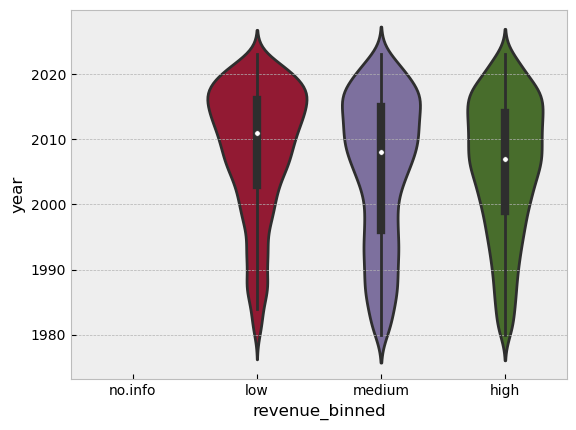

In [126]:
# Violin plot of 'revenue_binned' vs 'year'
plt.figure()
sns.violinplot(data=movie_all_clean_without_no_info_revenue, x='revenue_binned', y='year')
plt.xlabel('revenue_binned')
plt.ylabel('year')
plt.show()

##### runtime column

###### Overview

In [127]:
movie_all_clean_model_score['runtime_binned'].info()

<class 'pandas.core.series.Series'>
Int64Index: 156522 entries, 0 to 532781
Series name: runtime_binned
Non-Null Count   Dtype 
--------------   ----- 
156522 non-null  object
dtypes: object(1)
memory usage: 2.4+ MB


In [128]:
runtime_info = column_info(movie_all_clean_model_score['runtime'])
print(runtime_info)

Length of column: 156522
Number of unique values: 382
Number of missing values: 0
Number of zeros: 13186
Percentage of zeros: 8.42%
The range of values in the column is: 0 - 51420
{'len': 156522, 'unique': 382, 'num_missing': 0, 'num_zeros': 13186, 'pct_zeros': 8.42}


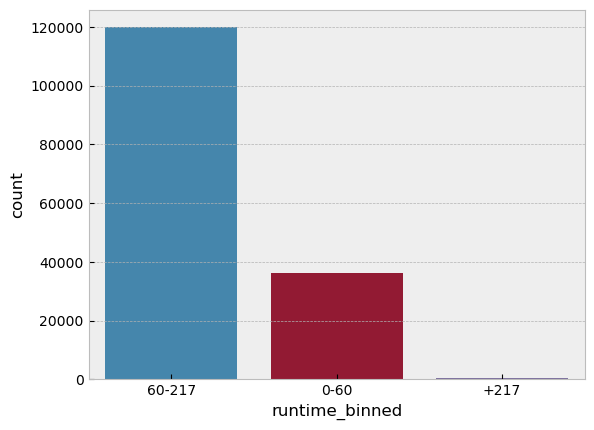

In [129]:
plot_column_counts('runtime_binned', movie_all_clean_model_score)

In [130]:
# Calcular el porcentaje y número de películas en cada categoría de 'runtime_binned'
counts = movie_all_clean_model_score['runtime_binned'].value_counts()
percentages = counts / len(movie_all_clean_model_score) * 100

# Imprimir los resultados
for category, count, percentage in zip(counts.index, counts, percentages):
    print(f"{category}: {count} ({percentage:.2f}%)")


60-217: 119860 (76.58%)
0-60: 36229 (23.15%)
+217: 433 (0.28%)


###### Outliers

Data description:
count    156522.000000
mean         81.595226
std         175.485310
min           0.000000
25%          69.000000
50%          90.000000
75%         102.000000
max       51420.000000
Name: runtime, dtype: float64
Number of zeros: 13186
Percentage of zeros: 8.42 %
Interquartile range: 33.0
Lower bound: 19.5
Upper bound: 151.5
Number of outliers: 27366
Percentage of outliers: 17.48 %
Percentage of missing values: 0.0 %


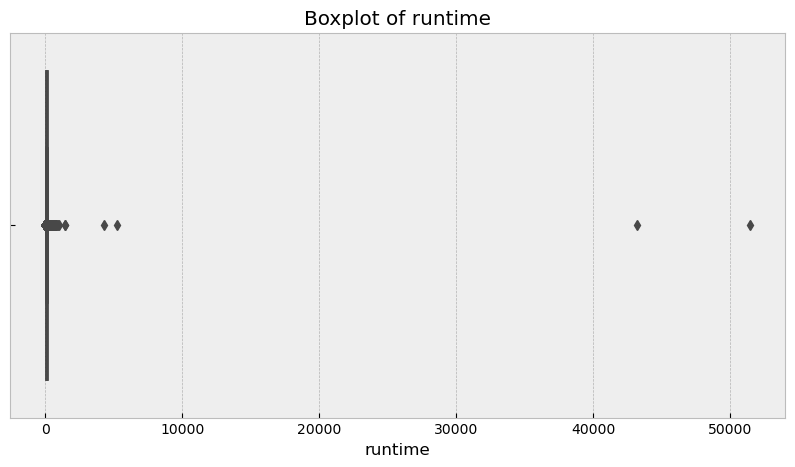

In [131]:
boxplot_analysis(movie_all_clean_model_score['runtime'])

The average runtime for films in the dataset is approximately 81.6 minutes, indicating that the typical film tends to be around an hour and 20 minutes in length. However, the standard deviation of 175.5 minutes suggests a significant variation in film runtime.

The majority of films have a runtime between 69 and 102 minutes, as indicated by the interquartile range (IQR) of 33 minutes. The lower and upper bounds are 19.5 and 151.5 minutes, respectively. Any data point outside of these bounds could be considered an outlier. In this dataset, there are 27,366 outliers, representing 17.48% of the total data.

It is important to note that the dataset contains 13,186 films with a runtime of 0 minutes, which could be a data entry error or missing data. The maximum runtime value of 51,420 minutes seems implausibly high, these extreme values should be taken into consideration when interpreting the data.

In conclusion, the dataset reveals a wide range of film runtimes, with the majority falling between 69 and 102 minutes. The presence of zero values and outliers in the data is significantly impacting the analysis.


###### Longest movies 

In [132]:
# Sort the DataFrame by runtime in descending order and select the top 5 rows
top_5_longest_movies = movie_all_clean_model_score.sort_values(by='runtime', ascending=False).head(5)

# Select the desired columns
columns = ['title', 'original_language', 'vote_average', 'year', 'runtime', 'budget']
top_5_longest_movies = top_5_longest_movies[columns]

# Display the result
print(top_5_longest_movies)


                        title original_language  vote_average  year  runtime  \
183214            物流Logistics                en           7.6  2012    51420   
109381               Ambiancé                sv           1.3  2020    43200   
54759   The Cure For Insomnia                en           3.5  1987     5220   
155580           #ALLMYMOVIES                en           7.5  2015     4320   
60872               The Clock                en           9.1  2010     1440   

        budget  
183214       0  
109381       0  
54759        0  
155580       0  
60872        0  


###### Analizar sin outliers y sin zeros

In [133]:
# Define a function to detect outliers using IQR method
def detect_outliers_iqr(data):
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return (data < lower_bound) | (data > upper_bound)

# Create a boolean mask for outliers and zeros in the 'runtime' column
outliers_mask = detect_outliers_iqr(movie_all_clean_model_score['runtime'])
zeros_mask = movie_all_clean_model_score['runtime'] == 0

# Create a DataFrame with only the outliers and zeros in 'runtime'
runtime_outliers_and_zeros = movie_all_clean_model_score[outliers_mask | zeros_mask]

# Create a DataFrame without the outliers and zeros in 'runtime'
runtime_no_outliers_no_zeros = movie_all_clean_model_score[~(outliers_mask | zeros_mask)]



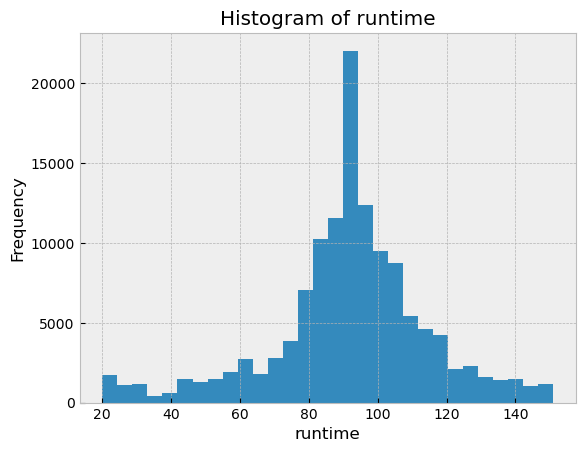

In [134]:
create_histograms(runtime_no_outliers_no_zeros,['runtime'], bins=30)

Data description:
count    129156.000000
mean         91.573663
std          23.090804
min          20.000000
25%          83.000000
50%          92.000000
75%         104.000000
max         151.000000
Name: runtime, dtype: float64
Number of zeros: 0
Percentage of zeros: 0.0 %
Interquartile range: 21.0
Lower bound: 51.5
Upper bound: 135.5
Number of outliers: 12298
Percentage of outliers: 9.52 %
Percentage of missing values: 0.0 %


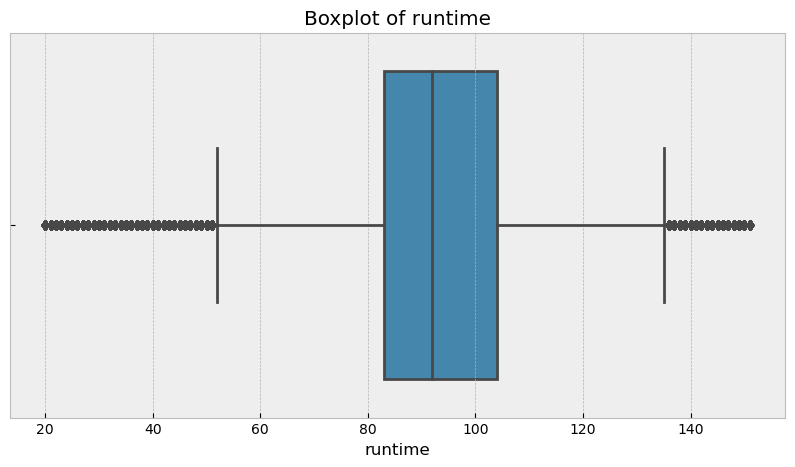

In [135]:
boxplot_analysis(runtime_no_outliers_no_zeros['runtime'])

In the analysis of movie runtime, it is observed that the average duration is approximately 91.57 minutes. The duration of most movies falls within an interquartile range of 21 minutes, from 83 to 104 minutes. This indicates that movie durations tend to vary moderately around the mean.

9.52% of the data are classified as outliers, that is, movies with a very short or very long duration compared to the majority. These outliers may be the result of differences in movie genres, directing styles, or the narrative structure in individual movies. Despite these outliers, the majority of movies have a duration that falls within an expected range, allowing viewers to anticipate the typical duration of a movie before watching it.

###### Binning proces 

El binning proces de esta columna se hace en el punto 3.2.2.4 Analysis vote average. 

Hemos visto que hay muy pocos datos en la categoria <217 y practicamente son valores extremos que afectan al analisis de los datos así que decidimos eliminarlos. 

In [136]:
final_df = runtime_no_outliers_no_zeros


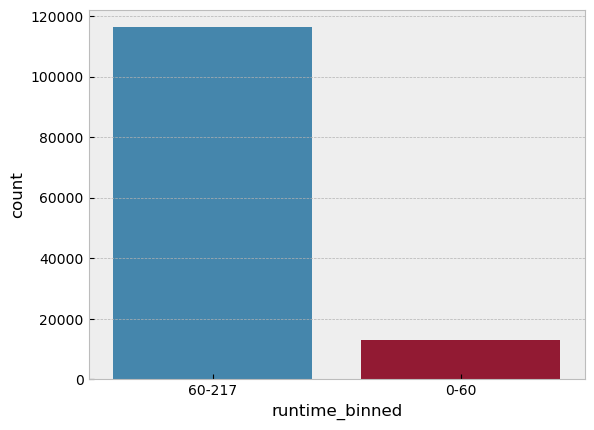

In [137]:
plot_column_counts('runtime_binned', final_df)

We are only keeping the values that fall between 60 and 217.

In [138]:
final_df = final_df[final_df['runtime_binned'] == '60-217']


###### Analysis runtime with all the other colums 

<Figure size 640x480 with 0 Axes>

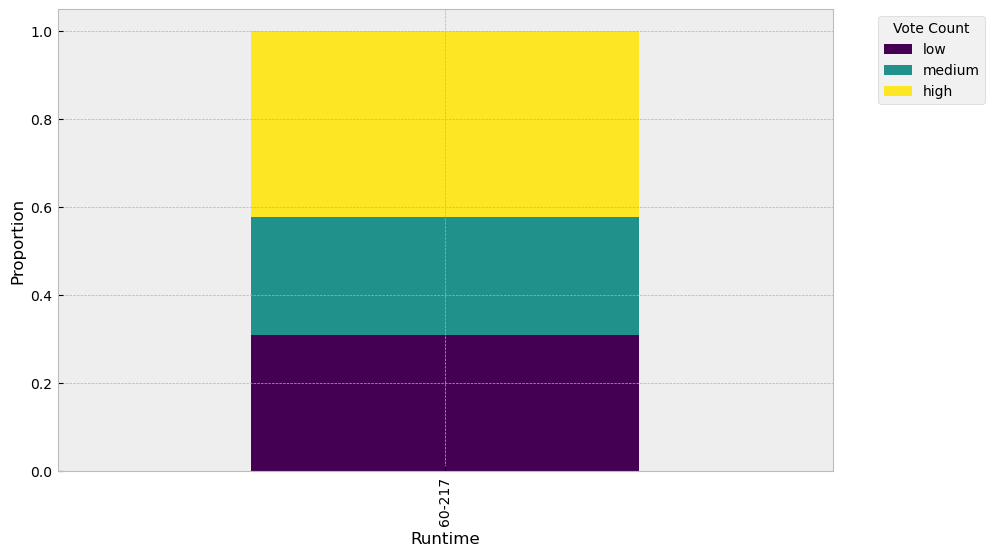

<Figure size 640x480 with 0 Axes>

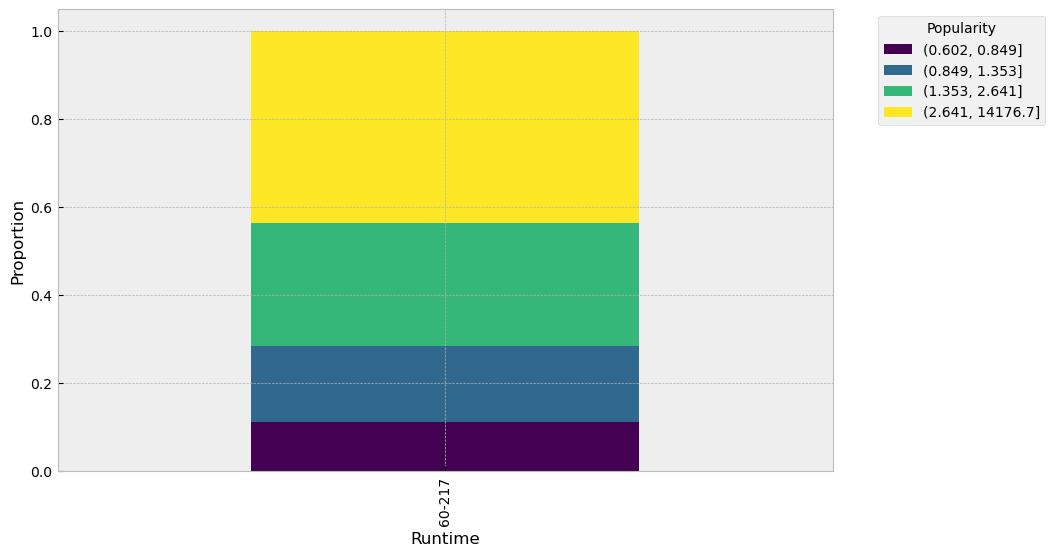

<Figure size 640x480 with 0 Axes>

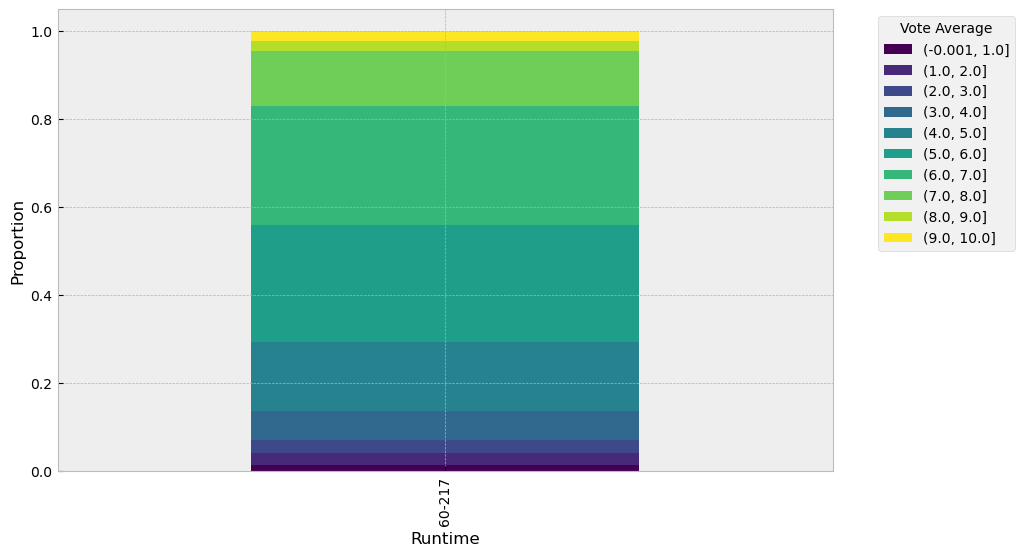

<Figure size 640x480 with 0 Axes>

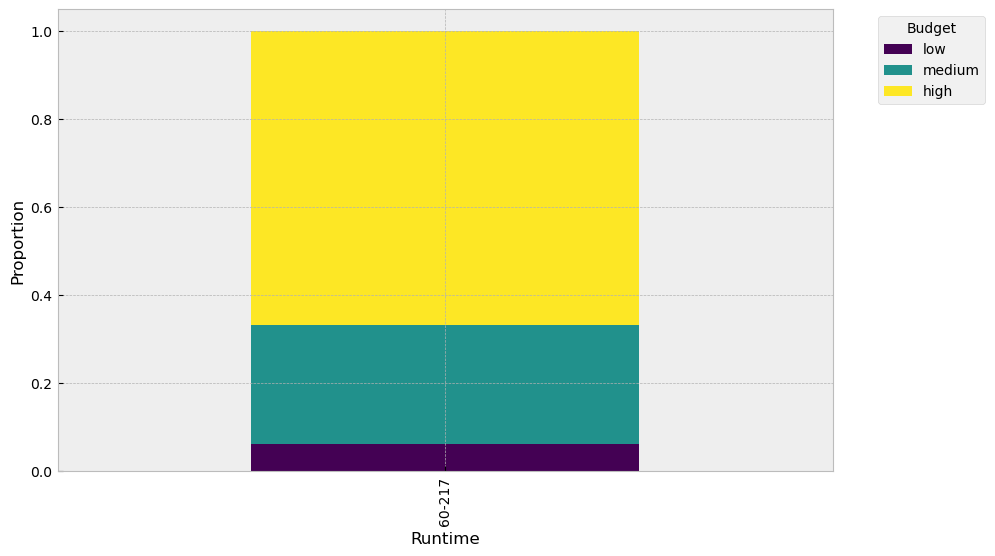

<Figure size 640x480 with 0 Axes>

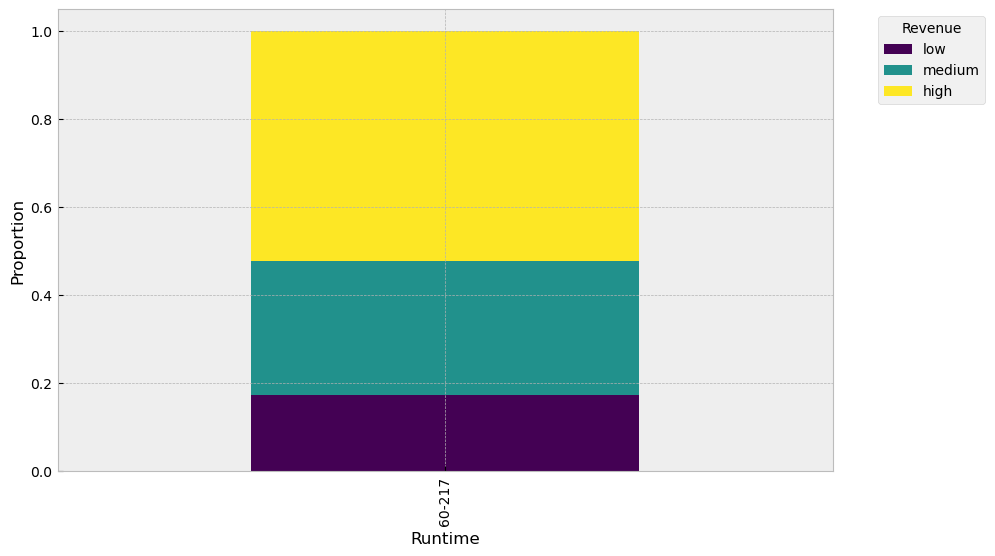

<Figure size 640x480 with 0 Axes>

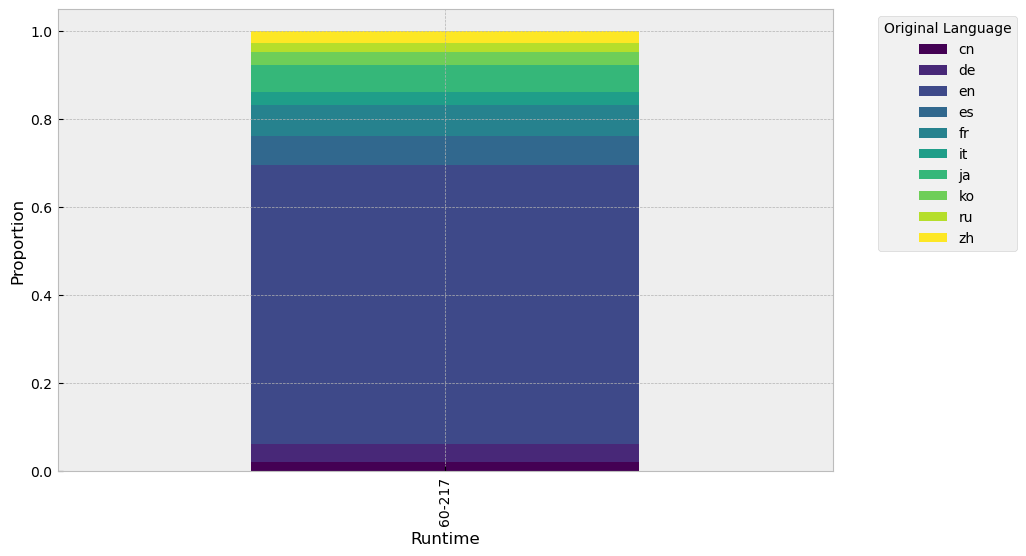

In [139]:
# Filter the top 10 most frequent original_language in the runtime column
top_10_languages = final_df['original_language'].value_counts().head(10).index
final_df_top_languages = final_df[final_df['original_language'].isin(top_10_languages)]

# Filter rows without "no.info" in budget_binned and revenue_binned
filtered_final_df = final_df_top_languages[(final_df_top_languages['budget_binned'] != 'no.info') & (final_df_top_languages['revenue_binned'] != 'no.info')]

# Calculate normalized contingency tables
normalized_runtime_vote_count = pd.crosstab(final_df_top_languages['runtime_binned'], final_df_top_languages['vote_count_binned'], normalize='index')
normalized_runtime_popularity = pd.crosstab(final_df_top_languages['runtime_binned'], final_df_top_languages['popularity_binned'], normalize='index')
normalized_runtime_vote_average = pd.crosstab(final_df_top_languages['runtime_binned'], final_df_top_languages['vote_average_binned'], normalize='index')
normalized_runtime_original_language = pd.crosstab(final_df_top_languages['runtime_binned'], final_df_top_languages['original_language'], normalize='index')

# Calculate normalized contingency tables without "no.info"
normalized_runtime_budget_filtered = pd.crosstab(filtered_final_df['runtime_binned'], filtered_final_df['budget_binned'], normalize='index')
normalized_runtime_revenue_filtered = pd.crosstab(filtered_final_df['runtime_binned'], filtered_final_df['revenue_binned'], normalize='index')

# Stacked bar plot for runtime_binned vs vote_count_binned
stacked_bar_plot(normalized_runtime_vote_count, 'Runtime', 'Vote Count')

# Stacked bar plot for runtime_binned vs popularity_binned
stacked_bar_plot(normalized_runtime_popularity, 'Runtime', 'Popularity')

# Stacked bar plot for runtime_binned vs vote_average_binned
stacked_bar_plot(normalized_runtime_vote_average, 'Runtime', 'Vote Average')

# Stacked bar plot for runtime_binned vs budget_binned without "no.info"
stacked_bar_plot(normalized_runtime_budget_filtered, 'Runtime', 'Budget')

# Stacked bar plot for runtime_binned vs revenue_binned without "no.info"
stacked_bar_plot(normalized_runtime_revenue_filtered, 'Runtime', 'Revenue')

# Stacked bar plot for runtime_binned vs original_language
stacked_bar_plot(normalized_runtime_original_language, 'Runtime', 'Original Language')



#### Categoric Columns

##### Functions

###### Info function 

In [140]:
def column_info_cat(column):
    info = {}
    info['len'] = len(column)  # Número total de valores en la columna.
    print(f"Length of column: {info['len']}")
    
    info['unique'] = len(column.unique())  # Número de valores únicos en la columna.
    print(f"Number of unique values: {info['unique']}")
    
    info['num_missing'] = column.isna().sum()  # Número de valores faltantes (NaN) en la columna.
    print(f"Number of missing values: {info['num_missing']}")
    
    # Calcular el porcentaje de valores faltantes en la columna y redondearlo.
    info['perc_missing'] = round((info['num_missing'] / info['len']) * 100, 2)
    print(f"Percentage of missing values: {info['perc_missing']}%")
    
    return info



###### Function Bar count plot

In [141]:
def plot_column_counts(column, df, figsize=(12, 6)):
    plt.figure(figsize=figsize)
    sns.countplot(data=df, x=column, order=df[column].value_counts().index)
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()



###### Function Bar plot

In [142]:
def create_bar_plot(df, column_list):
    for col in column_list:
        plt.figure()
        df[col].value_counts().plot(kind='bar')
        plt.xlabel(col)
        plt.ylabel('Frecuencia')
        plt.title(f'Gráfico de barras de {col}')
        plt.show()


###### Function missing value bar plot


In [143]:
def missing_data_bar_plot(df, missing_data_column, comparison_column):
    # Filter rows where 'missing_data_column' has a missing value (NaN)
    missing_data_df = df[df[missing_data_column].isna()]

    # Count the frequency of each category in the given column
    category_counts = missing_data_df[comparison_column].value_counts(dropna=False)

    # Sort the categories by their index (the values of comparison_column)
    sorted_category_counts = category_counts.sort_index()

    # Convert the categories to text strings
    category_labels = [str(category) for category in sorted_category_counts.index]

    # Create a bar chart for the distribution of missing values in 'missing_data_column'
    plt.bar(category_labels, sorted_category_counts.values)
    plt.xlabel(comparison_column)
    plt.title(f'Missing Data Frequency in {comparison_column}')
    plt.xticks(rotation=45)
    plt.show()



###### Function count items in column

En esta función he tenido problemas para hacer que la nueva columna tenga integers, porque cuando encontrava un NAN no lo podia pasar a integer y si lo dejava en float no havia problema. Pero al final lo he arreglado.

In [144]:
def count_items_in_column(df, column, new_column_name):
    # Create a new column in the DataFrame counting the number of items in each row of the given column
    df[new_column_name] = df[column].apply(lambda x: len(x.split(', ')) if isinstance(x, str) else x)

    # Find the maximum number of items in a row, excluding NaN values
    max_items = df[new_column_name].max(skipna=True)

    print(f"The maximum number of items in a row is: {max_items}")

    # Count the frequency of each number of items in the DataFrame
    item_counts = df[new_column_name].value_counts(dropna=False).sort_index()

    # Print the frequency of each number of items
    for num_items, count in item_counts.items():
        if pd.isna(num_items):
            print(f"Missing values: {count}")
        else:
            print(f"{int(num_items)} {column}(s): {count}")




###### Function count name frequencies

In [145]:
def count_name_frequencies(df, column):
    name_frequencies = {}
    
    for names in df[column]:
        if isinstance(names, str):
            name_list = names.split(', ')
            for name in name_list:
                if name in name_frequencies:
                    name_frequencies[name] += 1
                else:
                    name_frequencies[name] = 1
    
    return name_frequencies

###### Function display top names

In [146]:

def display_top_names(name_freq, top_n=10):
    # Sort names by frequency in descending order
    sorted_names = sorted(name_freq.items(), key=lambda x: x[1], reverse=True)

    # Print the top N names and their frequencies
    for i, (name, freq) in enumerate(sorted_names[:top_n]):
        print(f"{i + 1}. {name}: {freq}")

###### Function find rows with n items

In [147]:
def find_rows_with_n_items(df, column, n_items):
    """
    Find and display the rows of the DataFrame that have exactly n_items in the specified column.

    :param df: DataFrame containing a column with a count of items
    :param column: The name of the column with the item count
    :param n_items: The number of items to look for in the rows
    """
    # Filter the DataFrame to find rows with n_items in the specified column
    rows_with_n_items = df[df[column] == n_items]

    print(rows_with_n_items)


###### Function show movie details

In [148]:
def show_movie_details(df, id_movie):
    """
    Muestra las columnas 'title', 'runtime', 'popularity', 'vote_average' y 'year' para el id_movie dado.

    :param df: DataFrame que contiene las columnas mencionadas y una columna 'id_movie'
    :param id_movie: El ID de la película cuyos detalles se desean mostrar
    """
    # Filtrar el DataFrame para encontrar la fila con el id_movie dado
    movie_details = df[df['id_movie'] == id_movie]

    # Seleccionar las columnas 'title', 'runtime', 'popularity', 'vote_average' y 'year'
    columns_to_show = ['title','language_grouped', 'runtime', 'popularity', 'vote_average', 'year']
    movie_details = movie_details[columns_to_show]

    print(movie_details)

###### Function proces items to column

In [149]:
def process_items_to_column(row, source_column, id_column, max_items=3):
    items = row[source_column]
    
    if pd.isna(items):
        item1, item2, item3 = np.nan, np.nan, np.nan
    else:
        items_list = items.split(', ')
        
        if len(items_list) > max_items:
            item1, item2, item3 = items_list[:max_items]
        else:
            item1 = items_list[0] if len(items_list) > 0 else np.nan
            item2 = items_list[1] if len(items_list) > 1 else np.nan
            item3 = items_list[2] if len(items_list) > 2 else np.nan
            
    return pd.Series([row[id_column], item1, item2, item3])




###### Function create grouped bar plots

In [150]:
def create_grouped_bar_plots(df1, df2, id_column, count_column, new_count_column, binned_columns):
    """
    Create grouped bar plots for the relationship between a specified column and a list of binned columns.

    :param df1: First DataFrame (e.g., films_only_clean)
    :param df2: Second DataFrame (e.g., df_str_comp)
    :param id_column: Column name used to merge the two DataFrames (e.g., 'id_movie')
    :param count_column: Column name to count items in (e.g., 'str_comp_name')
    :param new_count_column: New column name to store the count of items (e.g., 'num_str_comps')
    :param binned_columns: List of binned columns to create bar plots (e.g., ['popularity_binned', 'vote_average_binned', 'runtime_binned', 'budget_binned'])
    """
    # Use the count_items_in_column function to create a new column
    count_items_in_column(df2, count_column, new_count_column)

    # Merge the two DataFrames on the id_column
    merged_df = df1.merge(df2, on=id_column)

    # Create a new column to group the new_count_column values
    def group_values(value):
        if pd.isna(value):
            return 'NaN'
        elif value <= 5:
            return str(int(value))
        else:
            return '+5'

    grouped_column = f'grouped_{new_count_column}'
    merged_df[grouped_column] = merged_df[new_count_column].apply(group_values)

    # Function to create bar plots for each binned column
    def create_bar_plots(df, column, grouped_column=grouped_column):
        category_counts = df.groupby(grouped_column)[column].value_counts(normalize=True).unstack().fillna(0)
        ax = category_counts.plot(kind='bar', figsize=(10, 6), rot=0)
        plt.xlabel(grouped_column)
        plt.ylabel('Proportion')
        plt.title(f'Relationship between {grouped_column} and {column}')
        plt.legend(title=column, bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.show()

    # Create bar plots for each binned column
    for column in binned_columns:
        create_bar_plots(merged_df, column)


#binned_columns = ['popularity_binned', 'vote_average_binned', 'runtime_binned', 'budget_binned']
#create_grouped_bar_plots(final_df, df_str_comp, 'id_movie', 'str_comp_name', 'num_str_comps', binned_columns)


##### original_title & title column

###### Overview

In [151]:
final_df

id_movie                                              title  \
0              2                                              Ariel   
1              3                                Shadows in Paradise   
2              5                                         Four Rooms   
3              6                                     Judgment Night   
4              8                   Life in Loops (A Megacities RMX)   
...          ...                                                ...   
531867   1114798            Die Bücher, die Hitler nicht verbrannte   
532041   1115307                  Guet-apens, des crimes invisibles   
532139   1115538                                        The Rapture   
532704   1116920                     Smosh Live: Presented by 5 Gum   
532724   1116997  Nøtteknekkeren - ballett i to akter fra Den No...   

                                           original_title original_language  \
0                                                   Ariel                fi   
1                                    Varjoja paratiisissa                fi   
2                                              Four Rooms                en   
3                                          Judgment Night                en   
4                        Life in Loops (A Megacities RMX)                en   
...                                                   ...               ...   
531867            Die Bücher, die Hitler nicht verbrannte                de   
532041                  Guet-apens, des crimes invisibles                fr   
532139                                        The Rapture                en   
532704                     Smosh Live: Presented by 5 Gum                en   
532724  Nøtteknekkeren - ballett i to akter fra Den No...                en   

                                                 overview release_date  \
0       Taisto Kasurinen is a Finnish coal miner whose...   1988-10-21   
1       An episode in the life of Nikander, a garbage ...   1986-10-17   
2       It's Ted the Bellhop's first night on the job....   1995-12-09   
3       While racing to a boxing match, Frank, Mike, J...   1993-10-15   
4       Timo Novotny labels his new project an experim...   2006-01-01   
...                                                   ...          ...   
531867                                                      2023-04-18   
532041  The result of an investigation that lasted sev...   2023-04-19   
532139  Evangelists Jack and Rexella Van Impe detail t...   1997-12-31   
532704  The very first Smosh live stream with sketches...   2016-08-27   
532724  The Nutcracker is about a young girl who recei...   2020-12-20   

        runtime  popularity  vote_count  vote_average  ...  \
0            73       6.736         247         7.055  ...   
1            76       6.212         268         7.200  ...   
2            98      23.513        2350         5.756  ...   
3           109       9.613         283         6.558  ...   
4            80       2.037          24         7.708  ...   
...         ...         ...         ...           ...  ...   
531867       91       5.050           1         8.000  ...   
532041       65       5.379           2         8.000  ...   
532139       86       0.840           1         2.000  ...   
532704       83       1.187           1        10.000  ...   
532724       93       0.751           1         8.000  ...   

                                                 director  \
0                                          Aki Kaurismäki   
1                                          Aki Kaurismäki   
2       Alexandre Rockwell, Allison Anders, Quentin Ta...   
3                                         Stephen Hopkins   
4                                            Timo Novotny   
...                                                   ...   
531867                 Claus Bredenbrock, Jascha Hannover   
532041  David Perrotin, Mathieu Magnaudeix, Sarah Brethes   
532139                 

In [152]:
final_df = final_df.drop('original_title', axis=1)


In [153]:
final_df['title'].info()

<class 'pandas.core.series.Series'>
Int64Index: 116294 entries, 0 to 532724
Series name: title
Non-Null Count   Dtype   
--------------   -----   
116294 non-null  category
dtypes: category(1)
memory usage: 21.0 MB


In [154]:
original_title_info = column_info_cat(final_df['title'])
print(original_title_info)

Length of column: 116294
Number of unique values: 105584
Number of missing values: 0
Percentage of missing values: 0.0%
{'len': 116294, 'unique': 105584, 'num_missing': 0, 'perc_missing': 0.0}


###### Duplicate rows

In [155]:
# Count the frequency of each value in the 'title' column
value_counts = final_df['title'].value_counts()

# Filter the values that have a frequency greater than 1 (repeated)
repeated_values = value_counts[value_counts > 1]

# Calculate the total number of repeated values
num_repeated_values = repeated_values.sum()

# Calculate the percentage of repeated values with respect to the total number of rows
percentage_repeated_values = (num_repeated_values / len(final_df)) * 100

# Print the results
print("Number of repeated values:", num_repeated_values)
print("Percentage of repeated values: {:.2f}%".format(percentage_repeated_values))
print("\nNumber of times each repeated value appears:")
print(repeated_values)




Number of repeated values: 17178
Percentage of repeated values: 14.77%

Number of times each repeated value appears:
Alone             17
The Return        14
Home              14
Hero              14
The Crossing      13
                  ..
Heaven's Door      2
Small World        2
Sucker Punch       2
Public Enemies     2
Heatstroke         2
Name: title, Length: 6468, dtype: int64


###### Cheking duplicate values

In [156]:
# Identify rows with duplicate titles
final_df['title_duplicated'] = final_df['title'].duplicated(keep=False)

# Filter only rows with duplicate titles
duplicated_title_rows = final_df[final_df['title_duplicated']]

# Remove the 'title_duplicated' column
final_df.drop(columns=['title_duplicated'], inplace=True)

# Check if all columns in each group are equal
all_columns_equal = []

for title in repeated_values.index:
    title_rows = duplicated_title_rows[duplicated_title_rows['title'] == title]
    title_rows = title_rows.drop(columns=['title'])  # Remove the 'title' column since we know it's the same in all rows.
    equal_rows = title_rows.duplicated(keep=False).all()
    all_columns_equal.append((title, equal_rows))

# Create a DataFrame with the results
result_title = pd.DataFrame(all_columns_equal, columns=['title', 'all_columns_equal'])

# Show the result
print(result_title)



               title  all_columns_equal
0              Alone              False
1         The Return              False
2               Home              False
3               Hero              False
4       The Crossing              False
...              ...                ...
6463   Heaven's Door              False
6464     Small World              False
6465    Sucker Punch              False
6466  Public Enemies              False
6467      Heatstroke              False

[6468 rows x 2 columns]


In [157]:
# Check if there are any True values in the 'all_columns_equal' column
any_true_values = result_title['all_columns_equal'].any()

# Show the result
print("Are there any True values in the 'all_columns_equal' column?", any_true_values)



Are there any True values in the 'all_columns_equal' column? False


##### original_language column

In [158]:
final_df['original_language'].info()

<class 'pandas.core.series.Series'>
Int64Index: 116294 entries, 0 to 532724
Series name: original_language
Non-Null Count   Dtype   
--------------   -----   
116294 non-null  category
dtypes: category(1)
memory usage: 1.1 MB


In [159]:
original_language_info = column_info_cat(final_df['original_language'])
print(original_language_info)

Length of column: 116294
Number of unique values: 126
Number of missing values: 0
Percentage of missing values: 0.0%
{'len': 116294, 'unique': 126, 'num_missing': 0, 'perc_missing': 0.0}


In [160]:
final_df['original_language'].value_counts()

en    60752
fr     6792
es     6291
ja     5725
de     3858
      ...  
sg        0
mh        0
gn        0
sn        0
aa        0
Name: original_language, Length: 165, dtype: int64

In [161]:
# Get the top 20 most common languages
top_20_languages = final_df['original_language'].value_counts().head(20).index

# Create a new column in the DataFrame with 'other' for less common languages
final_df['language_grouped'] = final_df['original_language'].apply(lambda x: x if x in top_20_languages else 'other')

# Check the categories in the new 'language_grouped' column
print(final_df['language_grouped'].value_counts())



en       60752
other     9226
fr        6792
es        6291
ja        5725
de        3858
ko        2848
it        2809
zh        2464
ru        2064
cn        2041
hi        1966
pt        1905
ml        1316
ta        1148
tl         931
nl         899
sv         881
tr         865
ar         763
te         750
Name: language_grouped, dtype: int64


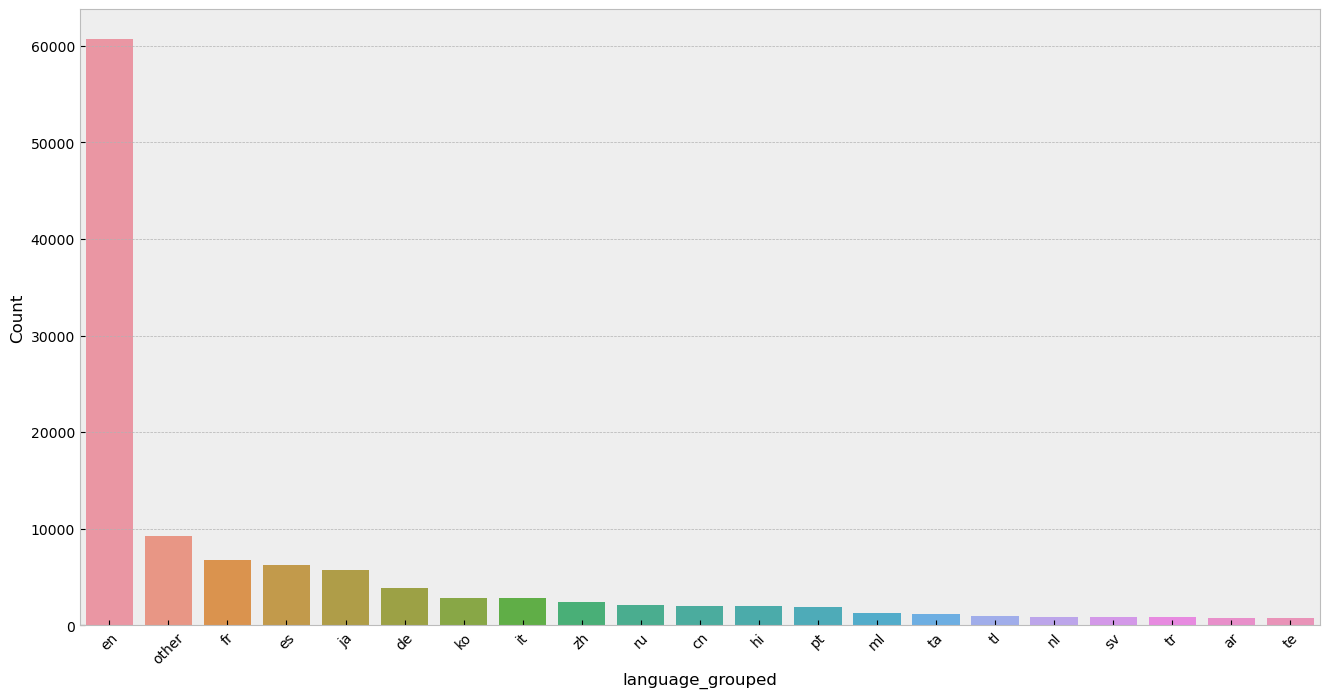

In [162]:
plot_column_counts('language_grouped', final_df, figsize=(16, 8))


In [163]:
original_language_group_info = column_info_cat(final_df['language_grouped'])
print(original_language_group_info)

Length of column: 116294
Number of unique values: 21
Number of missing values: 0
Percentage of missing values: 0.0%
{'len': 116294, 'unique': 21, 'num_missing': 0, 'perc_missing': 0.0}


<Figure size 640x480 with 0 Axes>

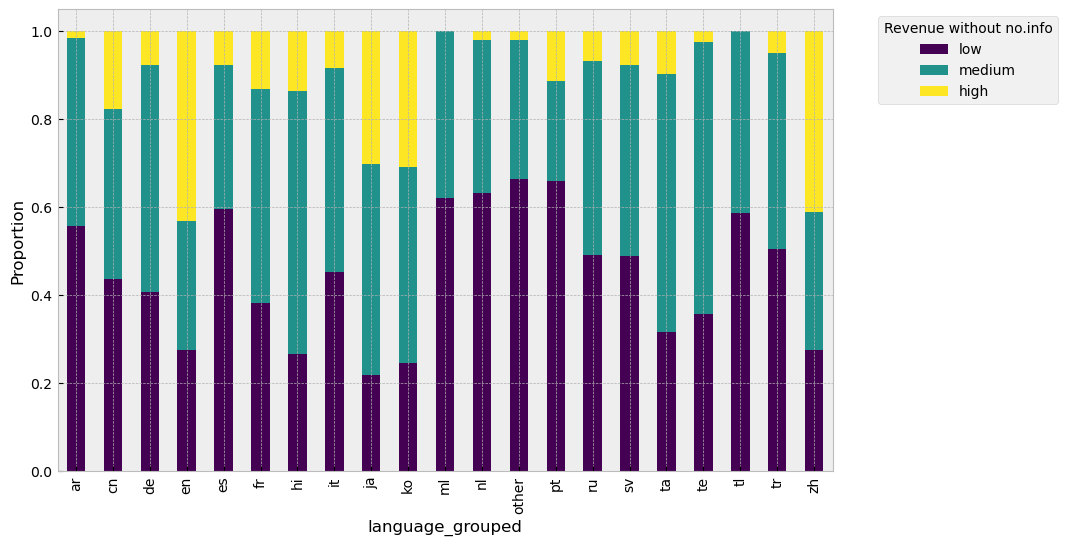

<Figure size 640x480 with 0 Axes>

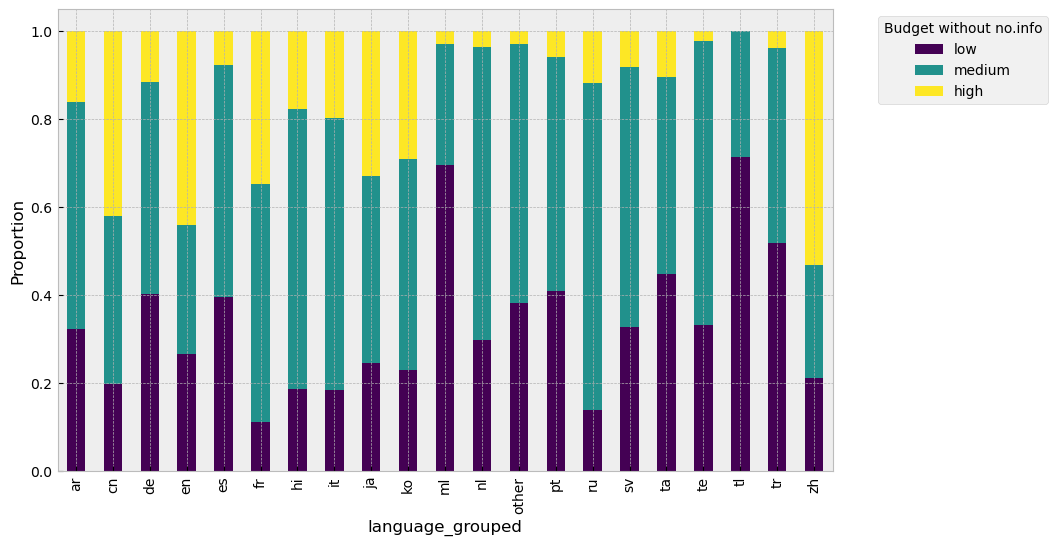

<Figure size 640x480 with 0 Axes>

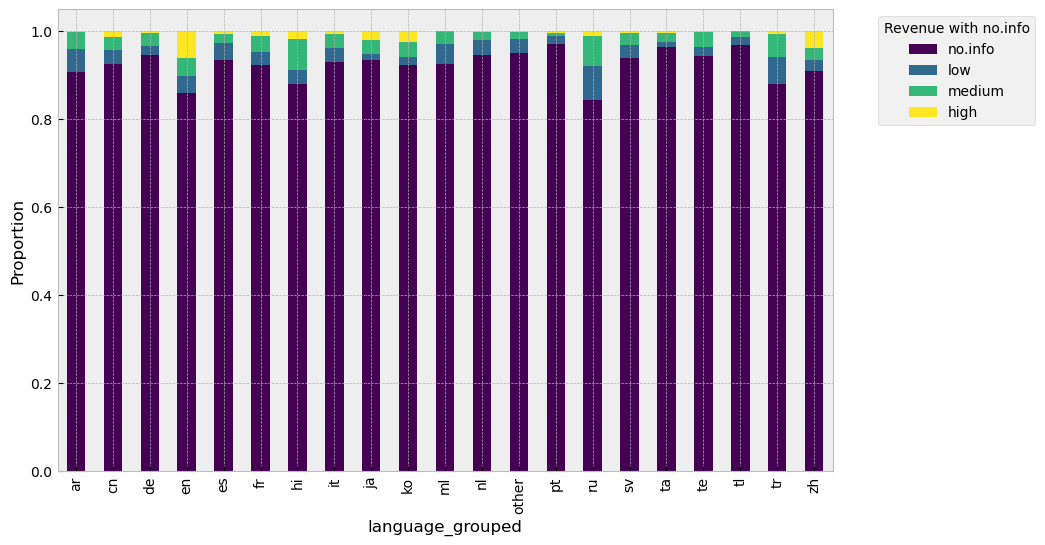

<Figure size 640x480 with 0 Axes>

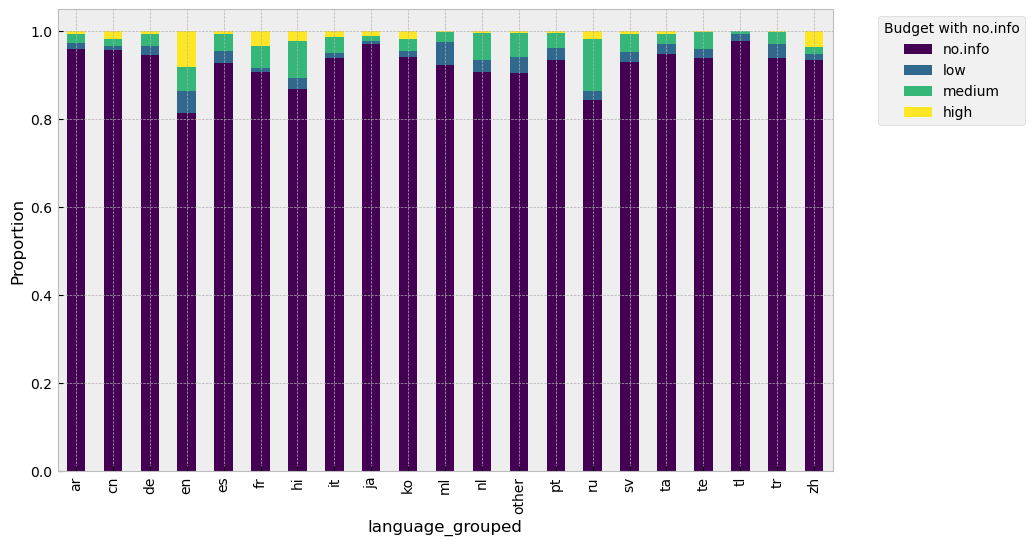

<Figure size 640x480 with 0 Axes>

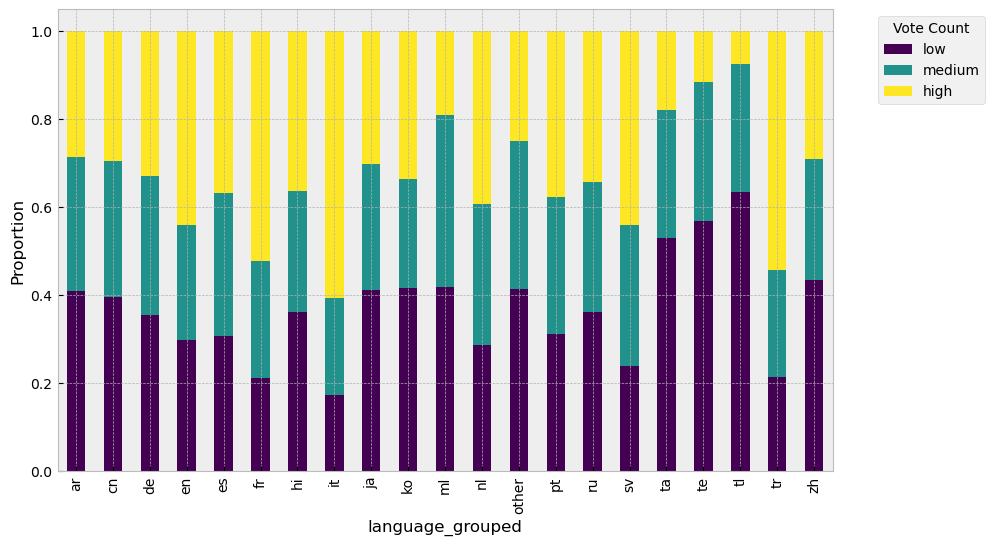

<Figure size 640x480 with 0 Axes>

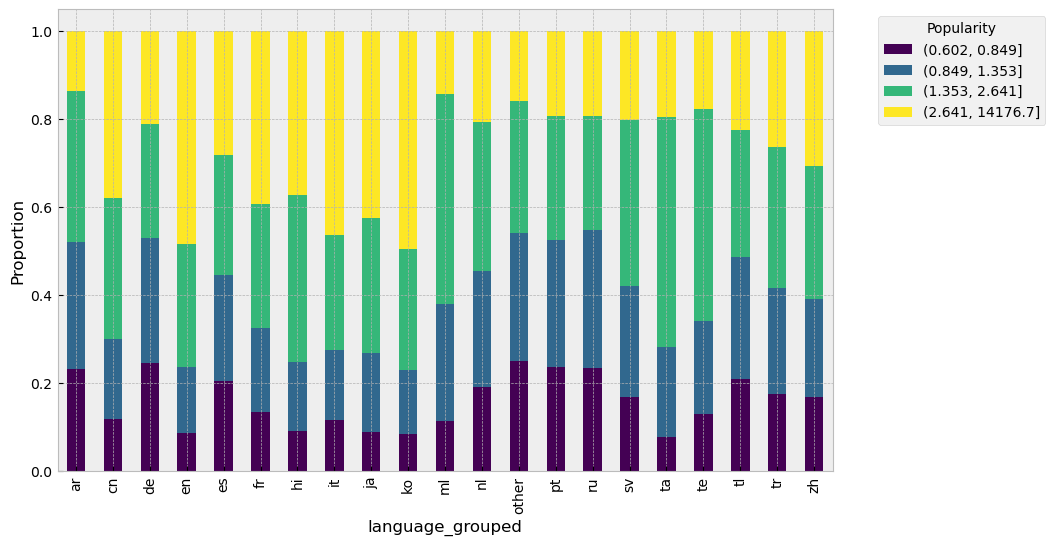

<Figure size 640x480 with 0 Axes>

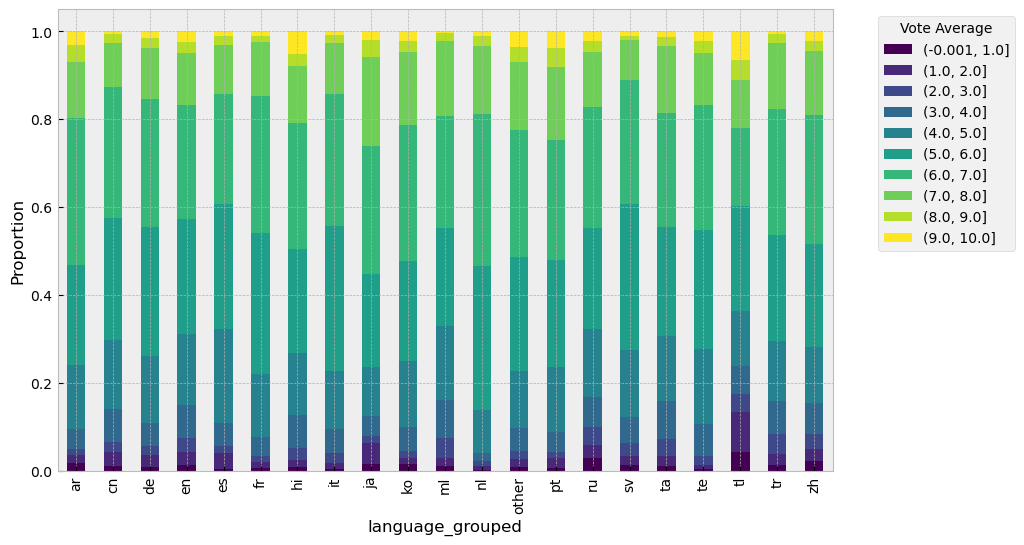

In [164]:
# Create contingency tables and normalize them, excluding 'no.info' in revenue_binned and budget_binned
contingency_revenue_no_info = pd.crosstab(final_df['language_grouped'], final_df[final_df['revenue_binned'] != 'no.info']['revenue_binned'])
normalized_revenue_no_info = contingency_revenue_no_info.div(contingency_revenue_no_info.sum(axis=1), axis=0)

contingency_budget_no_info = pd.crosstab(final_df['language_grouped'], final_df[final_df['budget_binned'] != 'no.info']['budget_binned'])
normalized_budget_no_info = contingency_budget_no_info.div(contingency_budget_no_info.sum(axis=1), axis=0)

contingency_revenue_with_info = pd.crosstab(final_df['language_grouped'], final_df['revenue_binned'])
normalized_revenue_with_info = contingency_revenue_with_info.div(contingency_revenue_with_info.sum(axis=1), axis=0)

contingency_budget_with_info = pd.crosstab(final_df['language_grouped'], final_df['budget_binned'])
normalized_budget_with_info = contingency_budget_with_info.div(contingency_budget_with_info.sum(axis=1), axis=0)

contingency_vote_count = pd.crosstab(final_df['language_grouped'], final_df['vote_count_binned'])
normalized_vote_count = contingency_vote_count.div(contingency_vote_count.sum(axis=1), axis=0)

contingency_popularity = pd.crosstab(final_df['language_grouped'], final_df['popularity_binned'])
normalized_popularity = contingency_popularity.div(contingency_popularity.sum(axis=1), axis=0)

contingency_vote_average = pd.crosstab(final_df['language_grouped'], final_df['vote_average_binned'])
normalized_vote_average = contingency_vote_average.div(contingency_vote_average.sum(axis=1), axis=0)

# Stacked bar plots
stacked_bar_plot(normalized_revenue_no_info, 'language_grouped', 'Revenue without no.info')
stacked_bar_plot(normalized_budget_no_info, 'language_grouped', 'Budget without no.info')
stacked_bar_plot(normalized_revenue_with_info, 'language_grouped', 'Revenue with no.info')
stacked_bar_plot(normalized_budget_with_info, 'language_grouped', 'Budget with no.info')
stacked_bar_plot(normalized_vote_count, 'language_grouped', 'Vote Count')
stacked_bar_plot(normalized_popularity, 'language_grouped', 'Popularity')
stacked_bar_plot(normalized_vote_average, 'language_grouped', 'Vote Average')



##### overview Column

**Overview**

In [165]:
final_df['overview'].info()

<class 'pandas.core.series.Series'>
Int64Index: 116294 entries, 0 to 532724
Series name: overview
Non-Null Count   Dtype   
--------------   -----   
116294 non-null  category
dtypes: category(1)
memory usage: 24.9 MB


In [166]:
overview_info = column_info_cat(final_df['overview'])
print(overview_info)

Length of column: 116294
Number of unique values: 113771
Number of missing values: 0
Percentage of missing values: 0.0%
{'len': 116294, 'unique': 113771, 'num_missing': 0, 'perc_missing': 0.0}


**Duplicate rows**

In [167]:
# Count the frequency of each value in the 'overview' column
value_counts = final_df['overview'].value_counts()

# Filter the values that have a frequency greater than 1 (repeated)
repeated_values = value_counts[value_counts > 1]

# Calculate the total number of repeated values
num_repeated_values = repeated_values.sum()

# Calculate the percentage of repeated values with respect to the total number of rows
percentage_repeated_values = (num_repeated_values / len(final_df)) * 100

# Print the results
print("Number of repeated values:", num_repeated_values)
print("Percentage of repeated values: {:.2f}%".format(percentage_repeated_values))
print("\nNumber of times each repeated value appears:")
print(repeated_values)


Number of repeated values: 2587
Percentage of repeated values: 2.22%

Number of times each repeated value appears:
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

###### Cheking duplicate rows

In [168]:
# Identify the rows with duplicated overviews
final_df['overview_duplicated'] = final_df['overview'].duplicated(keep=False)

# Filter only the rows with duplicated overviews
duplicated_overview_rows = final_df[final_df['overview_duplicated']]

# Remove the 'overview_duplicated' column
final_df.drop(columns=['overview_duplicated'], inplace=True)

# Check if all columns of each group are equal
all_columns_equal = []

for overview in repeated_values.index:
    overview_rows = duplicated_overview_rows[duplicated_overview_rows['overview'] == overview]
    overview_rows = overview_rows.drop(columns=['overview'])  # Remove the 'overview' column since we know it's equal in all rows.
    equal_rows = overview_rows.duplicated(keep=False).all()
    all_columns_equal.append((overview, equal_rows))

# Create a DataFrame with the results
result_overview = pd.DataFrame(all_columns_equal, columns=['overview', 'all_columns_equal'])

# Show the result
print(result_overview)


                                             overview  all_columns_equal
0                                                                  False
1                                Mexican feature film              False
2                                Nikkatsu Roman Porno              False
3                              Roman Porno from 1984.              False
4   Those Lemon Popsicle boys are at it again!..Na...              False
..                                                ...                ...
59  When Ricky Miller, a single, quiet 40-year old...              False
60  A direct-to-video compilation of the highlight...              False
61  Jennifer and Meg Swift are two sisters who are...              False
62  17 year old schoolgirl Sakura visits a Samurai...              False
63  Miser Ebenezer Scrooge is awakened on Christma...              False

[64 rows x 2 columns]


In [169]:
# Check if there's any True value in the 'all_columns_equal' column
any_true_values = result_overview['all_columns_equal'].any()

# Show the result
print("Are there any True values in the 'all_columns_equal' column?", any_true_values)


Are there any True values in the 'all_columns_equal' column? False


##### genre column

###### Genre dataframe - Overview

In [170]:
df_genre = final_df[['id_movie', 'genre']]
print(df_genre.head())

   id_movie                    genre
0         2     Comedy, Crime, Drama
1         3   Comedy, Drama, Romance
2         5            Comedy, Crime
3         6  Action, Crime, Thriller
4         8              Documentary


In [171]:
df_genre['genre'].info()

<class 'pandas.core.series.Series'>
Int64Index: 116294 entries, 0 to 532724
Series name: genre
Non-Null Count   Dtype   
--------------   -----   
111559 non-null  category
dtypes: category(1)
memory usage: 5.3 MB


In [172]:
genre_info = column_info_cat(df_genre['genre'])
print(genre_info)

Length of column: 116294
Number of unique values: 2432
Number of missing values: 4735
Percentage of missing values: 4.07%
{'len': 116294, 'unique': 2432, 'num_missing': 4735, 'perc_missing': 4.07}


###### Missing Values

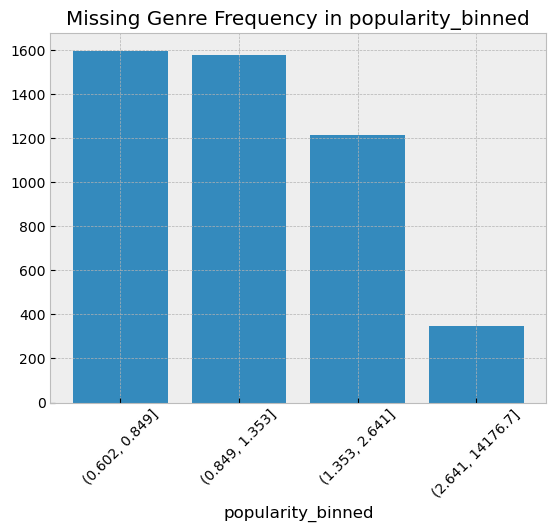

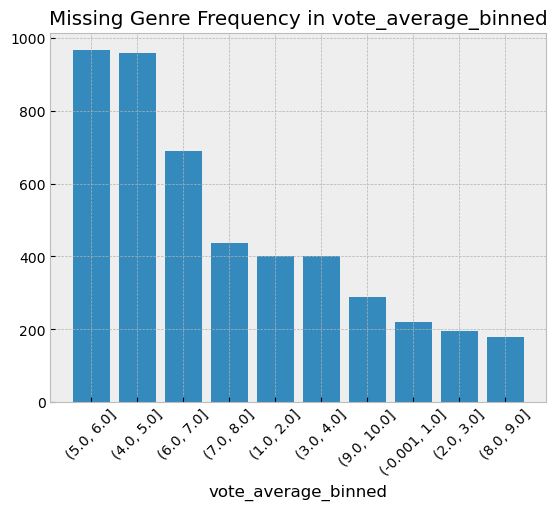

In [237]:
def missing_genre_bar_plot(df, column):
    # Filter rows where 'genre' has a missing value (NaN)
    missing_genres_df = df[df['genre'].isna()]

    # Count the frequency of each category in the given column
    category_counts = missing_genres_df[column].value_counts(dropna=False)

    # Convert the categories to string
    category_labels = [str(category) for category in category_counts.index]

    # Create a bar plot for the distribution of missing values in 'genre'
    plt.bar(category_labels, category_counts.values)
    plt.xlabel(column)
    plt.title(f'Missing Genre Frequency in {column}')
    plt.xticks(rotation=45)
    plt.show()

# Generate bar plots for each column
missing_genre_bar_plot(final_df, 'popularity_binned')
missing_genre_bar_plot(final_df, 'vote_average_binned')


###### Separate values into columns

First we find out how many values are in each row of the column and then we choose the first three to separate each value into a column, so we can better analyze the values.

In [174]:
count_items_in_column(df_genre, 'genre', 'num_genre')


The maximum number of items in a row is: 9.0
1 genre(s): 45408
2 genre(s): 37566
3 genre(s): 21112
4 genre(s): 5906
5 genre(s): 1257
6 genre(s): 263
7 genre(s): 41
8 genre(s): 3
9 genre(s): 3
Missing values: 4735


In [175]:
# show rows with n values
find_rows_with_n_items(df_genre, 'num_genre', 9)


        id_movie                                              genre  num_genre
10007      21325  Action, Adventure, Drama, Fantasy, History, Ho...        9.0
137224    333447  Action, Adventure, Comedy, Drama, Fantasy, Mys...        9.0
246151    537061  Action, Adventure, Animation, Comedy, Drama, F...        9.0


In [176]:
# show details of a given id_movie
show_movie_details(final_df, 333447)


                         title language_grouped  runtime  popularity  \
137224  The Women of Fast Food               ja      123       0.666   

        vote_average  year  
137224          10.0  2007  


We choose the first 3 genres and separate them into columns

In [177]:
def process_genres(row):
    genres = row['genre']
    
    if pd.isna(genres):
        genre1, genre2, genre3 = np.nan, np.nan, np.nan
    else:
        genres_list = genres.split(', ')
        
        if len(genres_list) > 3:
            genre1, genre2, genre3 = genres_list[:3]
        else:
            genre1 = genres_list[0] if len(genres_list) > 0 else np.nan
            genre2 = genres_list[1] if len(genres_list) > 1 else np.nan
            genre3 = genres_list[2] if len(genres_list) > 2 else np.nan
            
    return pd.Series([row['id_movie'], genre1, genre2, genre3])

# Apply the process_genres function to each row of the df_genre DataFrame
genres_film = df_genre.apply(process_genres, axis=1)

# Cambiar los nombres de las columnas
genres_film.columns = ['id_movie', 'genre1', 'genre2', 'genre3']


print(genres_film)


         id_movie       genre1   genre2    genre3
0             2.0       Comedy    Crime     Drama
1             3.0       Comedy    Drama   Romance
2             5.0       Comedy    Crime       NaN
3             6.0       Action    Crime  Thriller
4             8.0  Documentary      NaN       NaN
...           ...          ...      ...       ...
531867  1114798.0  Documentary  History       NaN
532041  1115307.0  Documentary      NaN       NaN
532139  1115538.0      Fantasy      NaN       NaN
532704  1116920.0       Comedy      NaN       NaN
532724  1116997.0          NaN      NaN       NaN

[116294 rows x 4 columns]


##### prod_comp column

###### Overview

In [178]:
df_prod_comp = final_df[['id_movie', 'prod_comp_name']]
print(df_prod_comp.head())

   id_movie             prod_comp_name
0         2  Villealfa Filmproductions
1         3  Villealfa Filmproductions
2         5      A Band Apart, Miramax
3         6   JVC, Largo Entertainment
4         8                    inLoops


In [179]:
df_prod_comp['prod_comp_name'].info()

<class 'pandas.core.series.Series'>
Int64Index: 116294 entries, 0 to 532724
Series name: prod_comp_name
Non-Null Count  Dtype   
--------------  -----   
85827 non-null  category
dtypes: category(1)
memory usage: 10.4 MB


In [180]:
prod_comp_info = column_info_cat(df_prod_comp['prod_comp_name'])
print(prod_comp_info)

Length of column: 116294
Number of unique values: 61721
Number of missing values: 30467
Percentage of missing values: 26.2%
{'len': 116294, 'unique': 61721, 'num_missing': 30467, 'perc_missing': 26.2}


###### Missing Values

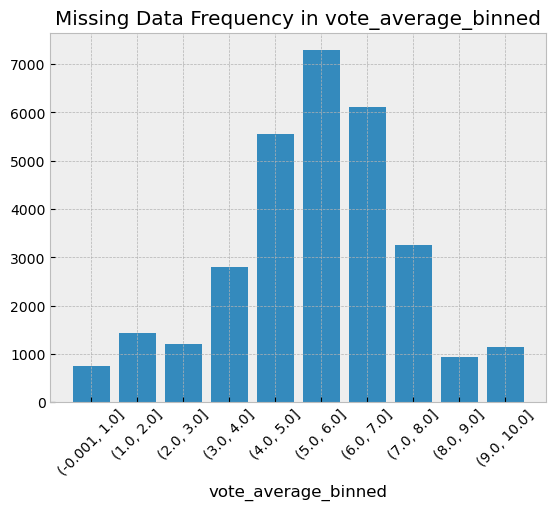

In [181]:
missing_data_bar_plot(final_df, 'prod_comp_name', 'vote_average_binned')

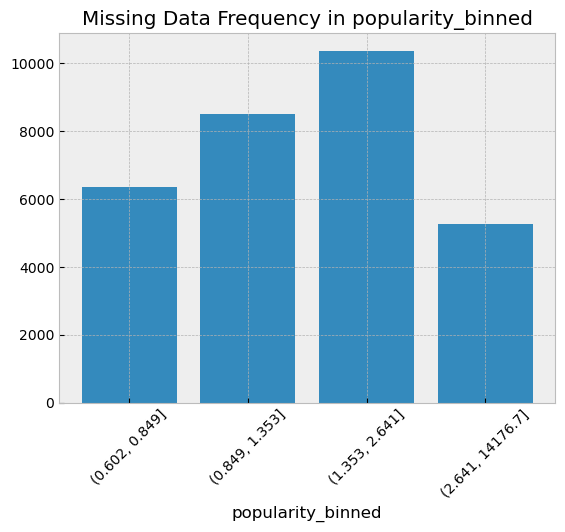

In [182]:
missing_data_bar_plot(final_df, 'prod_comp_name', 'popularity_binned')

###### Number of production companies per film

First we find out how many values are in each row of the column and then we choose the first three to separate each value into a column, so we can better analyze the values.

In [183]:
count_items_in_column(df_prod_comp, 'prod_comp_name', 'num_prod_comps')


The maximum number of items in a row is: 30.0
1 prod_comp_name(s): 39176
2 prod_comp_name(s): 21750
3 prod_comp_name(s): 12243
4 prod_comp_name(s): 5523
5 prod_comp_name(s): 2967
6 prod_comp_name(s): 1627
7 prod_comp_name(s): 903
8 prod_comp_name(s): 611
9 prod_comp_name(s): 369
10 prod_comp_name(s): 192
11 prod_comp_name(s): 153
12 prod_comp_name(s): 107
13 prod_comp_name(s): 58
14 prod_comp_name(s): 46
15 prod_comp_name(s): 30
16 prod_comp_name(s): 23
17 prod_comp_name(s): 12
18 prod_comp_name(s): 7
19 prod_comp_name(s): 7
20 prod_comp_name(s): 4
21 prod_comp_name(s): 5
22 prod_comp_name(s): 3
23 prod_comp_name(s): 1
24 prod_comp_name(s): 4
26 prod_comp_name(s): 4
29 prod_comp_name(s): 1
30 prod_comp_name(s): 1
Missing values: 30467


In [184]:
# show rows with n values
find_rows_with_n_items(df_prod_comp, 'num_prod_comps', 30)

       id_movie                                     prod_comp_name  \
37631     74639  Aberdeen Boat Club, AnswerMark Studio, Bona En...   

       num_prod_comps  
37631            30.0  


In [185]:
# show details of a given id_movie
show_movie_details(final_df, 74639)

             title language_grouped  runtime  popularity  vote_average  year
37631  Overheard 2               cn      121       5.833         6.398  2011


In [186]:
# counts the frequency of each value and displays the top 15 most frequent values
name_freq = count_name_frequencies(df_prod_comp, 'prod_comp_name')
display_top_names(name_freq, top_n=15)

1. Canal+: 970
2. Warner Bros. Pictures: 783
3. Universal Pictures: 783
4. ZDF: 615
5. ARD: 580
6. Paramount: 577
7. Columbia Pictures: 529
8. ARTE: 528
9. 20th Century Fox: 503
10. CNC: 499
11. BBC: 479
12. RAI: 449
13. France 2 Cinéma: 441
14. TOHO: 402
15. France 3 Cinéma: 368


In [187]:
df_prod_comp

id_movie                      prod_comp_name  num_prod_comps
0              2           Villealfa Filmproductions             1.0
1              3           Villealfa Filmproductions             1.0
2              5               A Band Apart, Miramax             2.0
3              6            JVC, Largo Entertainment             2.0
4              8                             inLoops             1.0
...          ...                                 ...             ...
531867   1114798  ARTE, Florianfilm, Las Belgas, ZDF             4.0
532041   1115307                           Mediapart             1.0
532139   1115538            Jack Van Impe Ministries             1.0
532704   1116920                   Defy Media, Smosh             2.0
532724   1116997                                 NaN             NaN

[116294 rows x 3 columns]

###### Analysis Production companies

We analyze the relationship between the number of production companies that a film has and its popularity, ratings, runtime and budget

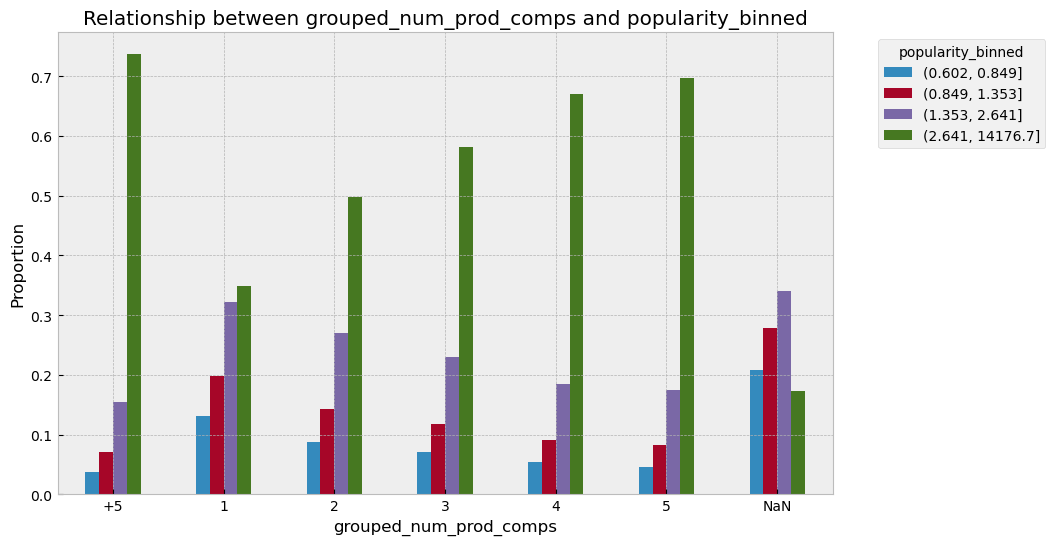

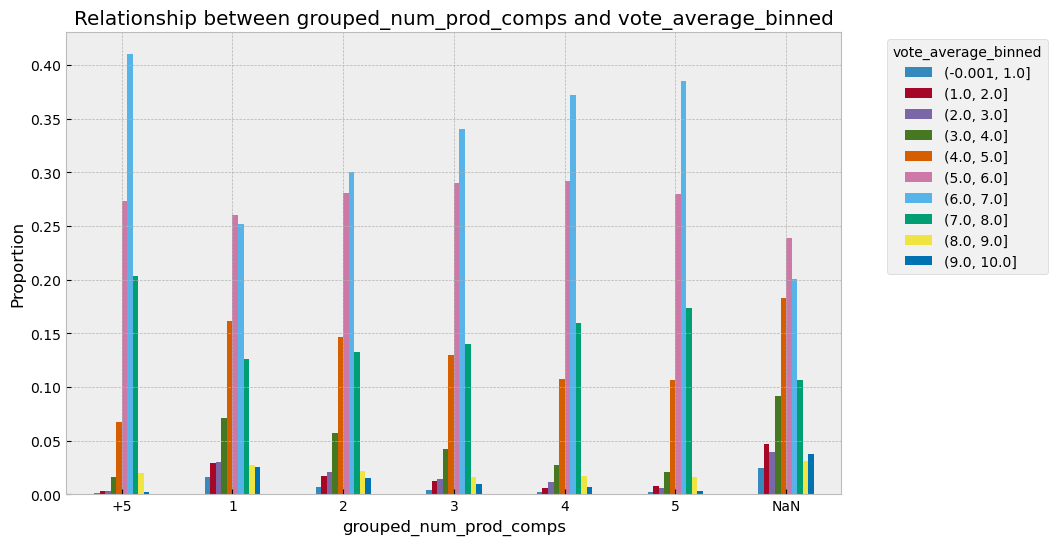

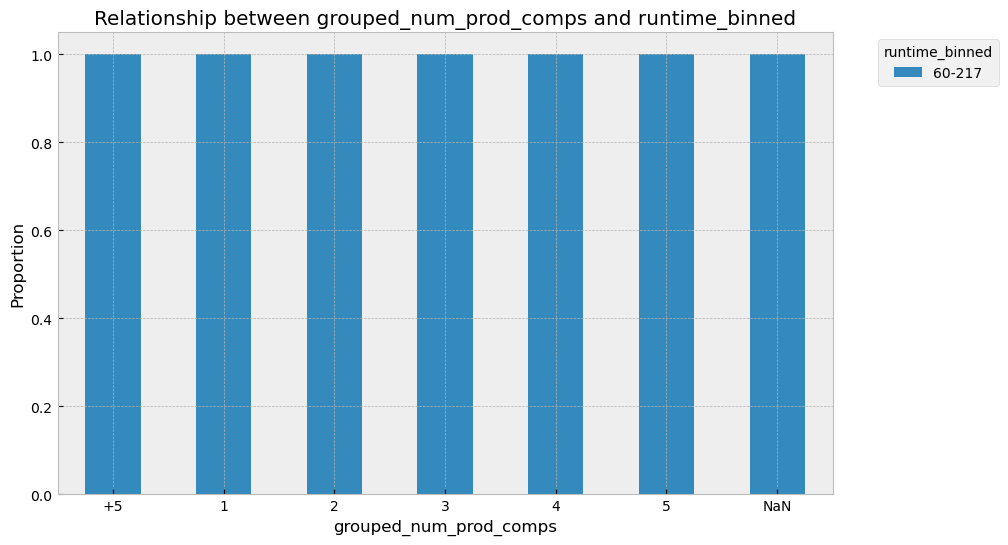

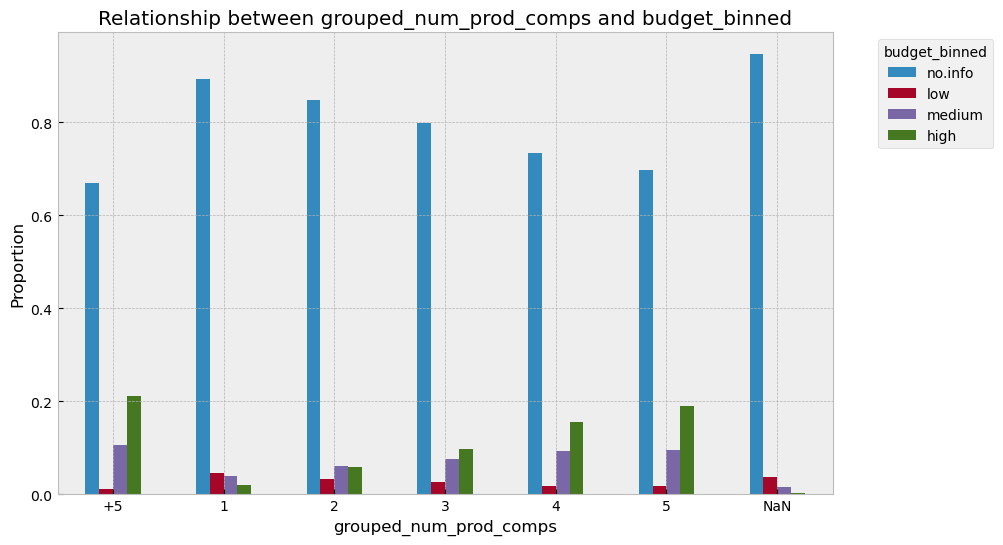

In [188]:
# Merge the two DataFrames on the 'id_movie' column
merged_df = final_df.merge(df_prod_comp, on='id_movie')

# Create a new column to group the 'num_prod_comps' values
def group_num_prod_comps(value):
    if pd.isna(value):
        return 'NaN'
    elif value <= 5:
        return str(int(value))
    else:
        return '+5'

merged_df['grouped_num_prod_comps'] = merged_df['num_prod_comps'].apply(group_num_prod_comps)

# List of binned columns to create bar plots
binned_columns = ['popularity_binned', 'vote_average_binned', 'runtime_binned', 'budget_binned']

# Function to create bar plots for each binned column
def create_bar_plots(df, column, grouped_column='grouped_num_prod_comps'):
    category_counts = df.groupby(grouped_column)[column].value_counts(normalize=True).unstack().fillna(0)
    ax = category_counts.plot(kind='bar', figsize=(10, 6), rot=0)
    plt.xlabel(grouped_column)
    plt.ylabel('Proportion')
    plt.title(f'Relationship between {grouped_column} and {column}')
    plt.legend(title=column, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

# Create bar plots for each binned column
for column in binned_columns:
    create_bar_plots(merged_df, column)


###### Separate values into columns

In [189]:
# Apply the process_items_to column function to each row of the DataFrame df_prod_comp
prod_comp_film = df_prod_comp.apply(lambda row: process_items_to_column(row, 'prod_comp_name', 'id_movie'), axis=1)

# Change the column names
prod_comp_film.columns = ['id_movie', 'prod_comp1', 'prod_comp2', 'prod_comp3']

prod_comp_film

id_movie                 prod_comp1           prod_comp2  prod_comp3
0             2.0  Villealfa Filmproductions                  NaN         NaN
1             3.0  Villealfa Filmproductions                  NaN         NaN
2             5.0               A Band Apart              Miramax         NaN
3             6.0                        JVC  Largo Entertainment         NaN
4             8.0                    inLoops                  NaN         NaN
...           ...                        ...                  ...         ...
531867  1114798.0                       ARTE          Florianfilm  Las Belgas
532041  1115307.0                  Mediapart                  NaN         NaN
532139  1115538.0   Jack Van Impe Ministries                  NaN         NaN
532704  1116920.0                 Defy Media                Smosh         NaN
532724  1116997.0                        NaN                  NaN         NaN

[116294 rows x 4 columns]

##### str_comp column

###### Overview

In [190]:
df_str_comp = final_df[['id_movie', 'str_comp_name']]
print(df_str_comp.head())

   id_movie                str_comp_name
0         2                       Filmin
1         3                          NaN
2         5                Movistar Plus
3         6                       Filmin
4         8  DocAlliance Films, GuideDoc


In [191]:
df_str_comp['str_comp_name'].info()

<class 'pandas.core.series.Series'>
Int64Index: 116294 entries, 0 to 532724
Series name: str_comp_name
Non-Null Count  Dtype   
--------------  -----   
17031 non-null  category
dtypes: category(1)
memory usage: 5.2 MB


In [192]:
str_comp_info = column_info_cat(df_str_comp['str_comp_name'])
print(str_comp_info)

Length of column: 116294
Number of unique values: 418
Number of missing values: 99263
Percentage of missing values: 85.36%
{'len': 116294, 'unique': 418, 'num_missing': 99263, 'perc_missing': 85.36}


###### Missing Values

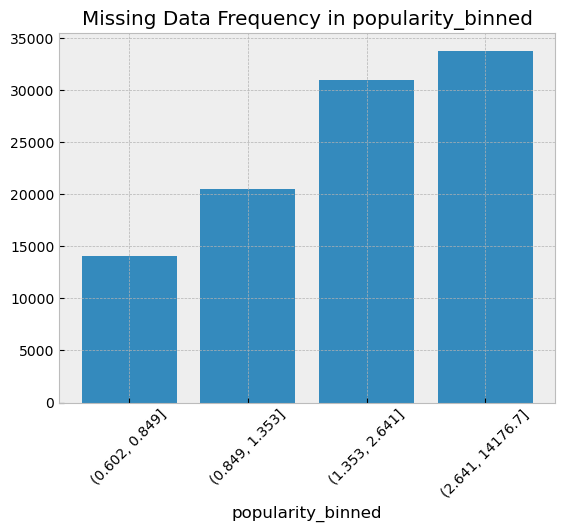

In [193]:
missing_data_bar_plot(final_df, 'str_comp_name', 'popularity_binned')

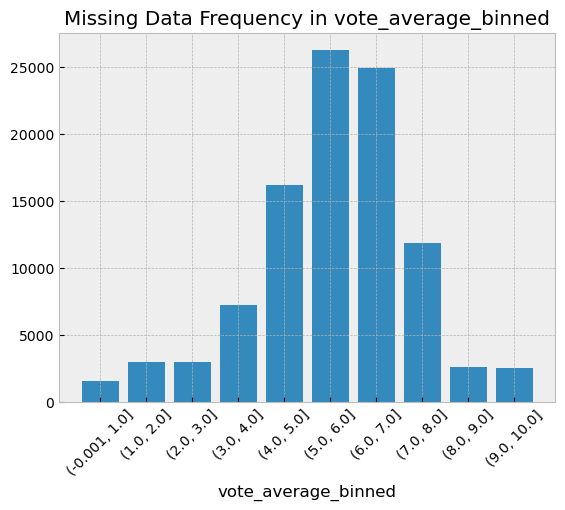

In [194]:
missing_data_bar_plot(final_df, 'str_comp_name', 'vote_average_binned')

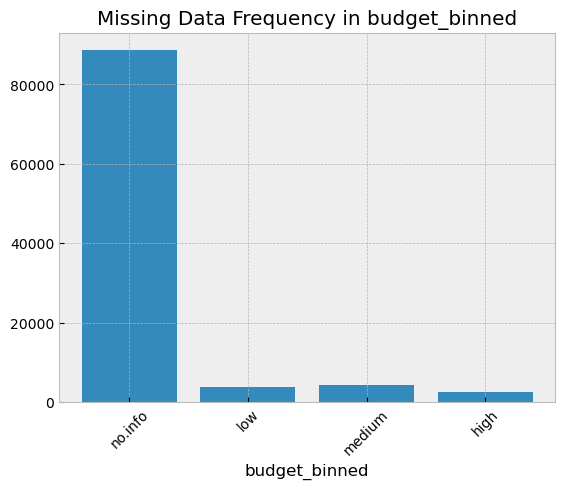

In [195]:
missing_data_bar_plot(final_df, 'str_comp_name', 'budget_binned')

###### Number of streaming companies per film

In [196]:
count_items_in_column(df_str_comp, 'str_comp_name', 'num_str_comps')

The maximum number of items in a row is: 8.0
1 str_comp_name(s): 9565
2 str_comp_name(s): 5879
3 str_comp_name(s): 1092
4 str_comp_name(s): 313
5 str_comp_name(s): 114
6 str_comp_name(s): 54
7 str_comp_name(s): 13
8 str_comp_name(s): 1
Missing values: 99263


In [197]:
# show rows with n values
find_rows_with_n_items(df_str_comp, 'num_str_comps', 8)

        id_movie                                      str_comp_name  \
132165    324552  Amazon Prime Video, HBO Max, MGM Amazon Channe...   

        num_str_comps  
132165            8.0  


In [198]:
# show details of a given id_movie
show_movie_details(final_df, 324552)

                       title language_grouped  runtime  popularity  \
132165  John Wick: Chapter 2               en      122     458.609   

        vote_average  year  
132165          7.31  2017  


In [199]:
# counts the frequency of each value and displays the top 15 most frequent values
name_freq = count_name_frequencies(df_str_comp, 'str_comp_name')
display_top_names(name_freq, top_n=15)

1. Filmin: 5032
2. Netflix: 3824
3. Netflix basic with Ads: 3732
4. Amazon Prime Video: 3062
5. Movistar Plus: 1670
6. Disney Plus: 1173
7. FlixOlé: 1150
8. HBO Max: 946
9. FlixOlé Amazon Channel: 932
10. Sun Nxt: 787
11. SkyShowtime: 650
12. Acontra Plus: 581
13. Acontra Plus Amazon Channel: 459
14. DocAlliance Films: 366
15. MUBI: 288


###### Analysis Sreaming companies

We analyze the relationship between the number of streaming companies that a film has and its popularity, ratings, runtime and budget

The maximum number of items in a row is: 8.0
1 str_comp_name(s): 9565
2 str_comp_name(s): 5879
3 str_comp_name(s): 1092
4 str_comp_name(s): 313
5 str_comp_name(s): 114
6 str_comp_name(s): 54
7 str_comp_name(s): 13
8 str_comp_name(s): 1
Missing values: 99263


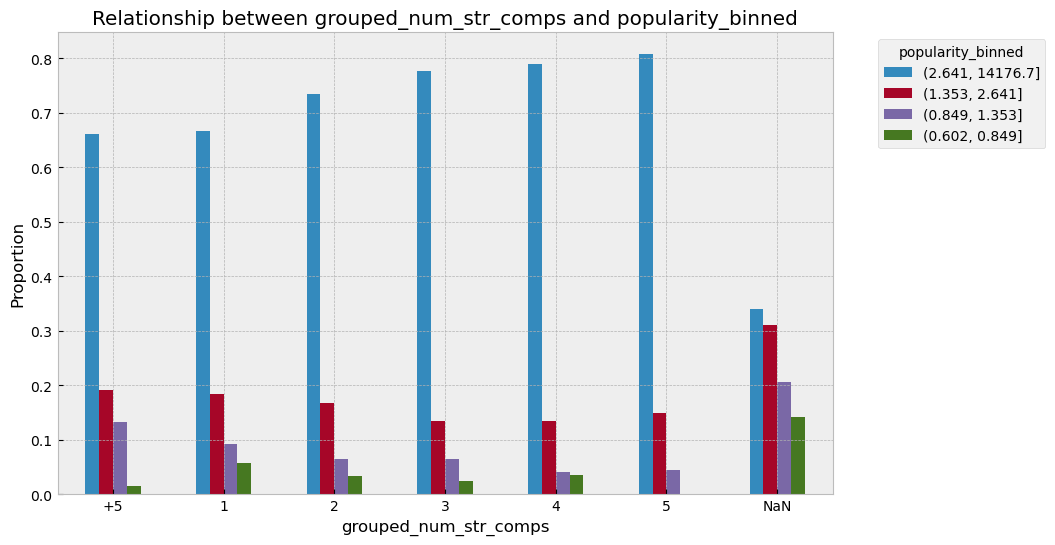

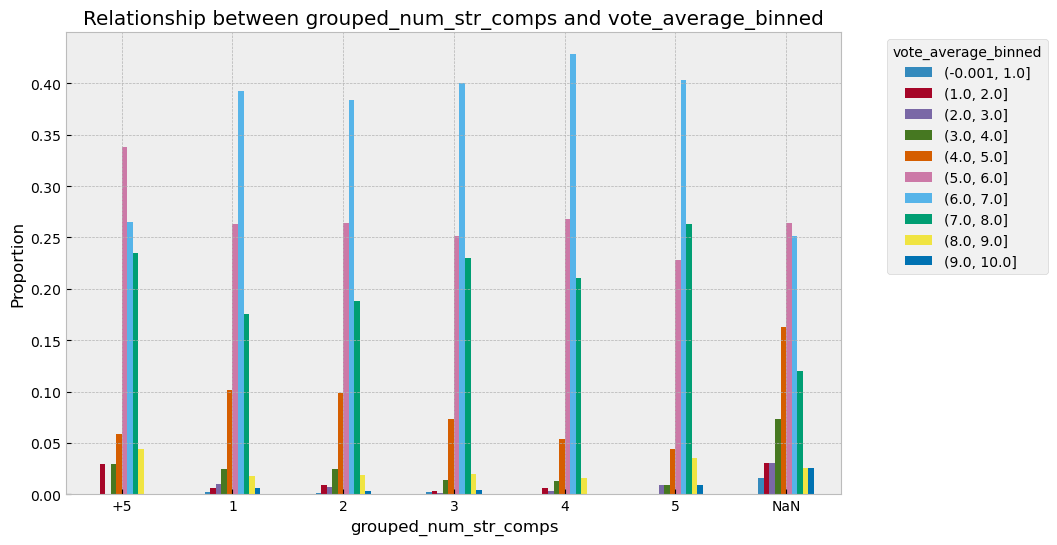

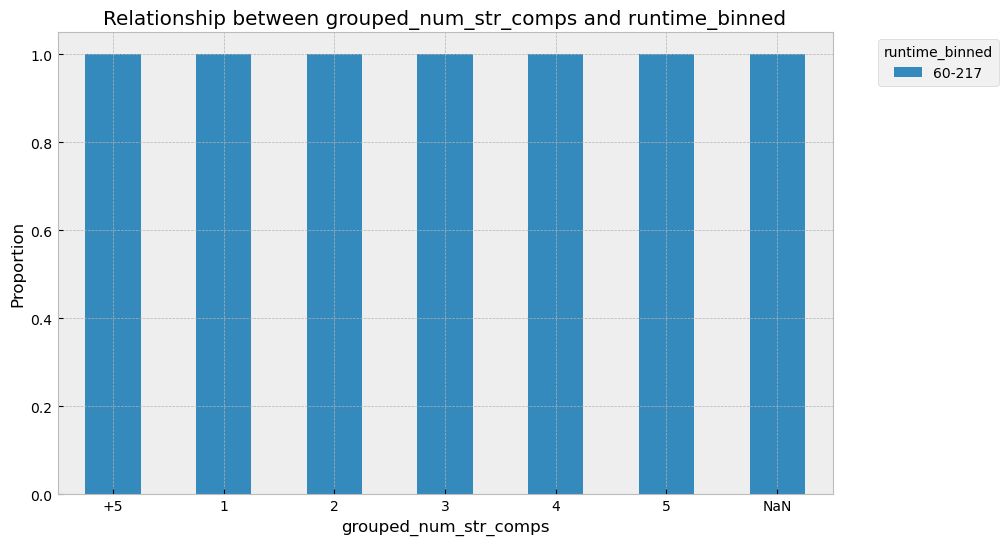

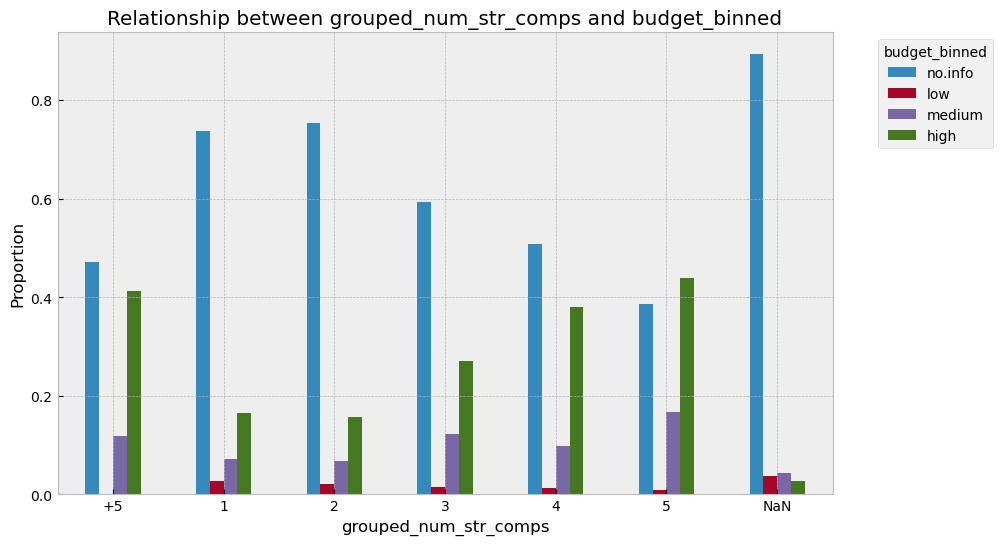

In [200]:
# Use the count_items_in_column function to create a new column 'num_str_comps'
count_items_in_column(df_str_comp, 'str_comp_name', 'num_str_comps')

# Merge the two DataFrames on the 'id_movie' column
merged_df = final_df.merge(df_str_comp, on='id_movie')

# Create a new column to group the 'num_str_comps' values
def group_num_str_comps(value):
    if pd.isna(value):
        return 'NaN'
    elif value <= 5:
        return str(int(value))
    else:
        return '+5'

merged_df['grouped_num_str_comps'] = merged_df['num_str_comps'].apply(group_num_str_comps)

# List of binned columns to create bar plots
binned_columns = ['popularity_binned', 'vote_average_binned', 'runtime_binned', 'budget_binned']

# Function to create bar plots for each binned column
def create_bar_plots(df, column, grouped_column='grouped_num_str_comps'):
    category_counts = df.groupby(grouped_column)[column].value_counts(normalize=True).unstack().fillna(0)
    ax = category_counts.plot(kind='bar', figsize=(10, 6), rot=0)
    plt.xlabel(grouped_column)
    plt.ylabel('Proportion')
    plt.title(f'Relationship between {grouped_column} and {column}')
    plt.legend(title=column, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

# Create bar plots for each binned column
for column in binned_columns:
    create_bar_plots(merged_df, column)


###### Separate values into columns

In [201]:
# Apply the process_items_to column function to each row of the DataFrame df_prod_comp
str_comp_film = df_str_comp.apply(lambda row: process_items_to_column(row, 'str_comp_name', 'id_movie'), axis=1)

# Change the column names
str_comp_film.columns = ['id_movie', 'str_comp1', 'str_comp2', 'str_comp3']

str_comp_film

id_movie          str_comp1 str_comp2 str_comp3
0             2.0             Filmin       NaN       NaN
1             3.0                NaN       NaN       NaN
2             5.0      Movistar Plus       NaN       NaN
3             6.0             Filmin       NaN       NaN
4             8.0  DocAlliance Films  GuideDoc       NaN
...           ...                ...       ...       ...
531867  1114798.0                NaN       NaN       NaN
532041  1115307.0                NaN       NaN       NaN
532139  1115538.0                NaN       NaN       NaN
532704  1116920.0                NaN       NaN       NaN
532724  1116997.0                NaN       NaN       NaN

[116294 rows x 4 columns]

##### director column

###### Overview

This column will be used in the recommendation model, so we are going to create a dataframe without empty values in this column for the model and another one keeping the empty values in this column for power bi visualizations.

In [202]:
df_director = final_df[['id_movie', 'director']]
print(df_director.head())

   id_movie                                           director
0         2                                     Aki Kaurismäki
1         3                                     Aki Kaurismäki
2         5  Alexandre Rockwell, Allison Anders, Quentin Ta...
3         6                                    Stephen Hopkins
4         8                                       Timo Novotny


In [203]:
director_info = column_info_cat(df_director['director'])
print(director_info)

Length of column: 116294
Number of unique values: 53683
Number of missing values: 2522
Percentage of missing values: 2.17%
{'len': 116294, 'unique': 53683, 'num_missing': 2522, 'perc_missing': 2.17}


###### Missing Values

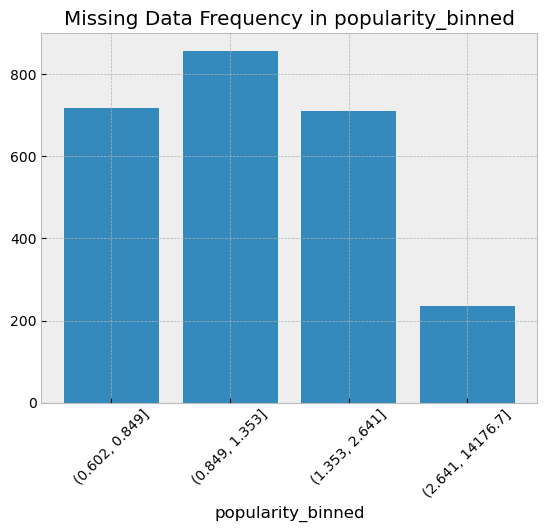

In [204]:
missing_data_bar_plot(final_df, 'director', 'popularity_binned')

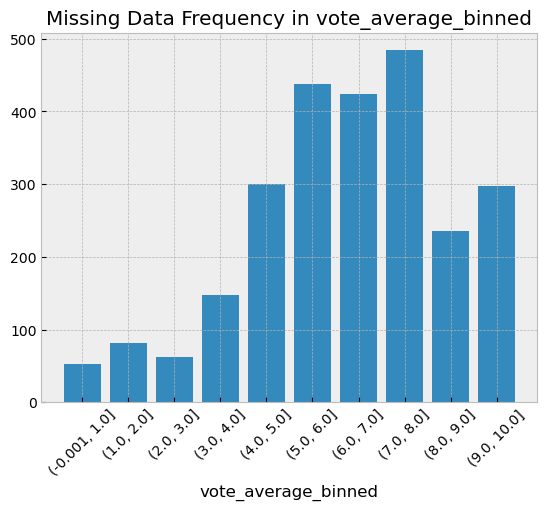

In [205]:
missing_data_bar_plot(final_df, 'director', 'vote_average_binned')

###### Number of directors per film

In [206]:
count_items_in_column(df_director, 'director', 'num_director')

The maximum number of items in a row is: 63.0
1 director(s): 105155
2 director(s): 7307
3 director(s): 657
4 director(s): 203
5 director(s): 130
6 director(s): 80
7 director(s): 66
8 director(s): 38
9 director(s): 28
10 director(s): 33
11 director(s): 14
12 director(s): 17
13 director(s): 12
14 director(s): 2
15 director(s): 4
16 director(s): 1
17 director(s): 3
18 director(s): 1
20 director(s): 3
21 director(s): 1
22 director(s): 3
25 director(s): 1
27 director(s): 1
29 director(s): 1
30 director(s): 1
31 director(s): 1
32 director(s): 1
33 director(s): 1
34 director(s): 1
35 director(s): 1
36 director(s): 1
38 director(s): 1
39 director(s): 1
41 director(s): 1
63 director(s): 1
Missing values: 2522


In [207]:
find_rows_with_n_items(df_director, 'num_director', 64)

Empty DataFrame
Columns: [id_movie, director, num_director]
Index: []


In [208]:
show_movie_details(final_df, 976535)

Empty DataFrame
Columns: [title, language_grouped, runtime, popularity, vote_average, year]
Index: []


In [209]:
# counts the frequency of each value and displays the top 15 most frequent values
name_freq = count_name_frequencies(df_director, 'director')

display_top_names(name_freq, top_n=15)

1. Fred Olen Ray: 142
2. David DeCoteau: 135
3. Wong Jing: 100
4. Jim Wynorski: 99
5. Takashi Miike: 80
6. Jesús Franco: 66
7. Terry Ingram: 65
8. Michael Feifer: 65
9. Johnnie To: 60
10. Herman Yau: 55
11. Carlo Vanzina: 53
12. Ron Oliver: 53
13. Steven R. Monroe: 50
14. Charles Band: 48
15. Joel Lamangan: 48


###### Separate values into columns

In [210]:
# Apply the process_items_to column function to each row of the DataFrame df_prod_comp
director_film = df_director.apply(lambda row: process_items_to_column(row, 'director', 'id_movie'), axis=1)

# Change the column names
director_film.columns = ['id_movie', 'director1', 'director2', 'director3']

director_film

id_movie           director1           director2          director3
0             2.0      Aki Kaurismäki                 NaN                NaN
1             3.0      Aki Kaurismäki                 NaN                NaN
2             5.0  Alexandre Rockwell      Allison Anders  Quentin Tarantino
3             6.0     Stephen Hopkins                 NaN                NaN
4             8.0        Timo Novotny                 NaN                NaN
...           ...                 ...                 ...                ...
531867  1114798.0   Claus Bredenbrock     Jascha Hannover                NaN
532041  1115307.0      David Perrotin  Mathieu Magnaudeix      Sarah Brethes
532139  1115538.0                 NaN                 NaN                NaN
532704  1116920.0       Marty Pasetta                 Jr.                NaN
532724  1116997.0                 NaN                 NaN                NaN

[116294 rows x 4 columns]

###### Dataframe for the model

In [211]:
director_film.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116294 entries, 0 to 532724
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id_movie   116294 non-null  float64
 1   director1  113772 non-null  object 
 2   director2  8617 non-null    object 
 3   director3  1310 non-null    object 
dtypes: float64(1), object(3)
memory usage: 8.5+ MB


In [212]:
director_film['director1'].isna().value_counts()


False    113772
True       2522
Name: director1, dtype: int64

In [213]:
director_modelo = director_film.dropna(subset=['director1'])

###### Actor Column

###### Overview

This column will be used in the recommendation model, so we are going to create a dataframe without empty values in this column for the model and another one keeping the empty values in this column for power bi visualizations.

In [214]:
df_actor = final_df[['id_movie', 'actor']]
print(df_actor.head())

   id_movie                             actor
0         2     Susanna Haavisto, Turo Pajala
1         3     Kati Outinen, Matti Pellonpää
2         5          Jennifer Beals, Tim Roth
3         6  Cuba Gooding Jr., Emilio Estevez
4         8                               NaN


In [215]:
df_actor.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116294 entries, 0 to 532724
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype   
---  ------    --------------   -----   
 0   id_movie  116294 non-null  int64   
 1   actor     111736 non-null  category
dtypes: category(1), int64(1)
memory usage: 16.8 MB


In [216]:
actor_info = column_info_cat(df_actor['actor'])
print(actor_info)

Length of column: 116294
Number of unique values: 105298
Number of missing values: 4558
Percentage of missing values: 3.92%
{'len': 116294, 'unique': 105298, 'num_missing': 4558, 'perc_missing': 3.92}


###### MIssing Values

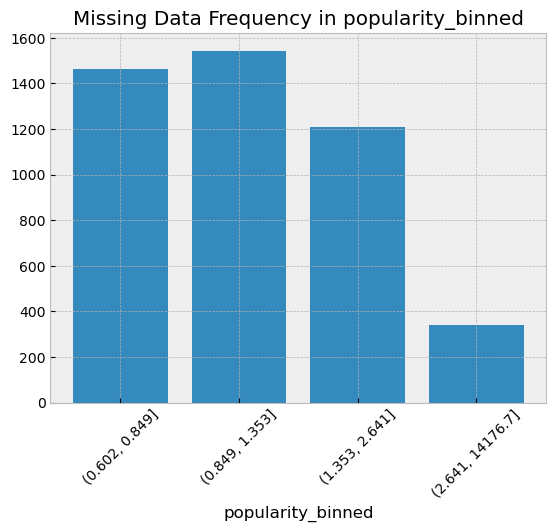

In [217]:
missing_data_bar_plot(final_df, 'actor', 'popularity_binned')

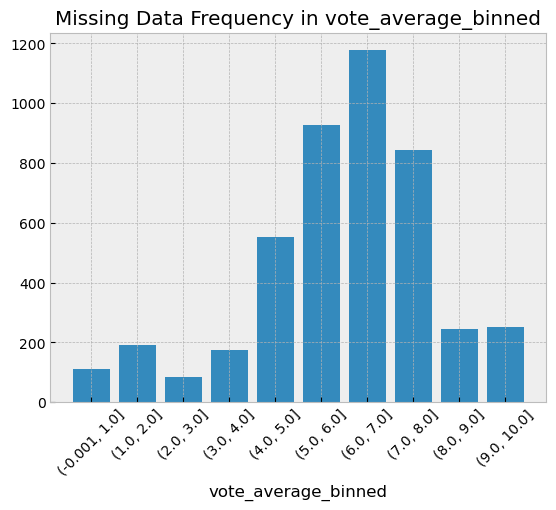

In [218]:
missing_data_bar_plot(final_df, 'actor', 'vote_average_binned')

###### Number of actors per column

In [219]:
count_items_in_column(df_actor, 'actor', 'num_actor')

The maximum number of items in a row is: 4.0
1 actor(s): 3517
2 actor(s): 108159
3 actor(s): 59
4 actor(s): 1
Missing values: 4558


In [220]:
df_actor

id_movie                                actor  num_actor
0              2        Susanna Haavisto, Turo Pajala        2.0
1              3        Kati Outinen, Matti Pellonpää        2.0
2              5             Jennifer Beals, Tim Roth        2.0
3              6     Cuba Gooding Jr., Emilio Estevez        2.0
4              8                                  NaN        NaN
...          ...                                  ...        ...
531867   1114798                                  NaN        NaN
532041   1115307      Axelle Sollossi, Eddy de Pretto        2.0
532139   1115538      Jack Van Impe, Rexella Van Impe        2.0
532704   1116920           Anthony Padilla, Ian Hecox        2.0
532724   1116997  Ricardo Castellanos, Whitney Jensen        2.0

[116294 rows x 3 columns]

###### Separate values into columns

In [222]:
# Apply the process_items_to column function to each row of the DataFrame 
actor_film = df_actor.apply(lambda row: process_items_to_column(row, 'actor', 'id_movie'), axis=1)

# Change the column names
actor_film.columns = ['id_movie', 'actor1', 'actor2', 'actor3']

actor_film

id_movie               actor1            actor2 actor3
0             2.0     Susanna Haavisto       Turo Pajala    NaN
1             3.0         Kati Outinen   Matti Pellonpää    NaN
2             5.0       Jennifer Beals          Tim Roth    NaN
3             6.0     Cuba Gooding Jr.    Emilio Estevez    NaN
4             8.0                  NaN               NaN    NaN
...           ...                  ...               ...    ...
531867  1114798.0                  NaN               NaN    NaN
532041  1115307.0      Axelle Sollossi    Eddy de Pretto    NaN
532139  1115538.0        Jack Van Impe  Rexella Van Impe    NaN
532704  1116920.0      Anthony Padilla         Ian Hecox    NaN
532724  1116997.0  Ricardo Castellanos    Whitney Jensen    NaN

[116294 rows x 4 columns]

###### Dataframe Model

In [223]:
final_df

id_movie                                              title  \
0              2                                              Ariel   
1              3                                Shadows in Paradise   
2              5                                         Four Rooms   
3              6                                     Judgment Night   
4              8                   Life in Loops (A Megacities RMX)   
...          ...                                                ...   
531867   1114798            Die Bücher, die Hitler nicht verbrannte   
532041   1115307                  Guet-apens, des crimes invisibles   
532139   1115538                                        The Rapture   
532704   1116920                     Smosh Live: Presented by 5 Gum   
532724   1116997  Nøtteknekkeren - ballett i to akter fra Den No...   

       original_language                                           overview  \
0                     fi  Taisto Kasurinen is a Finnish coal miner whose...   
1                     fi  An episode in the life of Nikander, a garbage ...   
2                     en  It's Ted the Bellhop's first night on the job....   
3                     en  While racing to a boxing match, Frank, Mike, J...   
4                     en  Timo Novotny labels his new project an experim...   
...                  ...                                                ...   
531867                de                                                      
532041                fr  The result of an investigation that lasted sev...   
532139                en  Evangelists Jack and Rexella Van Impe detail t...   
532704                en  The very first Smosh live stream with sketches...   
532724                en  The Nutcracker is about a young girl who recei...   

       release_date  runtime  popularity  vote_count  vote_average    budget  \
0        1988-10-21       73       6.736         247         7.055         0   
1        1986-10-17       76       6.212         268         7.200         0   
2        1995-12-09       98      23.513        2350         5.756   4000000   
3        1993-10-15      109       9.613         283         6.558  21000000   
4        2006-01-01       80       2.037          24         7.708     42000   
...             ...      ...         ...         ...           ...       ...   
531867   2023-04-18       91       5.050           1         8.000         0   
532041   2023-04-19       65       5.379           2         8.000         0   
532139   1997-12-31       86       0.840           1         2.000       200   
532704   2016-08-27       83       1.187           1        10.000         0   
532724   2020-12-20       93       0.751           1         8.000         0   

        ...                       screenplay  \
0       ...                              NaN   
1       ...                              NaN   
2       ...                              NaN   
3       ...                     Lewis Colick   
4       ...  Michael Glawogger, Timo Novotny   
...     ...                              ...   
531867  ...                              NaN   
532041  ...                              NaN   
532139  ...                              NaN   
532704  ...                              NaN   
532724  ...                              NaN   

                                      actor popularity_binned runtime_binned  \
0             Susanna Haavisto, Turo Pajala  (2.641, 14176.7]         60-217   
1             Kati Outinen, Matti Pellonpää  (2.641, 14176.7]         60-217   
2                  Jennifer Beals, Tim Roth  (2.641, 14176.7]         60-217   
3          Cuba Gooding Jr., Emilio Estevez  (2.641, 14176.7]         60-217   
4                                       NaN    (1.353, 2.641]         60-217   
...                                     ...               ...            ...   
531867                                  NaN  (2.641, 14176.7]         60-217   
532041      Axelle Sollossi,

In [224]:
actor_film.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116294 entries, 0 to 532724
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   id_movie  116294 non-null  float64
 1   actor1    111736 non-null  object 
 2   actor2    108219 non-null  object 
 3   actor3    60 non-null      object 
dtypes: float64(1), object(3)
memory usage: 8.5+ MB


In [225]:
missing_actor1 = actor_film['actor1'].isna().sum()
missing_actor2 = actor_film['actor2'].isna().sum()

print(f"Number of missing values in 'actor1' column: {missing_actor1}")
print(f"Number of missing values in 'actor2' column: {missing_actor2}")


Number of missing values in 'actor1' column: 4558
Number of missing values in 'actor2' column: 8075


In [226]:
df_model = actor_film.dropna(subset=['actor1', 'actor2'])


In [227]:
df_model

id_movie               actor1            actor2 actor3
0             2.0     Susanna Haavisto       Turo Pajala    NaN
1             3.0         Kati Outinen   Matti Pellonpää    NaN
2             5.0       Jennifer Beals          Tim Roth    NaN
3             6.0     Cuba Gooding Jr.    Emilio Estevez    NaN
6            12.0        Albert Brooks   Ellen DeGeneres    NaN
...           ...                  ...               ...    ...
531622  1114139.0       Analía Márquez     Camila Murias    NaN
532041  1115307.0      Axelle Sollossi    Eddy de Pretto    NaN
532139  1115538.0        Jack Van Impe  Rexella Van Impe    NaN
532704  1116920.0      Anthony Padilla         Ian Hecox    NaN
532724  1116997.0  Ricardo Castellanos    Whitney Jensen    NaN

[108219 rows x 4 columns]

##### screenplay column

We are not gaing to use this column

In [229]:
final_df['screenplay'].info()

<class 'pandas.core.series.Series'>
Int64Index: 116294 entries, 0 to 532724
Series name: screenplay
Non-Null Count  Dtype   
--------------  -----   
29900 non-null  category
dtypes: category(1)
memory usage: 6.7 MB


In [231]:
final_df = final_df.drop('screenplay', axis=1)

In [228]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116294 entries, 0 to 532724
Data columns (total 25 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   id_movie             116294 non-null  int64         
 1   title                116294 non-null  category      
 2   original_language    116294 non-null  category      
 3   overview             116294 non-null  category      
 4   release_date         116294 non-null  datetime64[ns]
 5   runtime              116294 non-null  int64         
 6   popularity           116294 non-null  float64       
 7   vote_count           116294 non-null  int64         
 8   vote_average         116294 non-null  float64       
 9   budget               116294 non-null  int64         
 10  revenue              116294 non-null  int64         
 11  genre                111559 non-null  category      
 12  prod_comp_name       85827 non-null   category      
 13  str_comp_name 

#### Model DataFrame 

In [233]:
# Seleccionar las columnas necesarias de cada DataFrame
final_df_selected = final_df[['id_movie', 'overview', 'vote_average']]
director_film_selected = director_film[['id_movie', 'director1']]
actor_film_selected = actor_film[['id_movie', 'actor1', 'actor2']]

# Unir final_df_selected con director_film_selected por la columna id_movie
modelo_df = final_df_selected.merge(director_film_selected, on='id_movie', how='inner')

# Unir modelo_df con actor_film_selected por la columna id_movie
modelo_df = modelo_df.merge(actor_film_selected, on='id_movie', how='inner')

# Verificar el resultado
print(modelo_df.head())


   id_movie                                           overview  vote_average  \
0         2  Taisto Kasurinen is a Finnish coal miner whose...         7.055   
1         3  An episode in the life of Nikander, a garbage ...         7.200   
2         5  It's Ted the Bellhop's first night on the job....         5.756   
3         6  While racing to a boxing match, Frank, Mike, J...         6.558   
4         8  Timo Novotny labels his new project an experim...         7.708   

            director1            actor1           actor2  
0      Aki Kaurismäki  Susanna Haavisto      Turo Pajala  
1      Aki Kaurismäki      Kati Outinen  Matti Pellonpää  
2  Alexandre Rockwell    Jennifer Beals         Tim Roth  
3     Stephen Hopkins  Cuba Gooding Jr.   Emilio Estevez  
4        Timo Novotny               NaN              NaN  


In [235]:
df = modelo_df.dropna()

In [ ]:
df = df.rename(columns={'vote_average': 'score', 'director1':'director'})

In [236]:
df

id_movie                                           overview  \
0              2  Taisto Kasurinen is a Finnish coal miner whose...   
1              3  An episode in the life of Nikander, a garbage ...   
2              5  It's Ted the Bellhop's first night on the job....   
3              6  While racing to a boxing match, Frank, Mike, J...   
5             12  Nemo, an adventurous young clownfish, is unexp...   
...          ...                                                ...   
116284   1112432  Starring pop idol Bobby Duo (竇智孔) and emerging...   
116285   1113627  Actors cast in James Cameron's TITANIC read th...   
116287   1114139  Laura lives in fear in a small town. Her ex pa...   
116290   1115307  The result of an investigation that lasted sev...   
116292   1116920  The very first Smosh live stream with sketches...   

        vote_average           director1            actor1           actor2  
0              7.055      Aki Kaurismäki  Susanna Haavisto      Turo Pajala  
1              7.200      Aki Kaurismäki      Kati Outinen  Matti Pellonpää  
2              5.756  Alexandre Rockwell    Jennifer Beals         Tim Roth  
3              6.558     Stephen Hopkins  Cuba Gooding Jr.   Emilio Estevez  
5              7.823      Andrew Stanton     Albert Brooks  Ellen DeGeneres  
...              ...                 ...               ...              ...  
116284         6.000       Wang Jin-Kuei         Bobby Dou      Lin Chia-yu  
116285        10.000      Alexandra Boyd    Alexandra Boyd       Liam Tuohy  
116287         5.500       Javier Canale    Analía Márquez    Camila Murias  
116290         8.000      David Perrotin   Axelle Sollossi   Eddy de Pretto  
116292        10.000       Marty Pasetta   Anthony Padilla        Ian Hecox  

[106818 rows x 6 columns]

## Recommendation model

### sample dataframe creation 

In [195]:
df

id_movie                                           overview  score  \
0         300496  A beautiful woman is going to the island of Le...  1.700   
1           8738  During routine manoeuvres near Hawaii in 1980,...  6.595   
2           3418  In a future world where the disease has been f...  6.416   
3          36972  Shaggy and Scooby-Doo quit their Saturday morn...  7.760   
4          16121  A veteran sergeant of World War I leads a squa...  6.735   
...          ...                                                ...    ...   
176124    220447  Set in the year 2020, Shiori Genbo runs the la...  7.100   
176125    287415  Upwardly-mobile executive Jane (Sarah Butler) ...  4.700   
176126    204765  Slacker Max fell so hard for single mother Ali...  5.400   
176127    138943  After the police find Derek’s daughter brutall...  6.600   
176128    494709  Pierre and Patricia have some friends around f...  5.800   

                   director             actor1           actor2  
0       Omiros Efstratiadis      Rosana Caskan  Alejandra Grepi  
1                Don Taylor       Kirk Douglas     Martin Sheen  
2        Bertrand Tavernier     Romy Schneider    Harvey Keitel  
3             Ray Patterson        Casey Kasem      Don Messick  
4             Samuel Fuller         Lee Marvin      Mark Hamill  
...                     ...                ...              ...  
176124        Kentaro Otani     Hiro Mizushima    Ayame Gouriki  
176125          Malek Akkad       Sarah Butler     D.B. Sweeney  
176126        Nicolas Cuche        Max Boublil      Aïssa Maïga  
176127            Chris Sun        Billi Baker  Michael Thomson  
176128        Serge Meynard  Jean-Pierre Lorit  Armelle Deutsch  

[176129 rows x 6 columns]

In [231]:
data = df.sample(n=10000, random_state=42)

In [232]:
data

id_movie                                           overview  score  \
56351      39205  Synopsis Kogoro and Conan came to Yokohama acc...  7.100   
12332     280308  A doctor works in a clinic in a village run by...  7.500   
48304      59183  Perhaps more than any other sport, basketball ...  8.000   
168980     47644  The Spirit of the Forest is a fun-filled, acti...  6.000   
32123     129001  A soldier now a mercenary, has been brought to...  5.700   
...          ...                                                ...    ...   
89674     193199  The minute Lucia hears the news that her ex-bo...  8.000   
41116      81070  College friends Siddhu and Madhumati part ways...  4.600   
16421       2616  Buck Russell, a lovable but slovenly bachelor,...  6.771   
5396      297036  A rag tag group is assembled for a secret miss...  4.000   
146542    613370  Faced with the tyranny of Caesar who acts as a...  3.979   

                   director             actor1             actor2  
56351   Yasuichiro Yamamoto    Minami Takayama    Wakana Yamazaki  
12332           T Hariharan           Mohanlal             Geetha  
48304         Jim Podhoretz     Michael Jordan         Larry Bird  
168980          David Rubin       María Adánez         Luis Merlo  
32123       Sheldon Lettich   Daniel Bernhardt     Robert Englund  
...                     ...                ...                ...  
89674          Isabel Muñoz  Maricela Peñalosa      Flavio Medina  
41116          S. J. Suryah       Pawan Kalyan     Bhumika Chawla  
16421           John Hughes         John Candy  Jean Louisa Kelly  
5396           Jun Gallardo   Richard Harrison         Vic Vargas  
146542              Kheiron            Kheiron  Thierry Lhermitte  

[10000 rows x 6 columns]

### Get vector representations of movie synopses.

This code defines a function called "get_embedding" that uses the BERT (Bidirectional Encoder Representations from Transformers) model to get an embedding vector representation of a given text. The function uses the BERT tokenizer to tokenize the text and then adds special start and end tokens to the tokenized text. The token ids are then padded if necessary to match a fixed maximum length. The function then converts the token ids to a PyTorch tensor and passes it through the BERT model to get the last hidden states. Finally, the function calculates the mean of the last hidden states along the second dimension and squeezes it to a 1D numpy array, which is returned as the embedding vector representation of the text.

In [51]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

def get_embedding(text):
    # Define maximum length
    max_length = 512
    # Tokenize text
    tokens = tokenizer.tokenize(text)[:max_length-2]
    # Add special start and end tokens
    tokens = ['[CLS]'] + tokens + ['[SEP]']
    # Get token ids
    input_ids = tokenizer.convert_tokens_to_ids(tokens)
    # Pad if necessary
    padding_length = max_length - len(input_ids)
    input_ids = input_ids + ([0] * padding_length)
    # Convert to PyTorch tensor
    input_ids = torch.tensor(input_ids).unsqueeze(0)
    # Get vector representation
    with torch.no_grad():
        last_hidden_states = model(input_ids)[0]
        return torch.mean(last_hidden_states, dim=1).squeeze().numpy()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Extract embeddings from movie synopses

This code uses the tqdm library to display a progress bar while iterating over the movie synopses in the overview column of the data dataframe. For each synopsis, the get_embedding function is called to convert the text into a vector representation. The resulting vectors are then appended to the embeddings list. The purpose of this code is to generate vector representations for all the synopses in the dataframe, which can then be used for tasks such as clustering or similarity search.






In [52]:
from tqdm import tqdm

embeddings = []
for overview in tqdm(data['overview']):
    embedding = get_embedding(overview)
    embeddings.append(embedding)

100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [46:17:23<00:00, 16.66s/it]


In [32]:
embeddings

[array([ 4.20610420e-02,  5.85659221e-02,  5.04488945e-01,  9.40369070e-02,
         4.49626334e-02, -3.43331158e-01,  5.86405814e-01,  1.22107178e-01,
         6.92596287e-03,  3.79130632e-01,  4.43688750e-01, -3.38589072e-01,
         9.85738039e-02,  2.62986481e-01, -4.25039977e-02,  2.20324963e-01,
        -1.83095813e-01, -1.29765365e-02, -4.70767319e-01,  3.51884812e-01,
         6.33939266e-01,  1.87677160e-01,  1.12219714e-01,  5.73979795e-01,
         3.32066268e-01,  7.97538459e-01, -7.76079148e-02, -6.35398269e-01,
        -4.81085718e-01,  1.86524153e-01,  4.01127577e-01,  8.42615664e-02,
         5.22327900e-01, -6.51878119e-02,  2.01383382e-01,  1.84951484e-01,
        -2.55422115e-01, -9.64339375e-02,  9.04188119e-03, -1.96300477e-01,
        -3.85347486e-01, -4.74618286e-01,  3.39432389e-01,  2.00141221e-03,
         1.54709771e-01, -4.32771802e-01,  5.40343940e-01,  3.73829156e-01,
         1.45877182e-01, -7.47410834e-01, -8.63622785e-01,  5.31781912e-02,
         3.9

We save the list of arrays so that we can use it later without running the previous cell.

In [54]:
# we save the list of arrays
np.save('embeddings.npy', embeddings)

In [80]:
# we load it
embeddings = np.load('embeddings.npy')

In [57]:
len(embeddings)

10000

In [236]:
# Transformar los datos categóricos
director_dict = {director: idx for idx, director in enumerate(data['director'].unique())}
actor1_dict = {actor: idx for idx, actor in enumerate(data['actor1'].unique())}
actor2_dict = {actor: idx for idx, actor in enumerate(data['actor2'].unique())}

data['director_id'] = data['director'].map(director_dict)
data['actor1_id'] = data['actor1'].map(actor1_dict)
data['actor2_id'] = data['actor2'].map(actor2_dict)

# Normalizar los datos numéricos
data['score'] = (data['score'] - data['score'].mean()) / data['score'].std()

We add synopsis embeddings as training features

In [219]:
X = data[['director_id', 'actor1_id', 'actor2_id', 'score']].values
X = np.hstack((X, embeddings))

In [233]:
X.shape

(10000, 772)

In [183]:
X[0]

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.16753985e+00,
        4.20610420e-02,  5.85659221e-02,  5.04488945e-01,  9.40369070e-02,
        4.49626334e-02, -3.43331158e-01,  5.86405814e-01,  1.22107178e-01,
        6.92596287e-03,  3.79130632e-01,  4.43688750e-01, -3.38589072e-01,
        9.85738039e-02,  2.62986481e-01, -4.25039977e-02,  2.20324963e-01,
       -1.83095813e-01, -1.29765365e-02, -4.70767319e-01,  3.51884812e-01,
        6.33939266e-01,  1.87677160e-01,  1.12219714e-01,  5.73979795e-01,
        3.32066268e-01,  7.97538459e-01, -7.76079148e-02, -6.35398269e-01,
       -4.81085718e-01,  1.86524153e-01,  4.01127577e-01,  8.42615664e-02,
        5.22327900e-01, -6.51878119e-02,  2.01383382e-01,  1.84951484e-01,
       -2.55422115e-01, -9.64339375e-02,  9.04188119e-03, -1.96300477e-01,
       -3.85347486e-01, -4.74618286e-01,  3.39432389e-01,  2.00141221e-03,
        1.54709771e-01, -4.32771802e-01,  5.40343940e-01,  3.73829156e-01,
        1.45877182e-01, -

### Clustering

Then we train the model as follows:

In [266]:
kmeans = KMeans(n_clusters=20, random_state=0).fit(X)

### Add cluster labels to DataFrame

We add the cluster to a column in the data dataframe.

In [234]:
data['cluster'] = kmeans.labels_

In [237]:
data

id_movie                                           overview     score  \
56351      39205  Synopsis Kogoro and Conan came to Yokohama acc...  0.707720   
12332     280308  A doctor works in a clinic in a village run by...  0.929744   
48304      59183  Perhaps more than any other sport, basketball ...  1.207274   
168980     47644  The Spirit of the Forest is a fun-filled, acti...  0.097154   
32123     129001  A soldier now a mercenary, has been brought to... -0.069364   
...          ...                                                ...       ...   
89674     193199  The minute Lucia hears the news that her ex-bo...  1.207274   
41116      81070  College friends Siddhu and Madhumati part ways... -0.679931   
16421       2616  Buck Russell, a lovable but slovenly bachelor,...  0.525105   
5396      297036  A rag tag group is assembled for a secret miss... -1.012967   
146542    613370  Faced with the tyranny of Caesar who acts as a... -1.024623   

                   director             actor1             actor2  cluster  \
56351   Yasuichiro Yamamoto    Minami Takayama    Wakana Yamazaki        7   
12332           T Hariharan           Mohanlal             Geetha        7   
48304         Jim Podhoretz     Michael Jordan         Larry Bird        7   
168980          David Rubin       María Adánez         Luis Merlo        7   
32123       Sheldon Lettich   Daniel Bernhardt     Robert Englund        7   
...                     ...                ...                ...      ...   
89674          Isabel Muñoz  Maricela Peñalosa      Flavio Medina        6   
41116          S. J. Suryah       Pawan Kalyan     Bhumika Chawla        6   
16421           John Hughes         John Candy  Jean Louisa Kelly        3   
5396           Jun Gallardo   Richard Harrison         Vic Vargas        8   
146542              Kheiron            Kheiron  Thierry Lhermitte        6   

        director_id  actor1_id  actor2_id  
56351             0          0          0  
12332             1          1          1  
48304             2          2          2  
168980            3          3          3  
32123             4          4          4  
...             ...        ...        ...  
89674          8777       8519       9075  
41116          8778        819       6230  
16421          2429       8520       3066  
5396            406        288       9076  
146542         8779       8521       4426  

[10000 rows x 10 columns]

### Function to get the most similar movies.

This function, get_similar_movies, takes a movie ID and the number of similar movies to return as input. It then extracts the features and synopsis embedding of the movie using the ID and predicts the cluster that the movie belongs to using KMeans clustering. From there, it retrieves all movies in the same cluster and calculates their distances to the movie of interest. Finally, it sorts the movies in the cluster by score and returns the top num_movies most similar movies along with their IDs, overviews, and scores. This function can be used to recommend similar movies to a user based on their preferences.

In [254]:
def get_similar_movies(movie_id, num_movies):
    # Get row corresponding to the movie id
    movie_row = data.loc[data['id_movie'] == movie_id]

    # Get movie features
    movie_features = movie_row[['director_id', 'actor1_id', 'actor2_id', 'score']].values

    # Get movie synopsis embedding
    movie_embedding = get_embedding(movie_row['overview'].iloc[0])

    # Concatenate features and embedding into a single array
    movie_data = np.hstack((movie_features, movie_embedding.reshape(1,-1)))

    # Predict the cluster the movie belongs to
    movie_cluster = kmeans.predict(movie_data)[0]

    # Get all movies in the same cluster
    similar_movies = data.loc[data['cluster'] == movie_cluster]

    # Sort by score and return the top 5 movies
    similar_movies = similar_movies.sort_values(by='score', ascending=False).head(num_movies)

    return similar_movies[['id_movie', 'overview', 'score']]

### Workbench

We create a workbench to evaluate the model.

In [310]:
data[['id_movie','overview']]

id_movie  \
56351      39205   
12332     280308   
48304      59183   
168980     47644   
32123     129001   
...          ...   
89674     193199   
41116      81070   
16421       2616   
5396      297036   
146542    613370   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           overview  
56351   Synopsis Kogoro and Conan came to Yokohama according to a request from a mysterious man. But that was a trap of this man. Ran and the Detective Boys will be taken as hostages. If they don't solve the request of the man within 12 hours, the bombs attached to the hostages will explode. Furthermore, the man know that Conan`s true identity is Kudo Shinichi. Also Hattori Heiji, the High School Detective of the West, and Kaito Kid enter the stage. Will they be able to solve the mystery within the time limit and save Ran and the others? And who in the world is the client?  
12332                                                                                                                                                                                                                                                                                                                                                                                        A doctor works in a clinic in a village run by his sister's father-in-law. When he meets a villager, he realises that he and his gang had ragged and murdered his son at the medical college's hostel.  
48304                                                                                                                                    Perhaps more than any other sport, basketball is a star-driven event: Michael Jordan, Larry Bird, Dennis Rodman, Shaquille O'Neal--the list could go on and on. But it's not necessarily these athletes' overall careers that we remember as much as the breathtaking individual plays these illustrious men have given us. Is it possible to break down a hundred of these greatest moments in NBA history? The NBA's 100 Greatest Plays certainly tries.  
168980                                                                                                                                                                The Spirit of the Forest is a fun-filled, action-packed adventure that takes you into a spectacular world beyond your imagination! The evil Mrs. D’Abondo wants to help a powerful businessman build a highway through the middle of the forest, a diabolical plan that forces the forest creatures to flee. To stop Mrs. D’Abondo and save their homes, Furi leads his friends in a daring mission to keep the forest alive.  
32123                                                                                                                                                                                                                          A soldier now a mercenary, has been brought to a foreign country by a former associate to aid in the security of that country's president. But it appears that he's been set up as the man to take the fall for the president's assassination. He escapes and joins the rebels to clear his name and to expose the true person behind the president's assassination.  
...                                                                                                                                                                                                                                                                                

In [319]:
kmeans = KMeans(n_clusters=20, random_state=0).fit(X)

In [320]:
df1 = get_similar_movies(39205, num_movies=5)

In [321]:
df1

id_movie  \
159459    969391   
160163   1014593   
567       542130   
86890     329726   
73098    1016854   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    overview  \
159459  Daniel is an odd guy who lives with his endlessly quarrelling parents uncomplaining about his destiny. He keeps a distance from other people, he has no friends, nobody understands him, he is different. He will be turning nineteen and the last thing he would spend his time on is a preparation for his approaching graduation. Adam is his class teacher. He is gay who lives in a relationship with his younger partner David and his strictly guarded secret keeps locked behind a door of their apartment. Daniel and Adam live in their own bubbles until a moment when they both happen to be together in life threat. Lost in the darkness, cut off from the rest of the world, they are both looking for a way out. How far will they be willing to go?   
160163                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    In the last minutes of a farewell, a man gazes at the woman he loves in admiration. "She's an Art, Isn't She?" is an interpretation of a poem with the same title.   
567                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             A couple of private eyes, a laid-back Californian and a streetwise New Yorker, team up to track down a killer in Hawaii known as "The Cane Field Murderer" in this unsuccessful pilot to a detective series.   
86890                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    A love story of Masha - a scientist, teacher and a mother of a high school student.   
73098                                                                                                                          